# Protease Kinetics 
This jupyter notebook will walk you through the data processing and visualization of growth protease kinetics measured from the degradation of FTC-labelled Casein over time by proteases produced by Ruegeria pomeroyi Strain DSS-3 under different media conditions, as conducted in the Master Thesis / Publication by Fadime R. Stemmer (2025): "The Exo-proteomic Framework for Nitrogen Acquisition from Proteinaceous Organic Matter in the Model Marine Heterotroph Ruegeria Pomeroyi DSS-3".

You should have opened this jupyter notebook after cloning the respective GitHub repository 'Rpom_Exoproteome' onto your computer. The file structure of this repo will be used in this code, so for this code to work, it is important that files are not moved or renamed. If you decide to move/rename the files, please adjust the jupyter notebook filepaths accordingly.

The files uploaded to this repository are raw data files from fluorometer measurements at an excitation/emission wavelenght of λ$_{ex/em}=485/538  nm$ over time. The column names were adjusted to match the patterns used in this code. 

## Step 1: Import libraries
First we import all libraries for data import, manipulation, modeling, statistical analysis, and visualization.

In [42]:
import os
import glob
import numpy as np
import pandas as pd
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from collections import OrderedDict
from scipy.optimize import curve_fit
from scipy.stats import linregress

## Step 2: Data Import and Blank correction

The following functions can be used to determine the blanks in triplicate and subtract them from the triplicate measurements. The functions assumue, that there are three individual blank measurement for each of the four substrate concentrations - 0.5 µM (25 µL), 1 µM (50 µL), 2 µM (100 µL), and 3 µM (150 µL) - for normal measurements `blank_corr3()`; or for two substrate concentrations - 1 µM (50), 2 µM (100) - in ACD and ProMM samples with protease inhibitor `blank_corr_PI()` - respectively.

In [2]:
'''
Function to load the data from MEDIA_FRACTION.txt files as dictionary values and assign to key (= growth medium). 
If successful the function will prompt: "KINETICSDATA loaded into script!"

USAGE: load_data(folder='FOLDERNAME_CONTAINING_KINETICS_TXTFILES')
'''
fluorescence_dic = {}
blank = pd.read_csv('../data/protease_kinetics/BLANK.txt', delimiter='\t')

def load_data(folder=''):
    for file in glob.glob(os.path.join(folder, '*.txt')):
        filename = os.path.basename(file).replace('.txt', '').strip()
        medium_phase = filename
        if filename == 'BLANK':
            print('This is the blank file. Skip and continue...')
        else:
            data = pd.read_csv(file, delimiter='\t')
            fluorescence_dic[medium_phase] = data
        print(f"{medium_phase} loaded into script!")
    return fluorescence_dic

In [3]:
load_data('../data/protease_kinetics/');

This is the blank file. Skip and continue...
BLANK loaded into script!
ACD_INTRAPI loaded into script!
PR_SEC loaded into script!
PROMM_SEC loaded into script!
PROMM_INTRA loaded into script!
PR_INTRAPI loaded into script!
ACD_INTRA loaded into script!
PR_SECPI loaded into script!
NC_INTRA loaded into script!
PROMM_SECPI loaded into script!
ACD_SECPI loaded into script!
PROMM_INTRAPI loaded into script!
PR_INTRA loaded into script!
NC_SEC loaded into script!
ACD_SEC loaded into script!
NC_INTRAPI loaded into script!
NC_SECPI loaded into script!


In [4]:
"""
The function blank_corr() is used to subtract the mean of the blank measurements from all triplicates. 
It takes following arguments: 
* data_dic: dictionary containing the raw data
* blank_df: dataframe containing blank measurements. 

USAGE: blank_corr(DICTIONARY_WITH_FLUORESCENCEDDATA, BLANK_DATAFRAME)
"""
def blank_corr(data_dic, blank_df=''):   
    # Extract the blank columns, and calculate mean blank series per concentration
    blank_means = {
        '25': blank_df.loc[:, '25_1':'25_3'].mean(axis=1),
        '50': blank_df.loc[:, '50_1':'50_3'].mean(axis=1),
        '100': blank_df.loc[:, '100_1':'100_3'].mean(axis=1),
        '150': blank_df.loc[:, '150_1':'150_3'].mean(axis=1)
    }
    #Subtract corresponding blank from matching columns in each dataset
    for key, df in data_dic.items():
        blankcorr = df.copy()
        for conc in ['25', '50', '100', '150']:
            blank_series = blank_means[conc]
            # Identify the columns that contain the concentration label (e.g., '25_1', '25_2', '25_3')
            conc_col = [col for col in blankcorr.columns if conc in col]
            for col in conc_col:
                blankcorr[col] = pd.to_numeric(blankcorr[col], errors='coerce') - blank_series

        data_dic[key] = blankcorr
        print(f"Updated {key} dataset")
    return data_dic

In [5]:
blank_corr(fluorescence_dic, blank);

Updated ACD_INTRAPI dataset
Updated PR_SEC dataset
Updated PROMM_SEC dataset
Updated PROMM_INTRA dataset
Updated PR_INTRAPI dataset
Updated ACD_INTRA dataset
Updated PR_SECPI dataset
Updated NC_INTRA dataset
Updated PROMM_SECPI dataset
Updated ACD_SECPI dataset
Updated PROMM_INTRAPI dataset
Updated PR_INTRA dataset
Updated NC_SEC dataset
Updated ACD_SEC dataset
Updated NC_INTRAPI dataset
Updated NC_SECPI dataset


### Step 3: Functions to be used for data preparation

Before we can plot our data, we need to normalize, calculate mean and standard deviation and convert the time to a format that can be used by matplotlib to plot. 

In [12]:
"""
The function normalize() is used to normalize the replicates 
The function mean() is used to calculate the mean of triplicate measurements for plotting 
Parameters: 
    * data_dic: dictionary containing blank corrected fluorescence data

"""
def normalize(df):
    normalized_df = df.copy()
    # Normalize the data to start at 0 fluorescence
    for col in df.columns:
        if col != 'Time':
            normalized_df[col] = df[col] - df[col].iloc[0]
    return normalized_df

def mean_std(df):
    time = df.iloc[:, 0]
    meanstd = pd.DataFrame({'Time': time})

    for i in range(4):
        start = 1+ i * 3
        end= start + 3
        triplicates = df.iloc[:, start:end]

        means = triplicates.mean(axis=1)
        stds = triplicates.std(axis=1)

        meanstd[f'Sample_{i+1}_mean'] = means
        #meanstd[f'Sample_{i+1}_std'] = stds
    return meanstd

def timetomin(time_str):
        h, m, s = map(int, time_str.split(':')) 
        return h * 60 + m

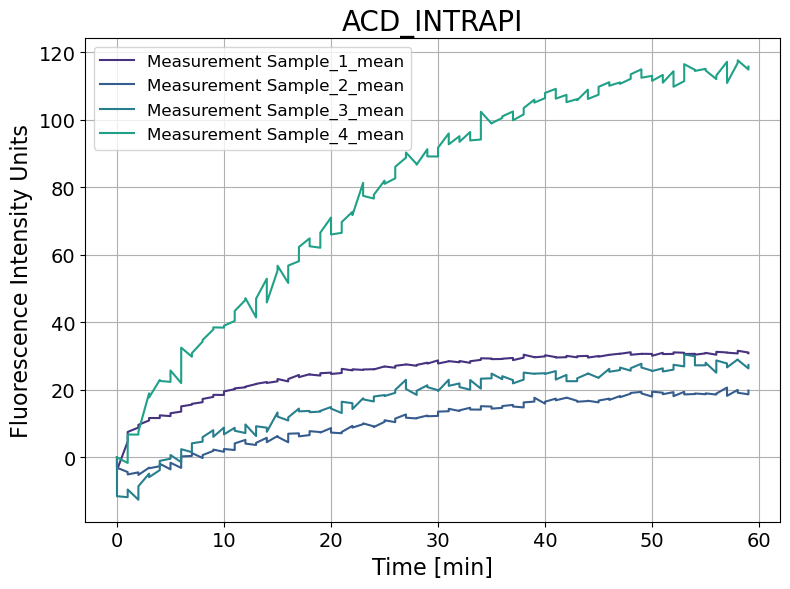

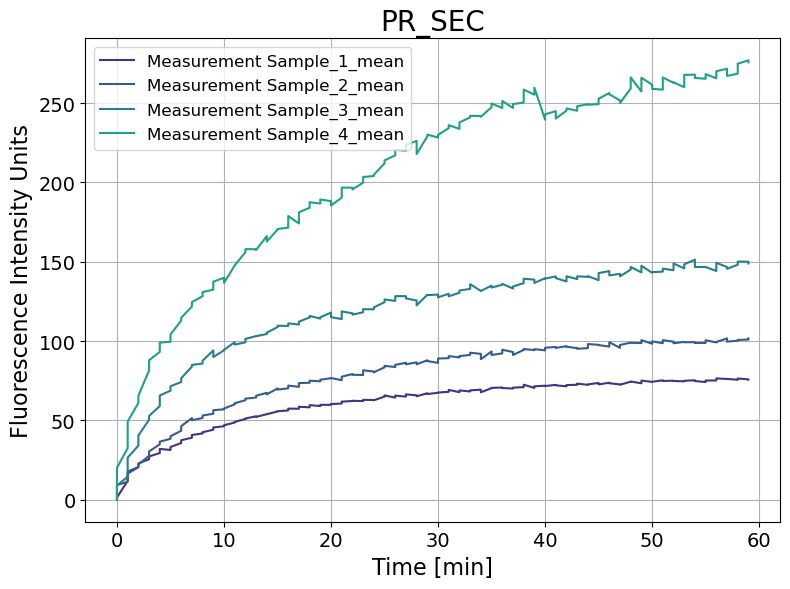

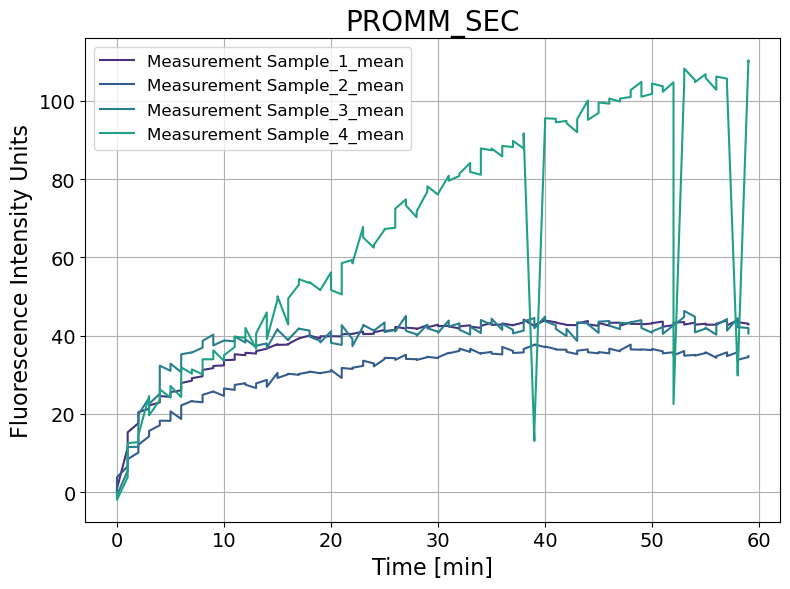

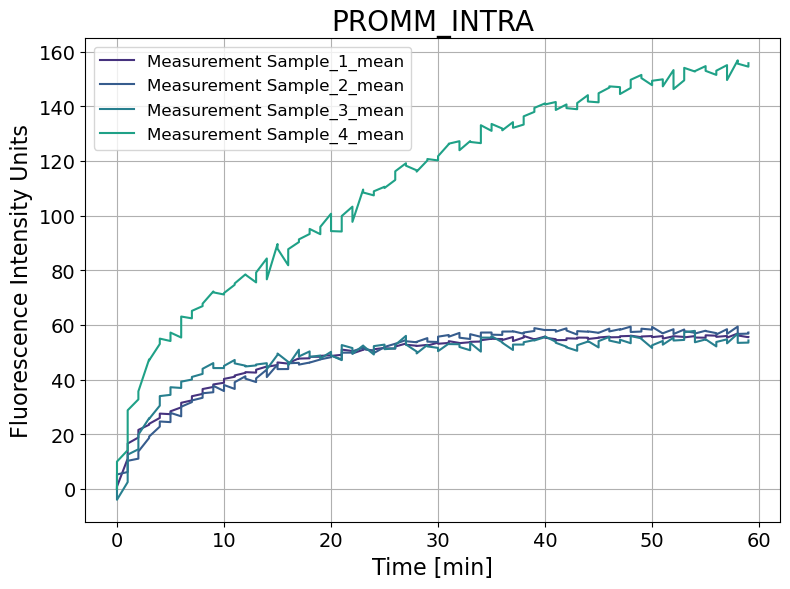

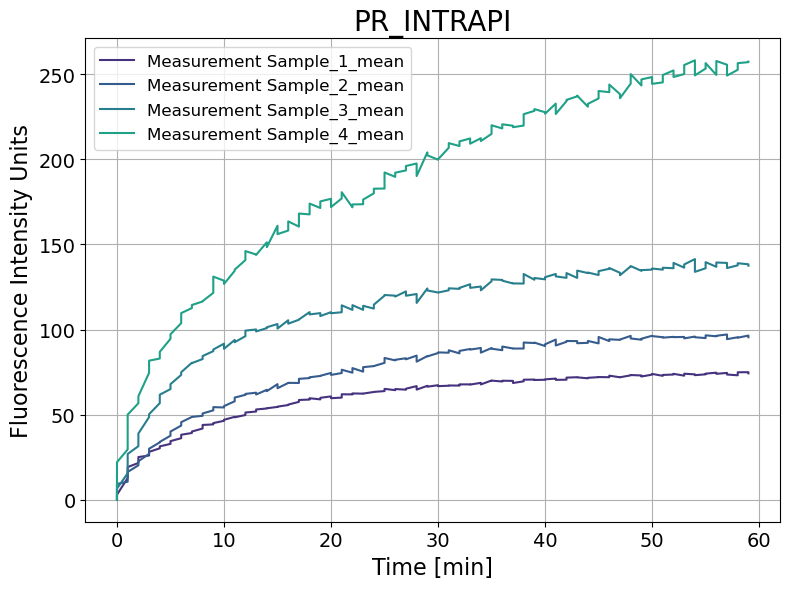

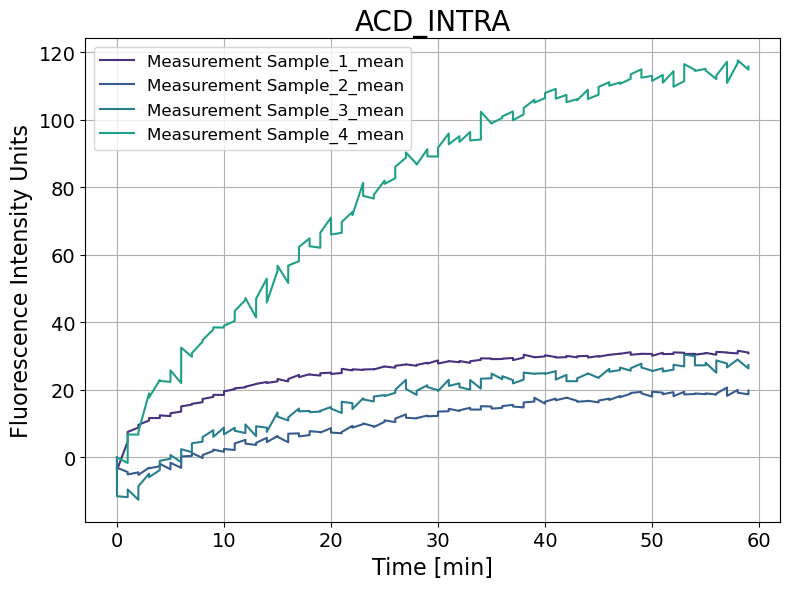

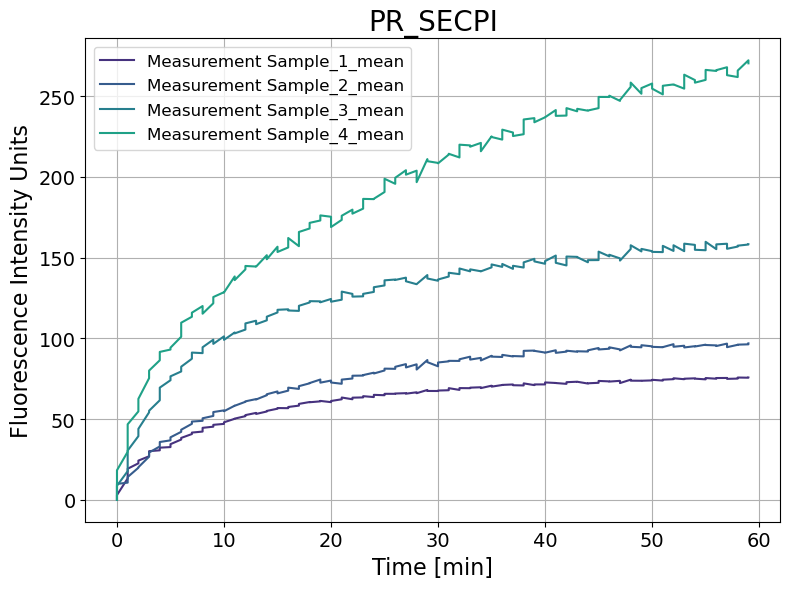

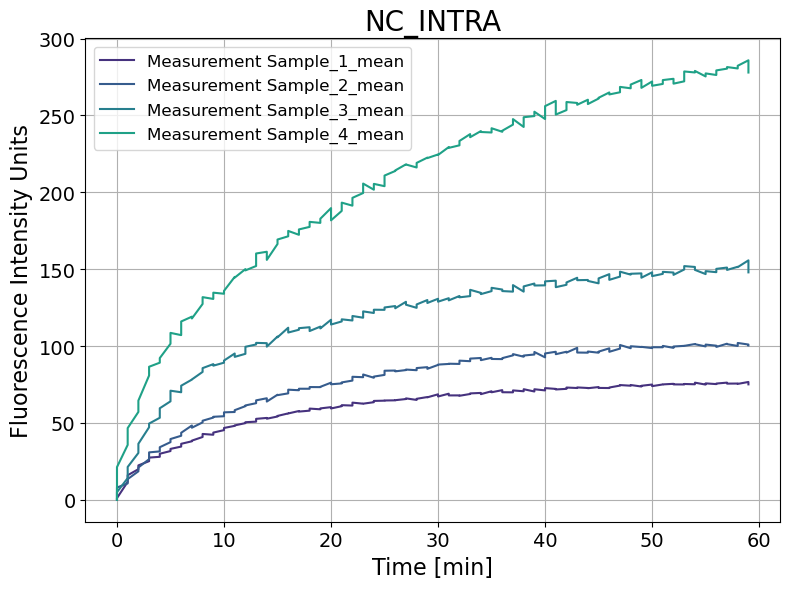

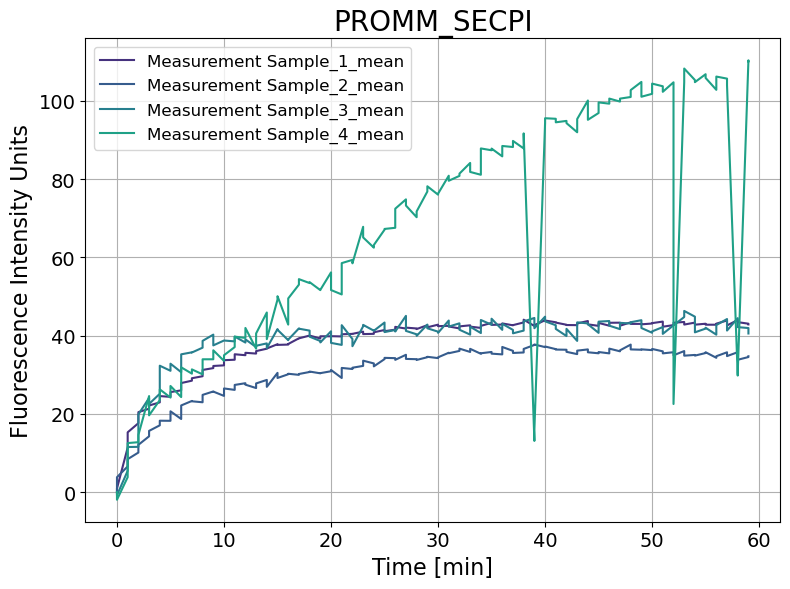

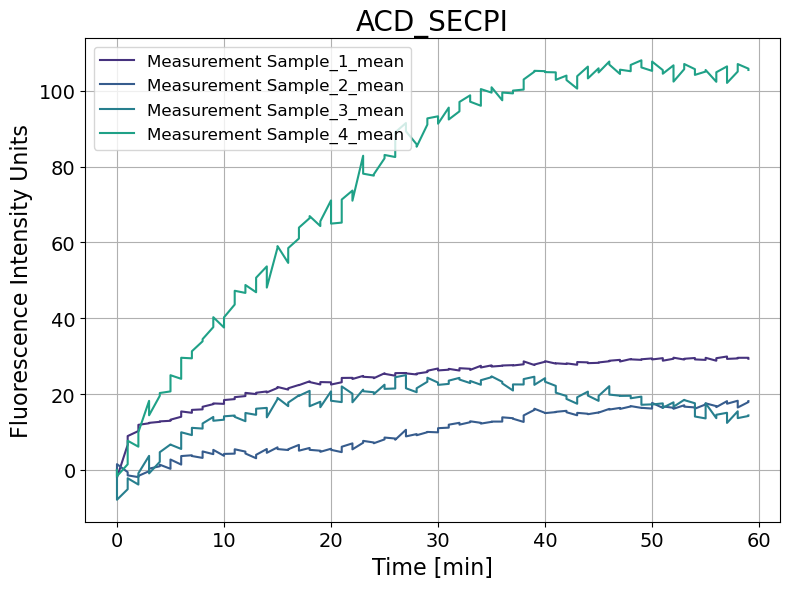

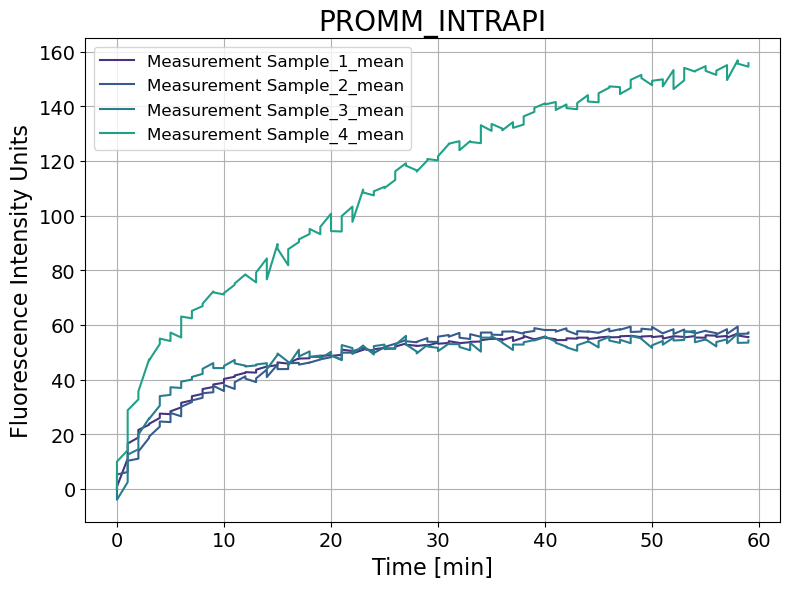

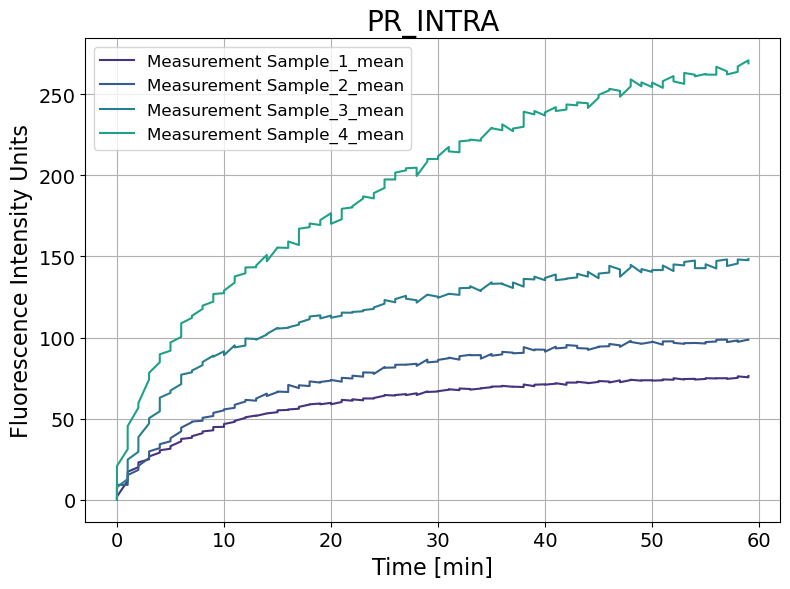

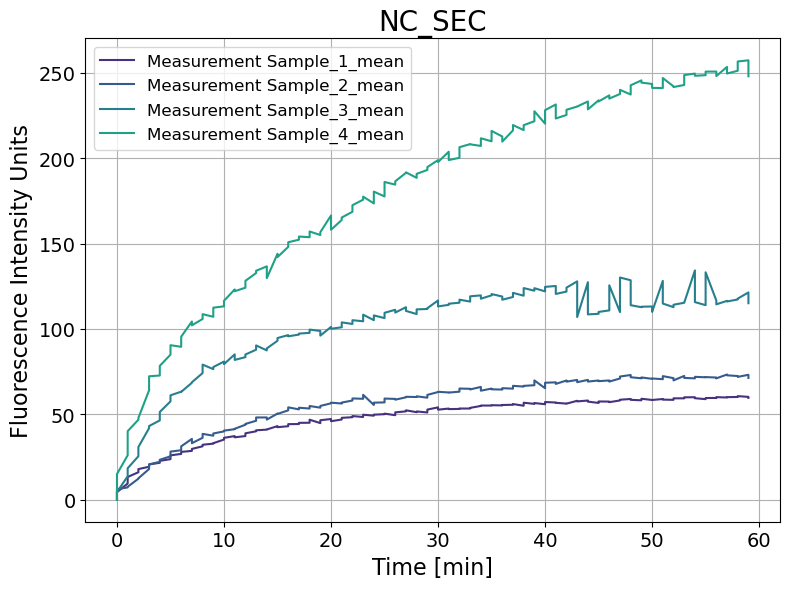

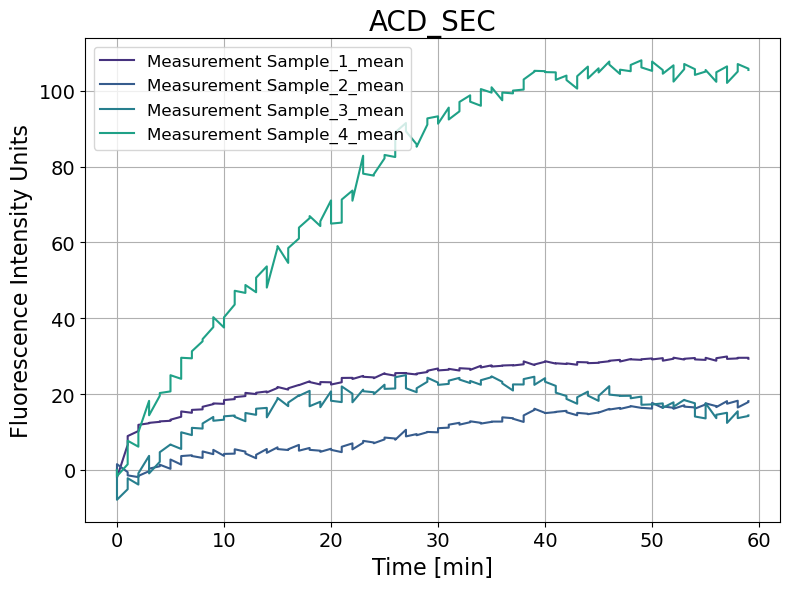

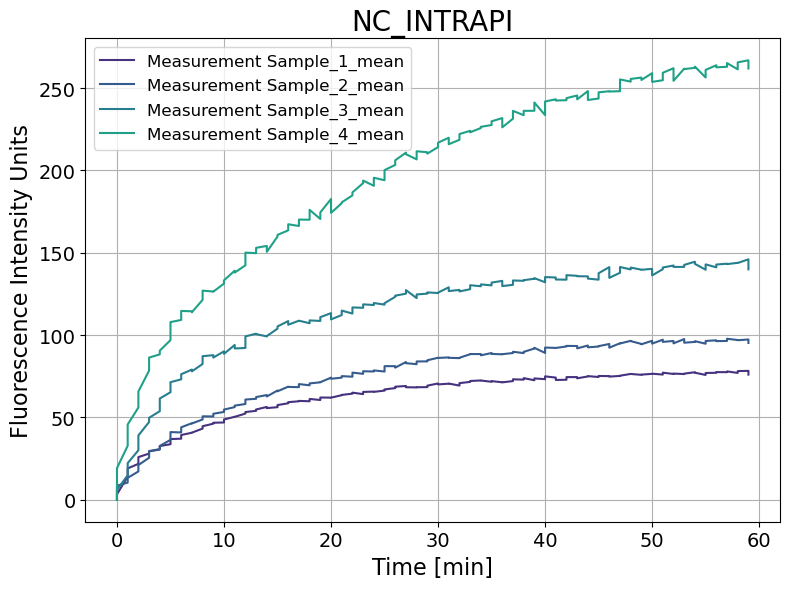

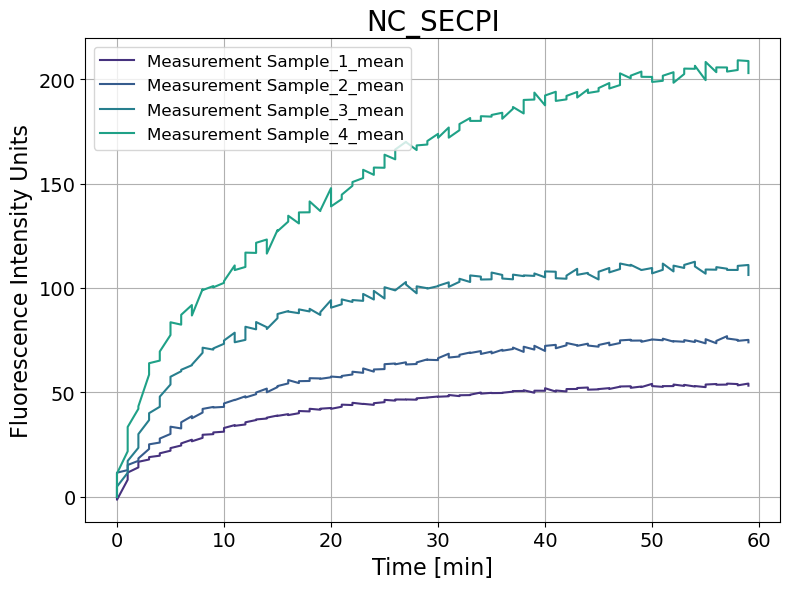

In [17]:
"""
This function can be used to plot the blank corrected fluorescence data against time. 

Function Arguments for plot_flvstime():
    * df = input data, usually in .csv or .txt format, containing raw fluorescence data
    * protein_name = Name of the sample, will appear in title
    * filename = name of the desired output filename

Returns: plots of fluorescence vs. time in min.

The function plot_meanflvstime() is a function to plot mean fluorescence vs. time
"""
def plot_flvstime(data_dic):
    for key, df in data_dic.items():
        # Calculate the mean and std for each triplicates using the function mean_std() and assign to variables mean and std
        df = mean_std(df)
        # Convert time column values to units of hours using the timetohours() function and safe data to df as new column named 'Time_hr'
        df['Time_hr'] = df['Time'].apply(timetomin)
        # Normalize
        df = normalize(df)
        
        colors=sns.color_palette("viridis")

        ## LETS PLOT OUR FIGURE
        plt.figure(figsize=(8, 6))
        '''
        This commented out section plots each measurement separately. 
        This is a little messy but can be helpful for quality control.
        '''
        # Iterate i through each triplicate column col (1, 2, 3) of each sample in the dataframe, excluding the Time column
        #for i, col in enumerate(df.columns[1:13]): 
            # Create a plot of the selected triplicate columns (col) against the time in hours and add a label for each measurement
            # plt.plot(df['Time_hr'], df[col], label=f"Measurement {col}")

        '''
        Below plot the mean of the triplicate measurements. 
        '''
        for i, col in enumerate(df.columns[1:5]):
            plt.plot(df['Time_hr'], df[col],label=f"Measurement {col}", color=colors[i])
        
        # Customize the plot
        plt.title(f"{key}", fontsize=20)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Time [min]", fontsize=16)
        plt.ylabel(r'Fluorescence Intensity Units', fontsize=16)
        plt.legend(loc='upper left', fontsize='12')
        plt.grid()
        plt.tight_layout()

        # Display the plot and save (optional, uncomment if you want to save in figures/ folder).
        plt.savefig(f"../figures/kinetics/{key}_meankinetics.pdf", format='pdf')
        plt.show()

plot_flvstime(fluorescence_dic)

In [47]:
"""
This function plots fluorescence kinetics with polynomial fitting and displays fit statistics.
    Parameters:
        - df: DataFrame with 'Time' and fluorescence data
        - protein_name: Name of the protein for the title
        - title: Additional plot title
        - filename: Output filename for saving the plot
        - figsize: Figure size
    
    Returns:
        - fit_stats: Dictionary with max derivative and fit statistics for each condition
"""

def plot_kinetics(data_dic, degree):

    for key, df in data_dic.items():
        # Calculate the mean and std for each triplicates using the function mean_std() and assign to variables mean and std
        df = mean_std(df)
        # Convert time column values to units of hours using the timetohours() function and safe data to df as new column named 'Time_hr'
        df['Time_hr'] = df['Time'].apply(timetomin)
        time = df['Time_hr']
        
        # Normalize
        df = normalize(df)

        plt.figure(figsize=(15, 8))
        fit_stats = {}  # Dictionary to store fit statistics

        # Apply Viridis color palette with length of the color palette defined by number of columns (samples)
        colors = sns.color_palette("viridis", n_colors=len(df.columns))

        ## Fit a polynomial fit to the data. 
        # for each column, we assign an index with the enumerate function.
        for i, col in enumerate(df.columns):
            # plot the fluorescence of the normalized data  vs. time. Labels and colors are based on the column that is currently run
            if col != 'Time' and 'Std' not in col:
                plt.plot(time, df[col], label=col, color=colors[i])
                # if there are no errors, following code will be executed:
                try:
                    # Polynomial fitting 
                    poly = Polynomial.fit(time, df[col], degree) #run the polynomial fit using the new Numpy Polynomial.fit and assign to poly_coeff variable
                    poly_eval = poly(time) # evaluates the polynomial by calculating the values of the coefficients at each timepoint
    
                    # Derivative and its evaluation
                    deriv_poly = poly.deriv()
                    deriv_values = deriv_poly(time)
    
                    # Max growth rate (maximal value of the derivative = max slope in the fit; extract time of occurence to evaluate. Should be t=0)
                    max_derivative = np.max(deriv_values)
                    max_derivative_time = time[np.argmax(deriv_values)]
    
                    # Fit statistic - compute R^2 
                    R2 = 1 - np.sum((df[col] - poly_eval) ** 2) / np.sum((df[col] - np.mean(df[col])) ** 2)
    
                    # Store all the values in a dictionary such that we can call them later.
                    fit_stats[col] = {
                        "max_derivative": max_derivative,
                        "max_derivative_time": max_derivative_time,
                        "R²": R2,
                        "Std_derivative": np.std(deriv_values)
                     }
    
                    # Print the statistics
                    print(f"\n{col}:")
                    print(f"  Max derivative: {max_derivative:.4f} at {max_derivative_time} min")
                    print(f"  R²: {R2:.4f}")
                    print(f"  Std of derivative: {np.std(deriv_values):.4f}")
    
                    # Plot polynomial fit
                    plt.plot(time, poly_eval, '--', color=colors[i], alpha=0.8, label=f"{col} (Poly Fit)")
                
                # If there is an error in the function, it will call the exception and launch an error message. 
                except Exception as e:
                    print(f"Error in fitting polynomial for {col}: {e}")

                plt.xlabel('Time [min]')
                plt.ylabel('Fluorescence Intensity')
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                
                #plt.savefig(f"../figures/kinetics/{key}_polyfit.pdf", format='pdf')
                plt.show()
                plt.close()
                
                # Open a csv file for writing the fit statistics and extracted derivative into a file
                with open(f"../output/polyfit_data_{key}.csv", "w", newline="") as file:
                    # Create a writer object
                    writer = csv.DictWriter(file, fieldnames=fit_stats.keys())
                    # Write the header row
                    writer.writeheader()
                    # Write the data rows
                    writer.writerow(fit_stats)
        return fit_stats


Sample_1_mean:
  Max derivative: 6.8856 at 0 min
  R²: 0.9933
  Std of derivative: 1.1040


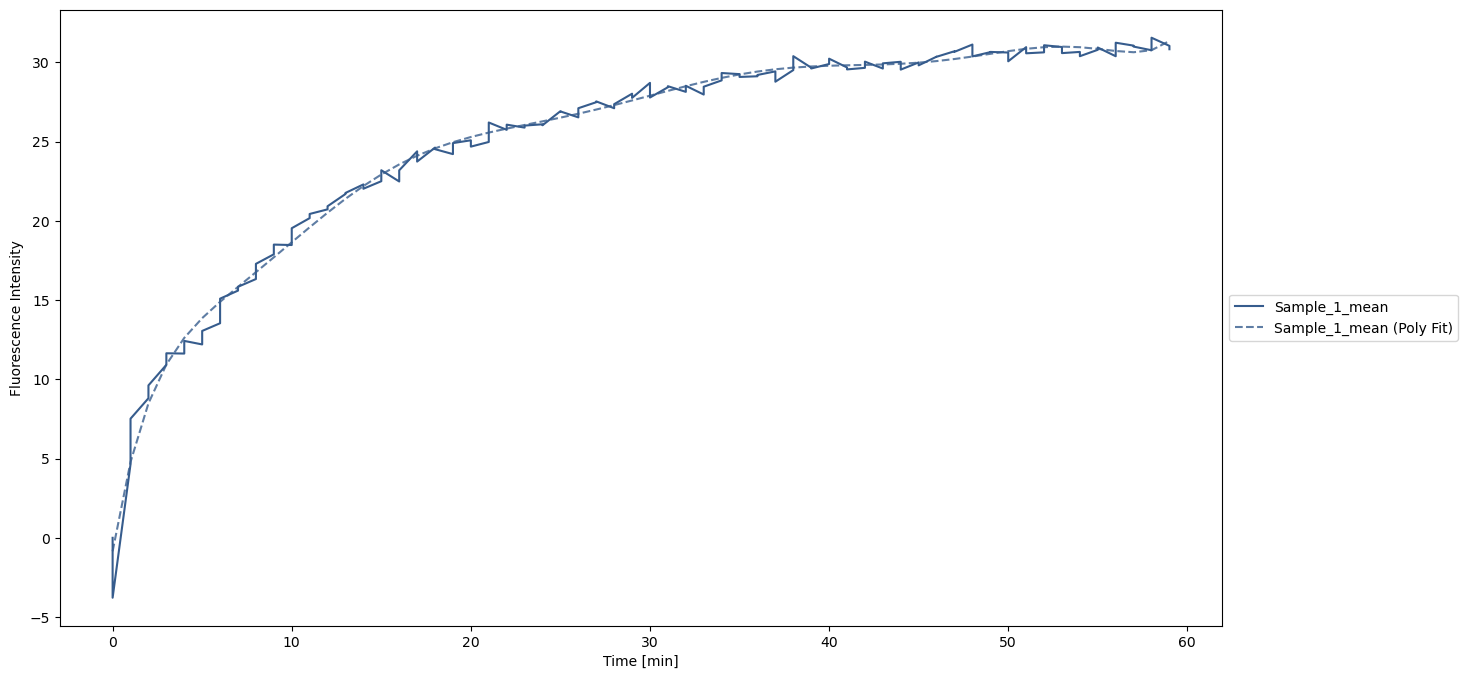


Sample_1_mean:
  Max derivative: 6.8856 at 0 min
  R²: 0.9933
  Std of derivative: 1.1040

Sample_2_mean:
  Max derivative: 1.0826 at 6 min
  R²: 0.9898
  Std of derivative: 0.4581


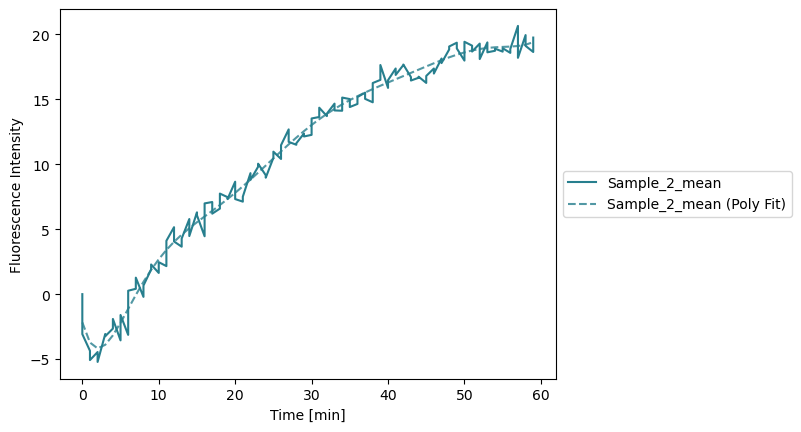


Sample_2_mean:
  Max derivative: 1.0826 at 6 min
  R²: 0.9898
  Std of derivative: 0.4581

Sample_3_mean:
  Max derivative: 2.5871 at 4 min
  R²: 0.9775
  Std of derivative: 0.8340


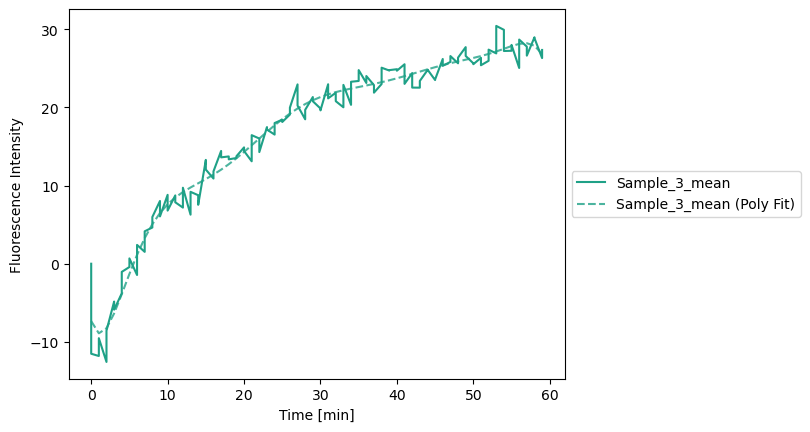


Sample_3_mean:
  Max derivative: 2.5871 at 4 min
  R²: 0.9775
  Std of derivative: 0.8340

Sample_4_mean:
  Max derivative: 6.2103 at 0 min
  R²: 0.9956
  Std of derivative: 1.4503


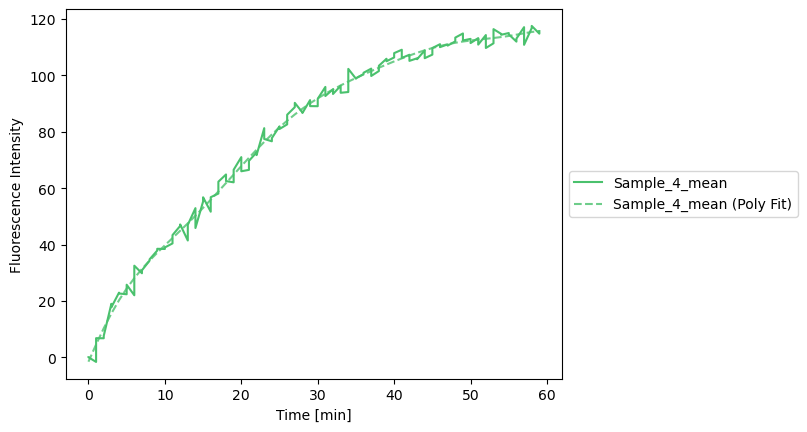


Sample_4_mean:
  Max derivative: 6.2103 at 0 min
  R²: 0.9956
  Std of derivative: 1.4503

Time_hr:
  Max derivative: 1.0000 at 59 min
  R²: 1.0000
  Std of derivative: 0.0000


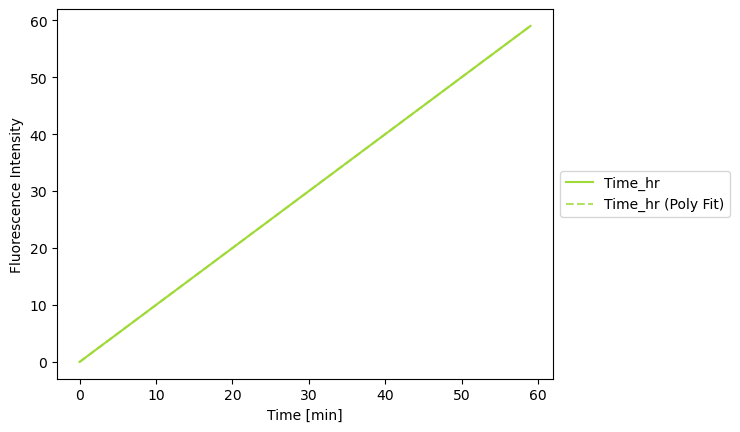


Time_hr:
  Max derivative: 1.0000 at 59 min
  R²: 1.0000
  Std of derivative: 0.0000


{'Sample_1_mean': {'max_derivative': np.float64(6.8855566498951255),
  'max_derivative_time': np.int64(0),
  'R²': np.float64(0.9932551410538469),
  'Std_derivative': np.float64(1.103999741781392)},
 'Sample_2_mean': {'max_derivative': np.float64(1.082640277136634),
  'max_derivative_time': np.int64(6),
  'R²': np.float64(0.9897943265484764),
  'Std_derivative': np.float64(0.45805344670477327)},
 'Sample_3_mean': {'max_derivative': np.float64(2.58707560559714),
  'max_derivative_time': np.int64(4),
  'R²': np.float64(0.9774619050786518),
  'Std_derivative': np.float64(0.8339832092153665)},
 'Sample_4_mean': {'max_derivative': np.float64(6.210346786501805),
  'max_derivative_time': np.int64(0),
  'R²': np.float64(0.9955540220809419),
  'Std_derivative': np.float64(1.4503212168857285)},
 'Time_hr': {'max_derivative': np.float64(1.0000000000000318),
  'max_derivative_time': np.int64(59),
  'R²': np.float64(1.0),
  'Std_derivative': np.float64(8.36222261944009e-15)}}

In [48]:
plot_kinetics(fluorescence_dic, 9)

In [16]:
def michaelis_menten_poly(blank_corr_data, substrate_concentrations, protein_name='', title='', filename='', include_mask=None, n_bootstrap=10000):
    """
    Fits Michaelis-Menten kinetics using initial rates extracted from 9th-degree polynomial slopes.
    Includes bootstrapped errors for initial rates.

    Parameters:
        - blank_corr_data: DataFrame with fluorescence data and 'Time' column
        - substrate_concentrations: List of substrate concentrations (nmol/ml)
        - protein_name: Name of the protein for the title
        - title: Additional plot title
        - filename: Output filename for saving the plot
        - include_mask: Mask for excluding outliers (optional)
        - n_bootstrap: Number of bootstrap samples

    Returns:
        - Vmax, Km, Vmax_err, Km_err, r_squared, fit_stats
    """

    def michaelis_menten_eq(s, Vmax, Km):
        return (Vmax * s) / (Km + s)

    def michaelis_menten_competition(s, Vmax, Km, I):
        return (Vmax * s) / (Km * (1+(I/Km)) + s)

    # Convert the 'Time' column to minutes
    def timetomin(time_str):
        h, m, s = map(int, time_str.split(':'))
        return h * 60 + m

    time = blank_corr_data['Time'].apply(timetomin)

    # Extract initial rates using 9th-degree polynomial fit
    initial_rates = []
    initial_rate_errors = []  # Store bootstrap errors

    plt.figure(figsize=(12, 8))
    colors = sns.color_palette("viridis")

    for i, col in enumerate(blank_corr_data.columns):
        if col != 'Time' and 'Std' not in col:
            substrate_curve = blank_corr_data[col]

            # Filter data to ≤ 60 minutes for polynomial fitting
            mask = time <= 60
            time_filtered = time[mask].values
            substrate_filtered = substrate_curve[mask].values

            # Normalize the data to start at 0 fluorescence
            substrate = substrate_filtered.copy()
            substrate = substrate_filtered - substrate_filtered[0]
                    
            if len(time_filtered) > 9:
                # Bootstrap resampling
                slopes = []

                for _ in range(n_bootstrap):
                    # Randomly sample data with replacement
                    boot_indices = np.random.choice(len(time_filtered), len(time_filtered), replace=True)
                    boot_time = time_filtered[boot_indices]
                    boot_substrate = substrate_filtered[boot_indices]

                    # Fit 9th-degree polynomial
                    poly_coeff = np.polyfit(boot_time, boot_substrate, 9)
                    poly_derivative_coeff = np.polyder(poly_coeff)

                    # Get the slope at time=0
                    initial_slope = np.polyval(poly_derivative_coeff, 0)
                    slopes.append(initial_slope)

                # Calculate mean and standard deviation of slopes
                mean_slope = np.mean(slopes)
                std_slope = np.std(slopes)

                initial_rates.append(mean_slope)
                initial_rate_errors.append(std_slope)

                # Plot the individual fluorescence curves
                plt.plot(time_filtered, substrate, label=f"{col}", color=colors[i])
            else:
                initial_rates.append(np.nan)
                initial_rate_errors.append(np.nan)

    plt.title(f'Polynomial Fits - {protein_name} {title}', fontsize=16)
    plt.xlabel('Time [min]', fontsize=14)
    plt.ylabel('Fluorescence', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.show()

    # Prepare data for Michaelis-Menten fitting
    initial_rates = np.array(initial_rates)
    initial_rate_errors = np.array(initial_rate_errors)
    substrate_concentrations = np.array(substrate_concentrations)

    
    # Add the point (0, 0) to enforce the curve passes through the origin
    initial_rates = np.insert(initial_rates, 0, 0)
    initial_rate_errors = np.insert(initial_rate_errors, 0,1e-6)
    substrate_concentrations = np.insert(substrate_concentrations, 0, 0)

    # Apply mask to remove outliers, if provided
    if include_mask is not None:
        initial_rates = initial_rates[include_mask]
        initial_rate_errors = initial_rate_errors[include_mask]
        substrate_concentrations = np.array(substrate_concentrations)[include_mask]

    I_fixed = 87  # µM unlabeled casein as fixed competitive inhibitor

    # pass I (concnetration of unlabelled casein as a fixed number (here 87 µM)
    def model_with_fixed_I(s, Vmax, Km):
        return michaelis_menten_competition(s, Vmax, Km, I_fixed)

    '''
    Uncomment this if using normal Michaelis menten equation
    '''
    # Fit the Michaelis-Menten equation using initial rate errors as sigma
   # popt, pcov = curve_fit(
    #    michaelis_menten_eq, 
     #   substrate_concentrations, 
     #   initial_rates, 
      #  bounds=(0, [np.inf, np.inf, np.inf]), 
       # sigma=initial_rate_errors, 
        #absolute_sigma=True
    #)

    '''
    Uncomment this if using competitive Inhibitor Michaselis Menten equation
    '''

    # Perform curve fitting
    popt, pcov = curve_fit(
        model_with_fixed_I,
        substrate_concentrations,
        initial_rates,
        sigma=initial_rate_errors,
        absolute_sigma=True,
        bounds=(0, [np.inf, np.inf])
    )

    Vmax, Km = popt
    perr = np.sqrt(np.diag(pcov))  # Standard errors from covariance matrix
    Vmax_err, Km_err = perr

    # Calculate residuals and R²
    fitted_rates = model_with_fixed_I(substrate_concentrations, Vmax, Km)
    residuals = initial_rates - fitted_rates

    RSS = np.sum(residuals**2)
    TSS = np.sum((initial_rates - np.mean(initial_rates))**2)
    R2 = 1 - (RSS / TSS)
    RMSE = np.sqrt(RSS / len(initial_rates))
    n = len(initial_rates)
    p = 2  # Two parameters in Michaelis-Menten
    adj_R2 = 1 - (1 - R2) * (n - 1) / (n - p - 1)

    # Generate fitted curve
    s_fit = np.linspace(min(substrate_concentrations), max(substrate_concentrations), 200)
    rates_fit = model_with_fixed_I(s_fit, Vmax, Km)

    # Plot the Michaelis-Menten kinetics
    plt.figure(figsize=(12, 8))
    
    # Plot the initial rates against substrate concentrations
    plt.errorbar(substrate_concentrations, initial_rates, yerr=initial_rate_errors, fmt='o', color=colors[0], label='Initial Rates', capsize=5)
    
    # Plot the fitted Michaelis-Menten curve
    plt.plot(s_fit, rates_fit, label=f'Fit: $V_{{max}}$={Vmax:.2f} ± {Vmax_err:.2f}, $K_m$={Km:.6f} ± {Km_err:.6f}\n$R^2$={R2:.4f}', 
             color=colors[-1], linewidth=2)

    # Plot settings
    plt.title(f'Michaelis-Menten Kinetics - {protein_name} {title}', fontsize=16)
    plt.xlabel('Substrate Concentration [µM]', fontsize=14)
    plt.ylabel('Reaction Rate', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    #if filename: 
     #   plt.savefig(filename, format='pdf')
    plt.show()

    # Return fit parameters and statistics
    return Vmax, Km, Vmax_err, Km_err, R2, initial_rates, initial_rate_errors

substrate_concs = [0.486, 0.973, 1.945, 2.918] # µM


In [11]:
def michaelis_menten_poly_PI(blank_corr_data, substrate_concentrations, protein_name='', title='', filename='', include_mask=None, n_bootstrap=10000):
    """
    This michaelis menten fit is specifically for the case that there are only two tested substrate concentrations, not one. 
    Fits Michaelis-Menten kinetics using initial rates extracted from 9th-degree polynomial slopes.
    Includes bootstrapped errors for initial rates.

    Parameters:
        - blank_corr_data: DataFrame with fluorescence data and 'Time' column
        - substrate_concentrations: List of substrate concentrations (nmol/ml)
        - protein_name: Name of the protein for the title
        - title: Additional plot title
        - filename: Output filename for saving the plot
        - include_mask: Mask for excluding outliers (optional)
        - n_bootstrap: Number of bootstrap samples

    Returns:
        - Vmax, Km, Vmax_err, Km_err, r_squared, fit_stats
    """

    def michaelis_menten_eq(s, Vmax, Km):
        return (Vmax * s) / (Km + s)

    
    def michaelis_menten_competition(s, Vmax, Km, I):
        return (Vmax * s) / (Km * (1+(I/Km)) + s)

    # Convert the 'Time' column to minutes
    def timetomin(time_str):
        h, m, s = map(int, time_str.split(':'))
        return h * 60 + m

    time = blank_corr_data['Time'].apply(timetomin)

    # Extract initial rates using 9th-degree polynomial fit
    initial_rates = []
    initial_rate_errors = []  # Store bootstrap errors

    plt.figure(figsize=(12, 8))
    colors = sns.color_palette("viridis")

    for i, col in enumerate(blank_corr_data.columns):
        if col != 'Time' and 'Std' not in col:
            substrate_curve = blank_corr_data[col]

            # Filter data to ≤ 60 minutes for polynomial fitting
            mask = time <= 60
            time_filtered = time[mask].values
            substrate_filtered = substrate_curve[mask].values

            # Normalize the data to start at 0 fluorescence
            substrate = substrate_filtered.copy()
            substrate = substrate_filtered - substrate_filtered[0]
                    
            if len(time_filtered) > 9:
                # Bootstrap resampling
                slopes = []

                for _ in range(n_bootstrap):
                    # Randomly sample data with replacement
                    boot_indices = np.random.choice(len(time_filtered), len(time_filtered), replace=True)
                    boot_time = time_filtered[boot_indices]
                    boot_substrate = substrate_filtered[boot_indices]

                    # Fit 9th-degree polynomial
                    poly_coeff = np.polyfit(boot_time, boot_substrate, 9)
                    poly_derivative_coeff = np.polyder(poly_coeff)

                    # Get the slope at time=0
                    initial_slope = np.polyval(poly_derivative_coeff, 0)
                    slopes.append(initial_slope)

                # Calculate mean and standard deviation of slopes
                mean_slope = np.mean(slopes)
                std_slope = np.std(slopes)

                initial_rates.append(mean_slope)
                initial_rate_errors.append(std_slope)

                # Plot the individual fluorescence curves
                plt.plot(time_filtered, substrate, label=f"{col}", color=colors[i])
            else:
                initial_rates.append(np.nan)
                initial_rate_errors.append(np.nan)

    plt.title(f'Polynomial Fits - {protein_name} {title}', fontsize=16)
    plt.xlabel('Time [min]', fontsize=14)
    plt.ylabel('Fluorescence', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.show()

    # Prepare data for Michaelis-Menten fitting
    initial_rates = np.array(initial_rates)
    initial_rate_errors = np.array(initial_rate_errors)
    substrate_concentrations = np.array(substrate_concentrations)

    
    # Add the point (0, 0) to enforce the curve passes through the origin
    initial_rates = np.insert(initial_rates, 0, 0)
    initial_rate_errors = np.insert(initial_rate_errors, 0,1e-6)
    substrate_concentrations = np.insert(substrate_concentrations, 0, 0)

    # Apply mask to remove outliers, if provided
    if include_mask is not None:
        initial_rates = initial_rates[include_mask]
        initial_rate_errors = initial_rate_errors[include_mask]
        substrate_concentrations = np.array(substrate_concentrations)[include_mask]

    I_fixed = 87  # µM unlabeled casein as fixed competitive inhibitor

    # pass I (concnetration of unlabelled casein as a fixed number (here 87 µM)
    def model_with_fixed_I(s, Vmax, Km):
        return michaelis_menten_competition(s, Vmax, Km, I_fixed)

    '''
    Uncomment this if using normal Michaselis Menten equation
    '''
    # Fit the Michaelis-Menten equation using initial rate errors as sigma
    #popt, pcov = curve_fit(
     #   michaelis_menten_eq, 
      #  substrate_concentrations, 
       # initial_rates, 
        #bounds=(0, [np.inf, np.inf]), 
        #sigma=initial_rate_errors, 
        #absolute_sigma=True
    #)
    '''
    Uncomment this if using competitive Inhibitor Michaselis Menten equation
    '''

    # Perform curve fitting
    popt, pcov = curve_fit(
        model_with_fixed_I,
        substrate_concentrations,
        initial_rates,
        sigma=initial_rate_errors,
        absolute_sigma=True,
        bounds=(0, [np.inf, np.inf])
    )

    Vmax, Km = popt
    perr = np.sqrt(np.diag(pcov))  # Standard errors from covariance matrix
    Vmax_err, Km_err = perr

    #Calculate residuals and R²
    fitted_rates = michaelis_menten_eq(substrate_concentrations, Vmax, Km)
    residuals = initial_rates - fitted_rates

    RSS = np.sum(residuals**2)
    TSS = np.sum((initial_rates - np.mean(initial_rates))**2)
    R2 = 1 - (RSS / TSS)
    RMSE = np.sqrt(RSS / len(initial_rates))
    n = len(initial_rates)
    p = 2  # Two parameters in Michaelis-Menten
    adj_R2 = 1 - (1 - R2) * (n - 1) / (n - p - 1)

    # Generate fitted curve
    s_fit = np.linspace(min(substrate_concentrations), max(substrate_concentrations), 200)
    rates_fit = michaelis_menten_eq(s_fit, Vmax, Km)

    # Plot the Michaelis-Menten kinetics
    plt.figure(figsize=(12, 8))
    
    # Plot the initial rates against substrate concentrations
    plt.errorbar(substrate_concentrations, initial_rates, yerr=initial_rate_errors, fmt='o', color=colors[0], label='Initial Rates', capsize=5)
    
    # Plot the fitted Michaelis-Menten curve
    plt.plot(s_fit, rates_fit, label=f'Fit: $V_{{max}}$={Vmax:.2f} ± {Vmax_err:.2f}, $K_m$={Km:.6f} ± {Km_err:.6f}\n$R^2$={R2:.4f}', 
             color=colors[-1], linewidth=2)

    # Plot settings
    plt.title(f'Michaelis-Menten Kinetics - {protein_name} {title}', fontsize=16)
    plt.xlabel('Substrate Concentration [nmol/ml]', fontsize=14)
    plt.ylabel('Reaction Rate', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    #if filename: 
     #   plt.savefig(filename, format='pdf')
    plt.show()

    # Return fit parameters and statistics
    return Vmax, Km, Vmax_err, Km_err, R2, initial_rates, initial_rate_errors

substrate_concs = [0.973, 1.945] # µM

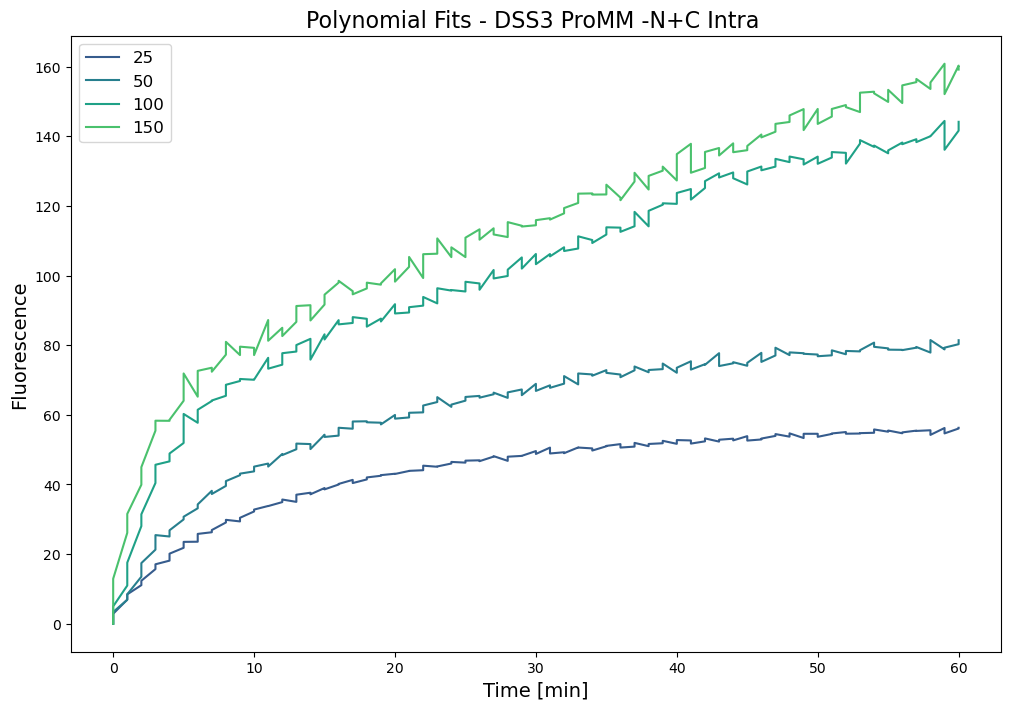

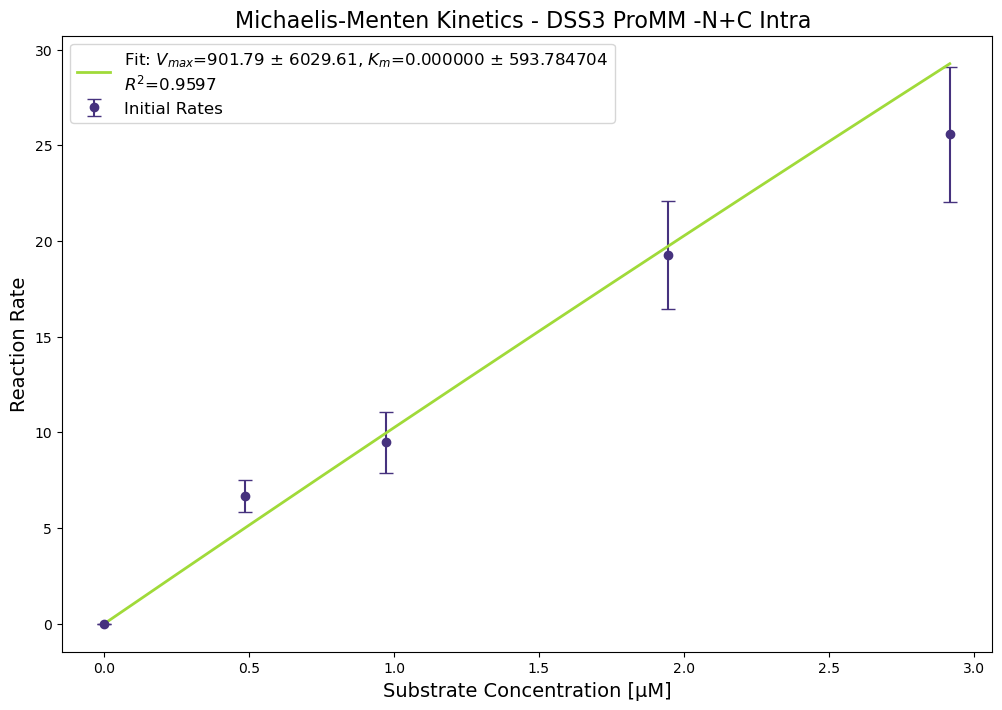

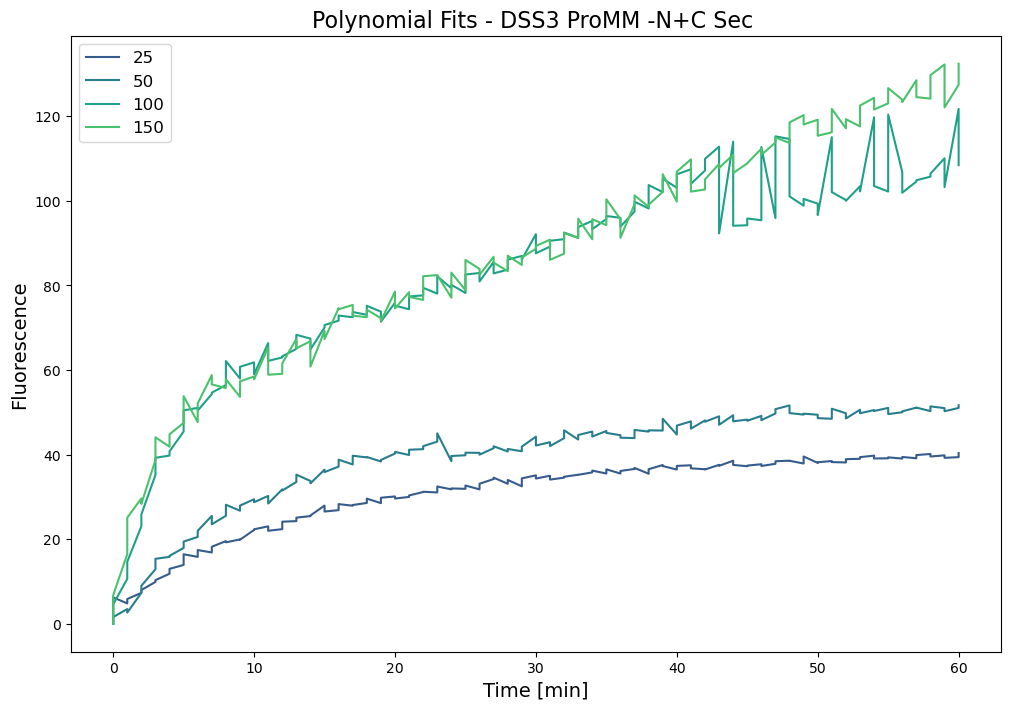

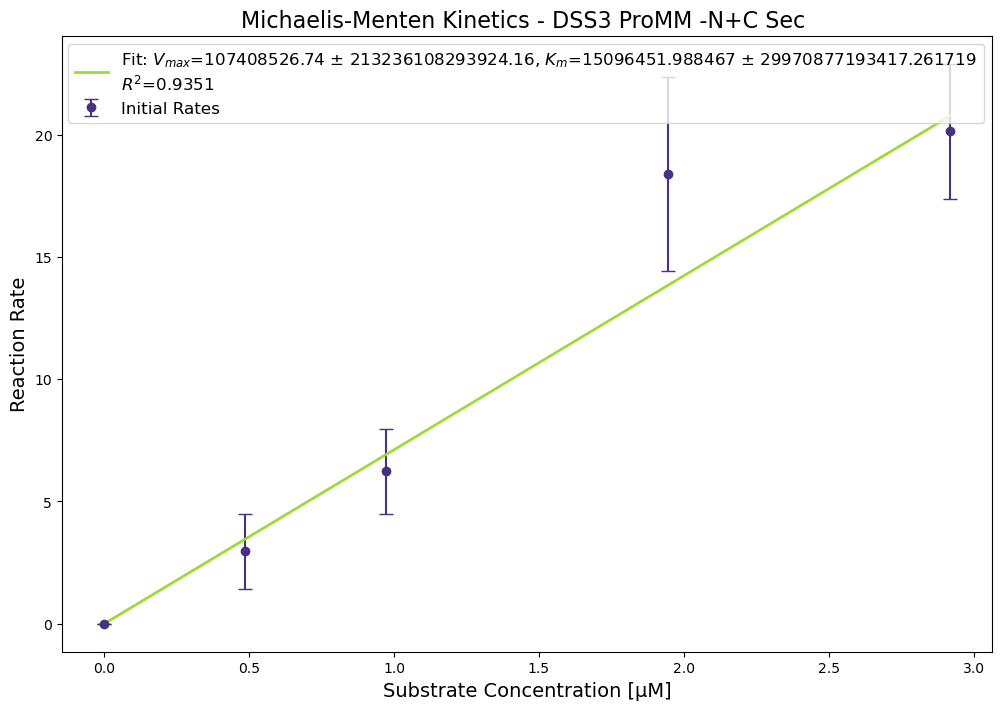

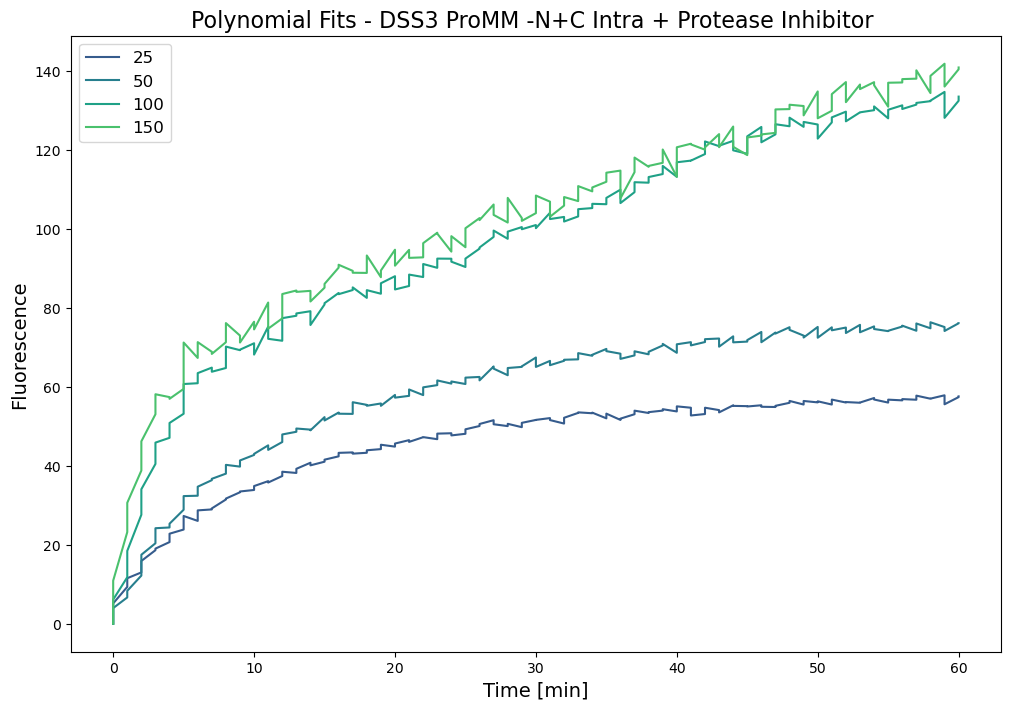

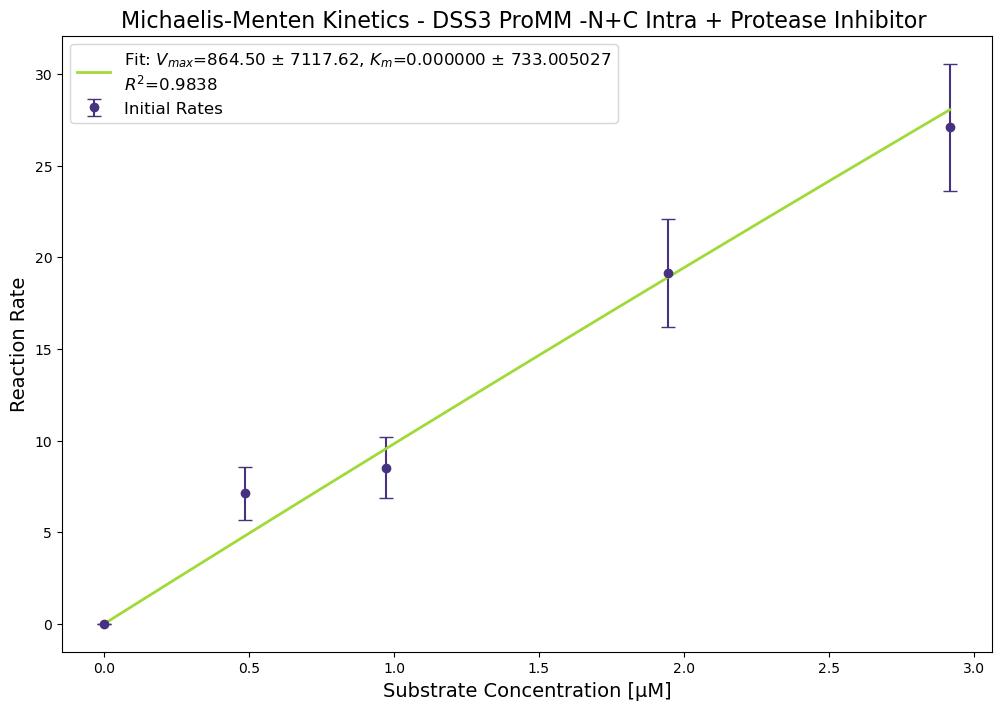

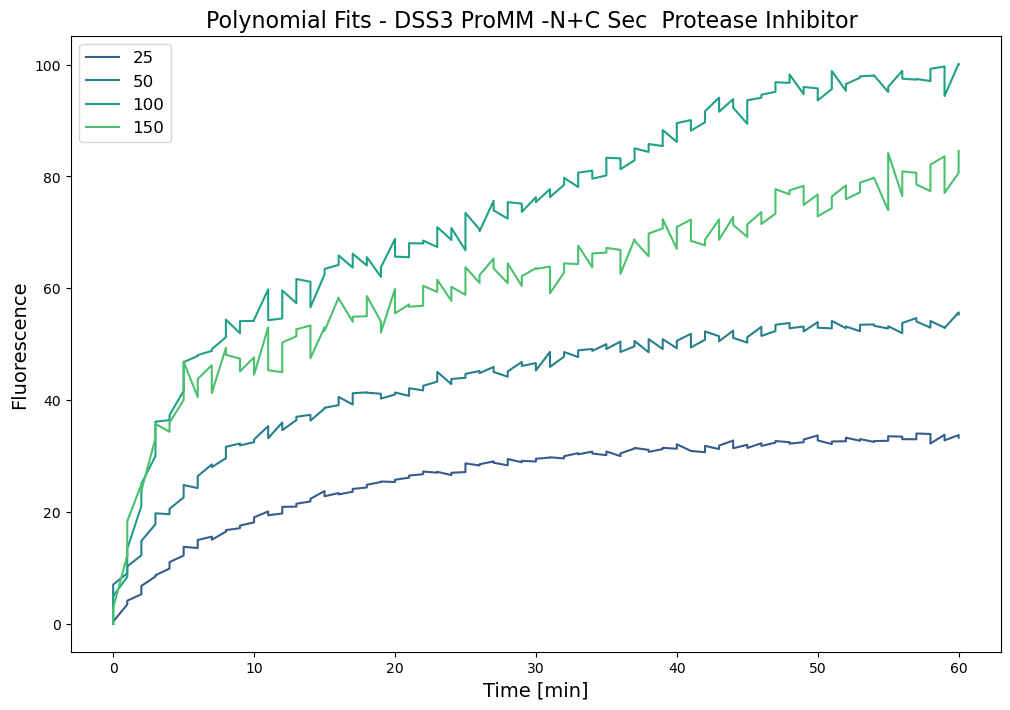

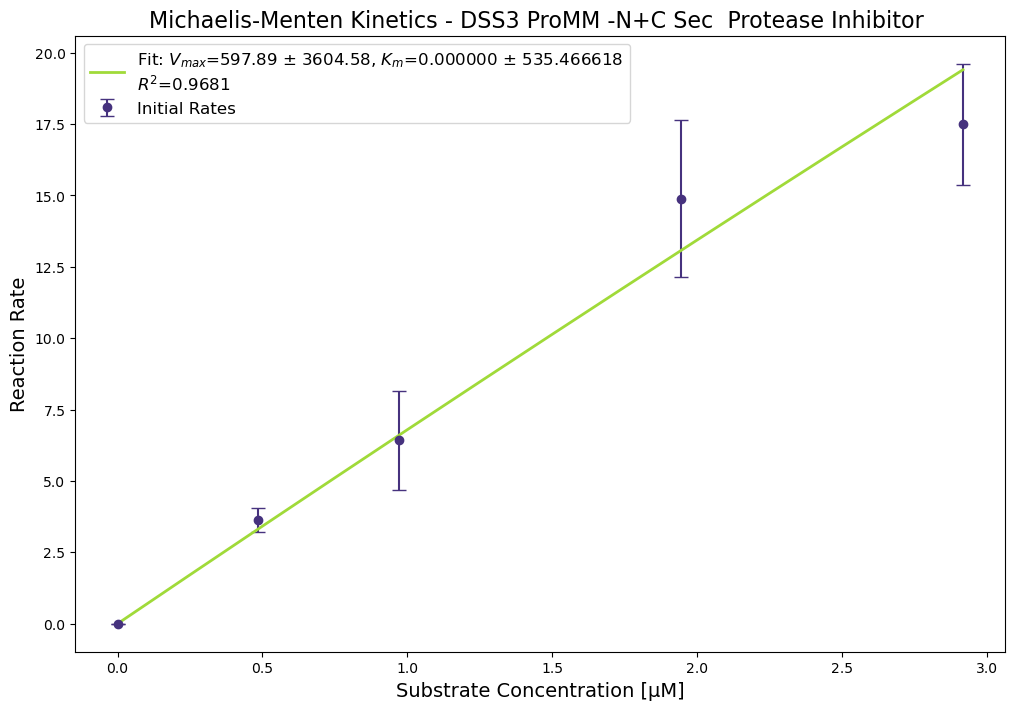

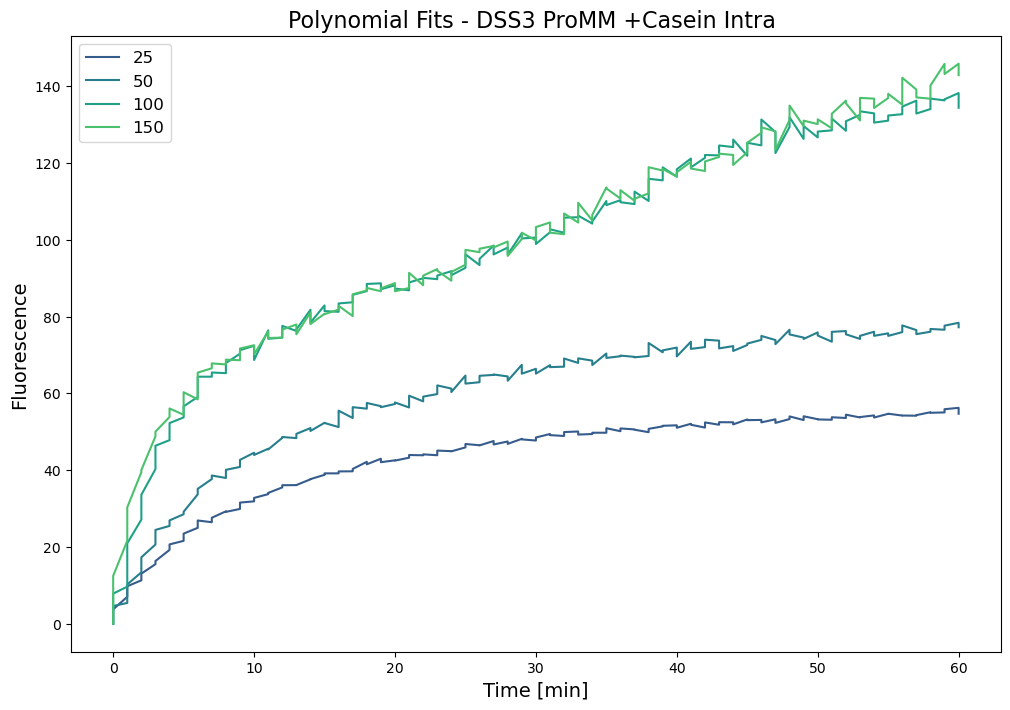

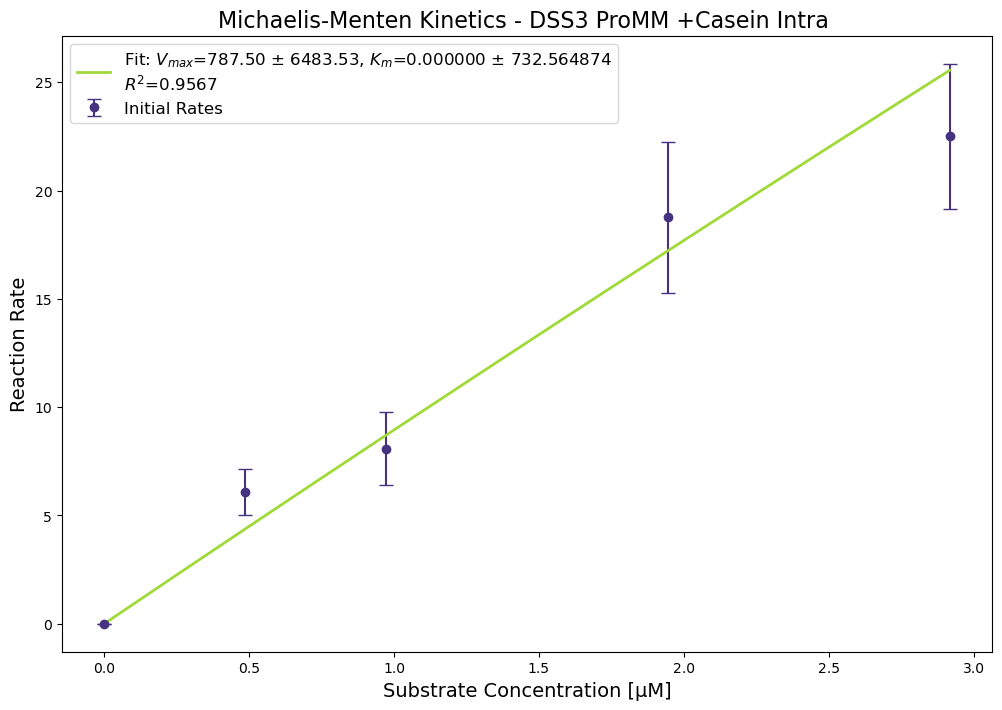

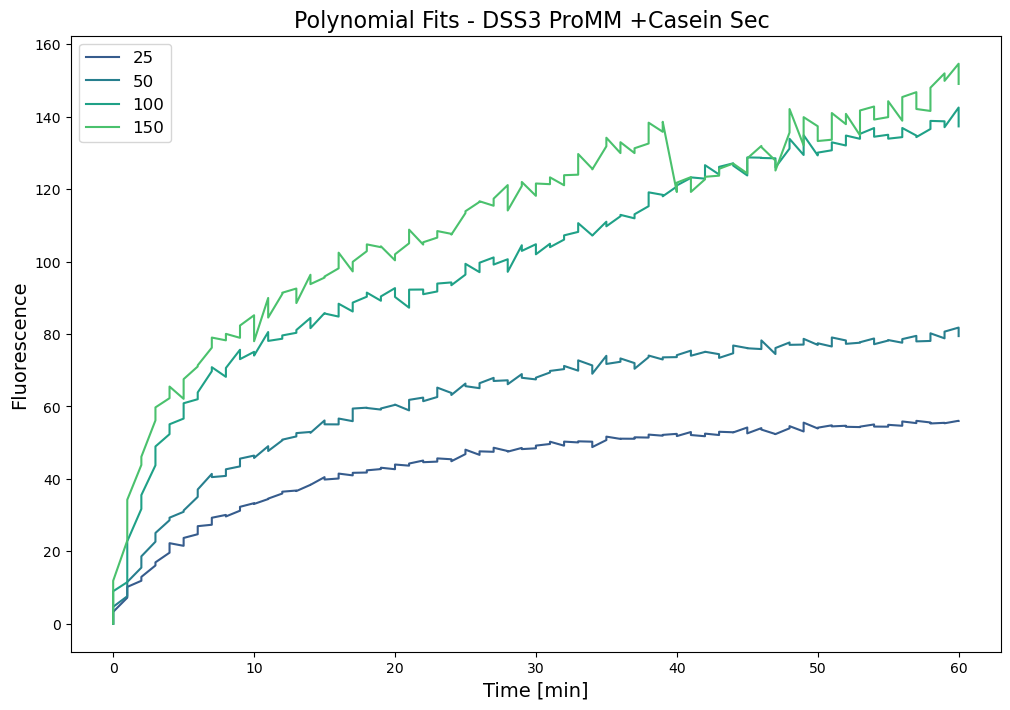

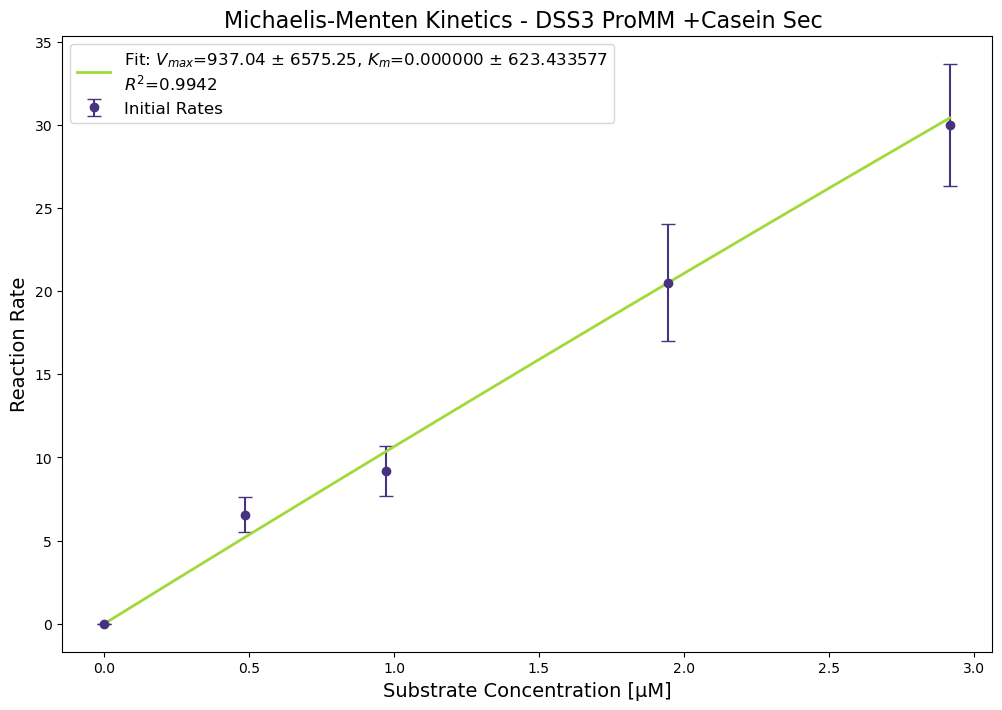

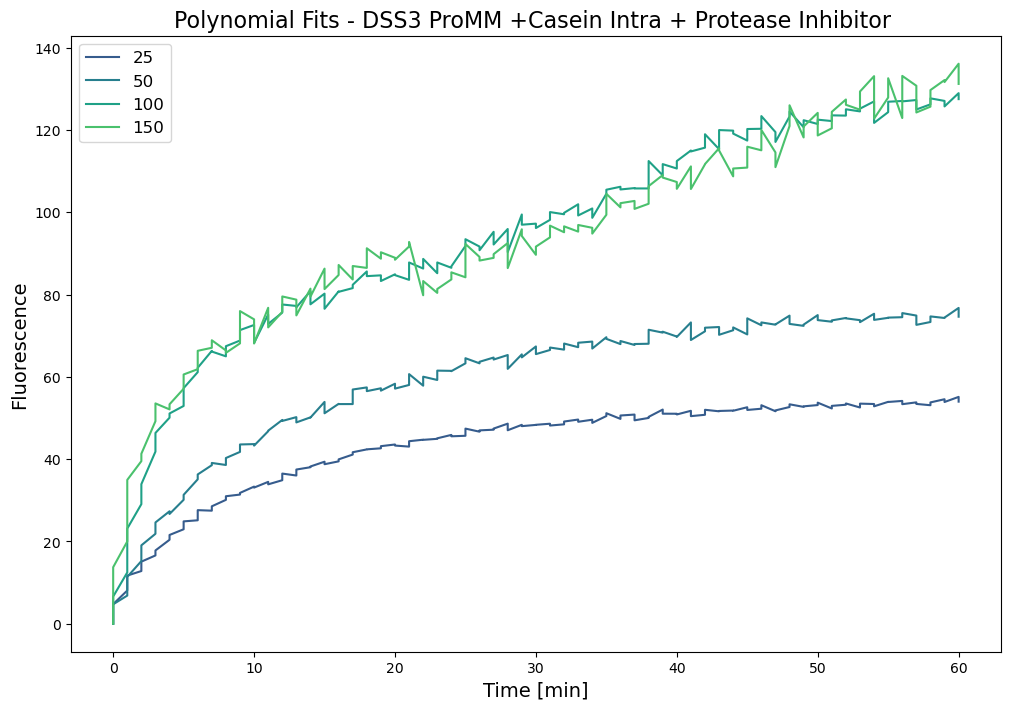

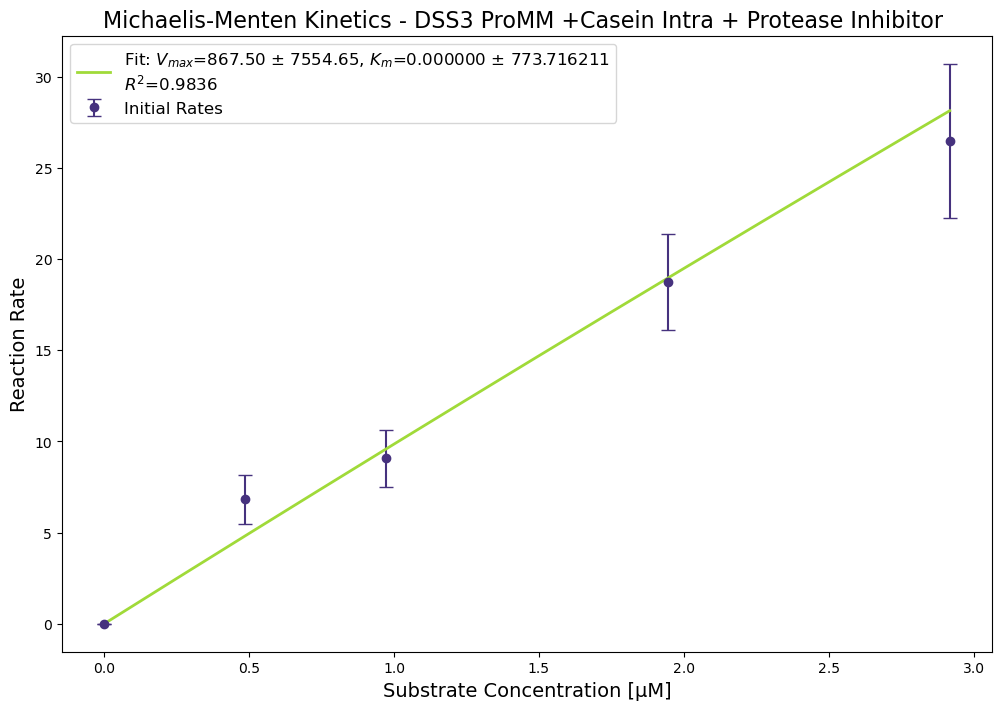

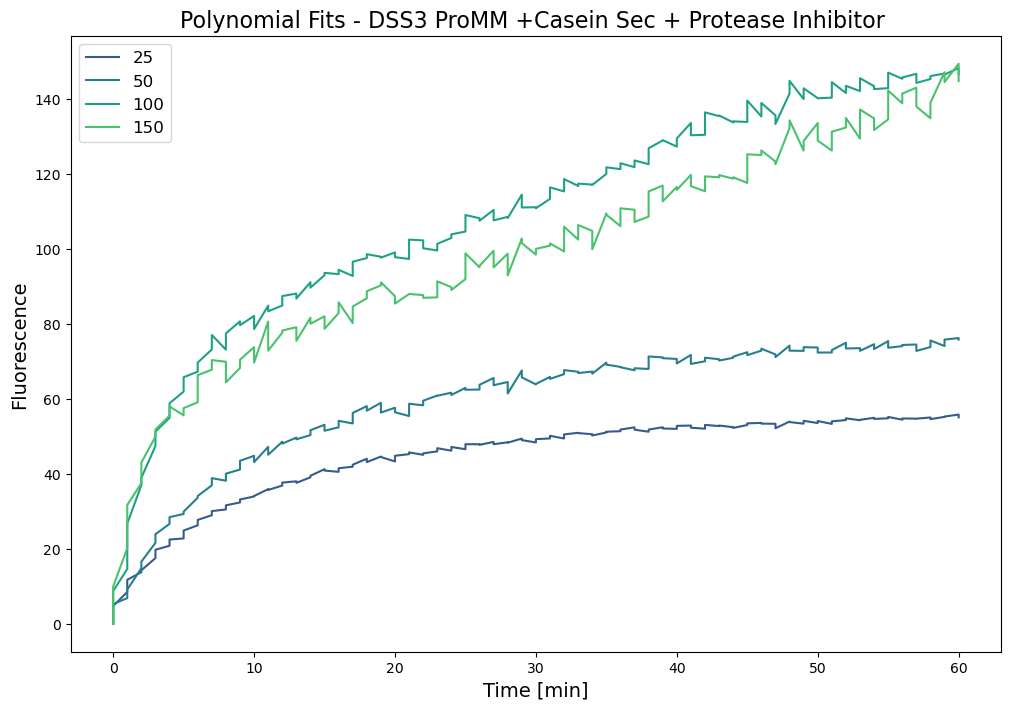

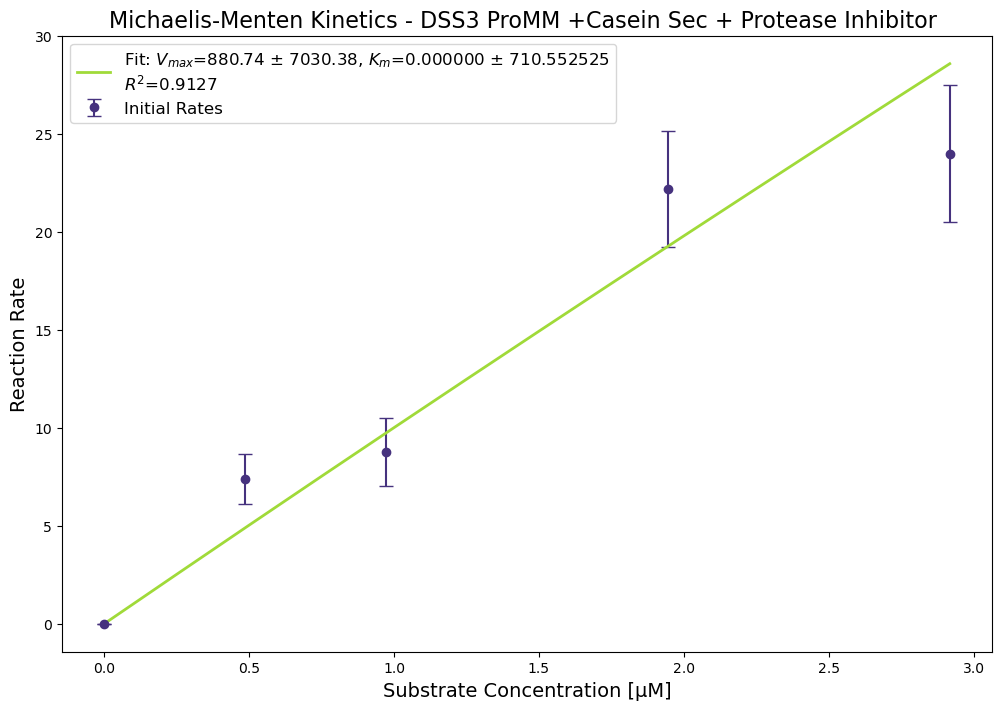

(880.7407985473535,
 6.786021397586772e-16,
 7030.382475524705,
 710.5525247965078,
 0.9126527521472694,
 array([ 0.        ,  7.40479933,  8.74086473, 22.18019204, 23.99523369]),
 array([1.00000000e-06, 1.27568638e+00, 1.73491720e+00, 2.95776934e+00,
        3.49279961e+00]))

In [17]:
include_mask = [True, True, True, True, False]
#michaelis_menten_poly(ACD_Intra, substrate_concentrations=substrate_concs, protein_name='DSS3 ACD Intra', filename = '../GENERALS/MMKinetics_DSS3_ACD_Intra.pdf')
#michaelis_menten_poly(ACD_Sec, substrate_concentrations=substrate_concs, protein_name='DSS3 ACD Sec', filename = '../GENERALS/MMKinetics_DSS3_ACD_Sec.pdf')

#michaelis_menten_poly(ProMM_Intra, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM Intra', filename = '../GENERALS/MMKinetics_DSS3_ProMM_Intra.pdf')
#michaelis_menten_poly(ProMM_Sec, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM Sec', include_mask = include_mask, filename = '../GENERALS/MMKinetics_DSS3_ProMM_Sec.pdf')

michaelis_menten_poly(ProMM_NC_Intra, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM -N+C Intra', filename = '../../GENERALS/KINETICS/Inhibited/MMKinetics_DSS3_ProMM-N+C_Intra.pdf')
michaelis_menten_poly(ProMM_NC_Sec, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM -N+C Sec', filename = '../../GENERALS/KINETICS/Inhibited/MMKinetics_DSS3_ProMM-N+C_Sec.pdf')
michaelis_menten_poly(ProMM_NC_Intra_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM -N+C Intra + Protease Inhibitor', filename = '../../GENERALS/KINETICS/Inhibited/MMKinetics_DSS3_ProMM-N+C_Intra_PI.pdf')
michaelis_menten_poly(ProMM_NC_Sec_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM -N+C Sec  Protease Inhibitor', filename = '../../GENERALS/KINETICS/Inhibited/MMKinetics_DSS3_ProMM-N+C_Sec_PI.pdf')

michaelis_menten_poly(ProMM_Cas_Intra, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM +Casein Intra', filename = '../../GENERALS/KINETICS/Inhibited/MMKinetics_DSS3_ProMM++_Intra.pdf')
michaelis_menten_poly(ProMM_Cas_Sec, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM +Casein Sec', filename = '../../GENERALS/KINETICS/Inhibited/MMKinetics_DSS3_ProMM++_Sec.pdf')
michaelis_menten_poly(ProMM_Cas_Intra_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM +Casein Intra + Protease Inhibitor', filename = '../../GENERALS/KINETICS/Inhibited/MMKinetics_DSS3_ProMM++_Intra_PI.pdf')
michaelis_menten_poly(ProMM_Cas_Sec_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM +Casein Sec + Protease Inhibitor', filename = '../../GENERALS/KINETICS/Inhibited/MMKinetics_DSS3_ProMM++_Sec_PI.pdf')

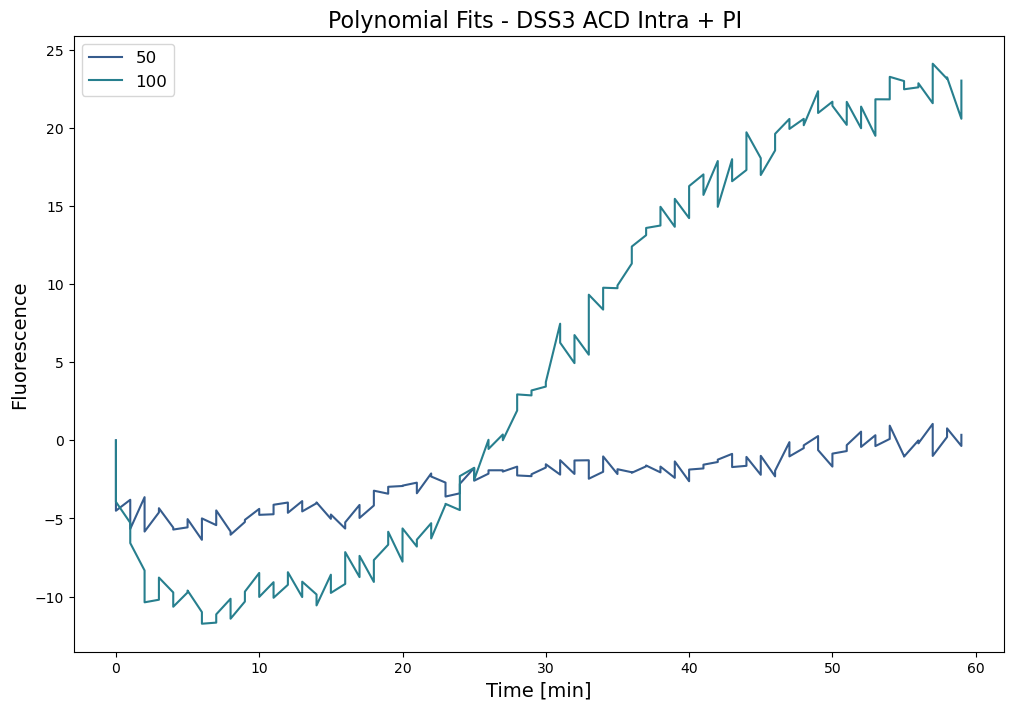

/var/folders/hb/hntvhz5j0j15vb_5h21tbhph0000gn/T/ipykernel_24675/2933916837.py:136: RuntimeWarning: divide by zero encountered in scalar divide
  adj_R2 = 1 - (1 - R2) * (n - 1) / (n - p - 1)


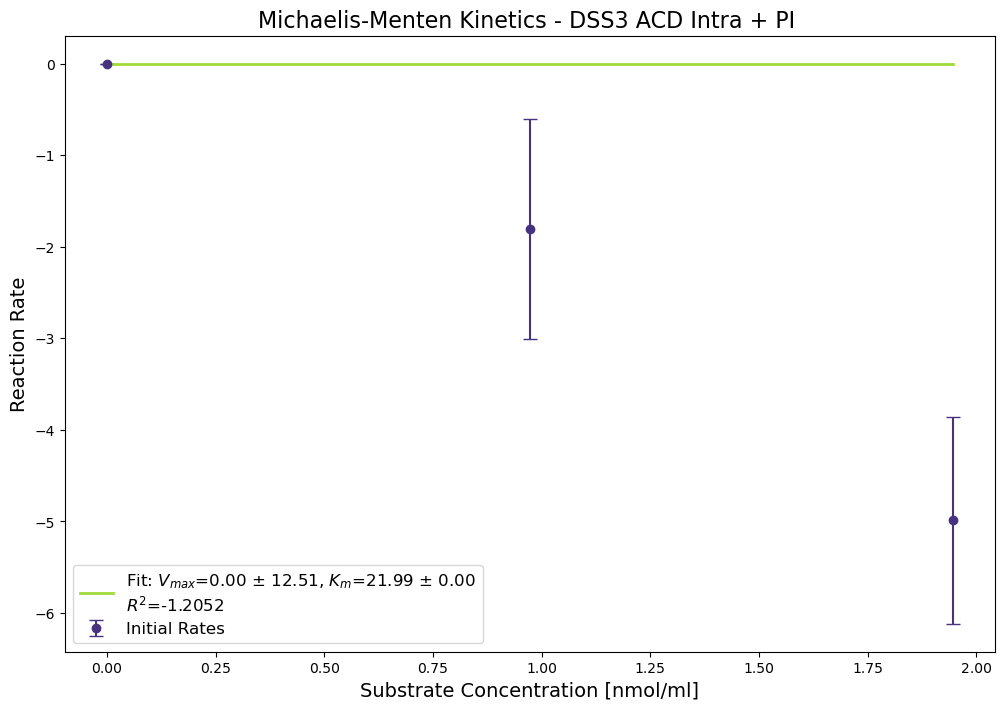

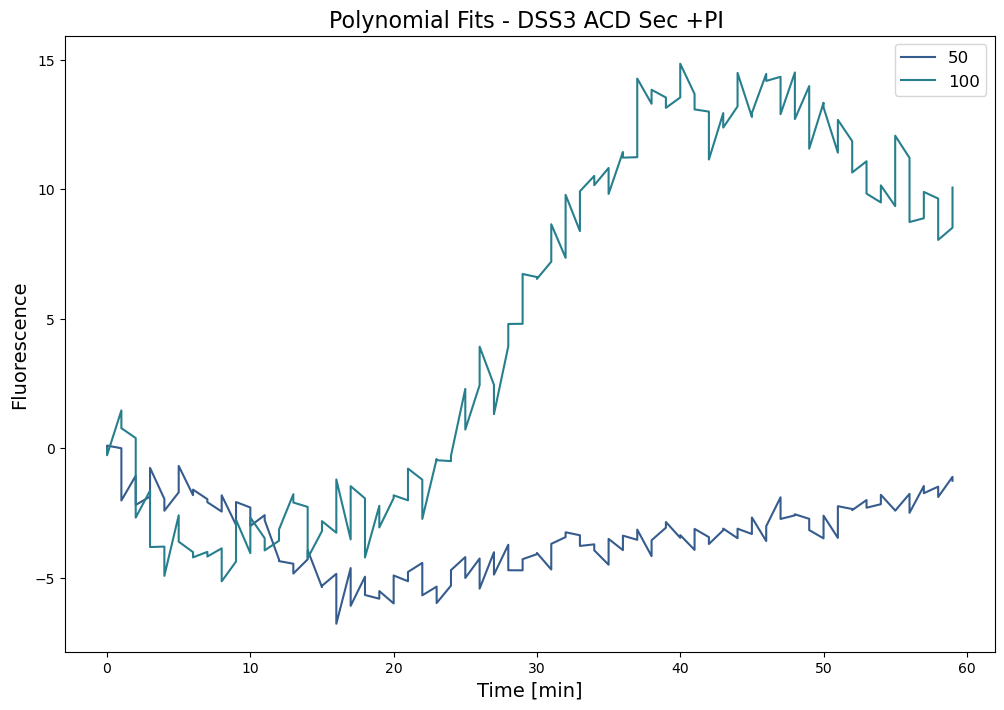

/var/folders/hb/hntvhz5j0j15vb_5h21tbhph0000gn/T/ipykernel_24675/2933916837.py:136: RuntimeWarning: divide by zero encountered in scalar divide
  adj_R2 = 1 - (1 - R2) * (n - 1) / (n - p - 1)


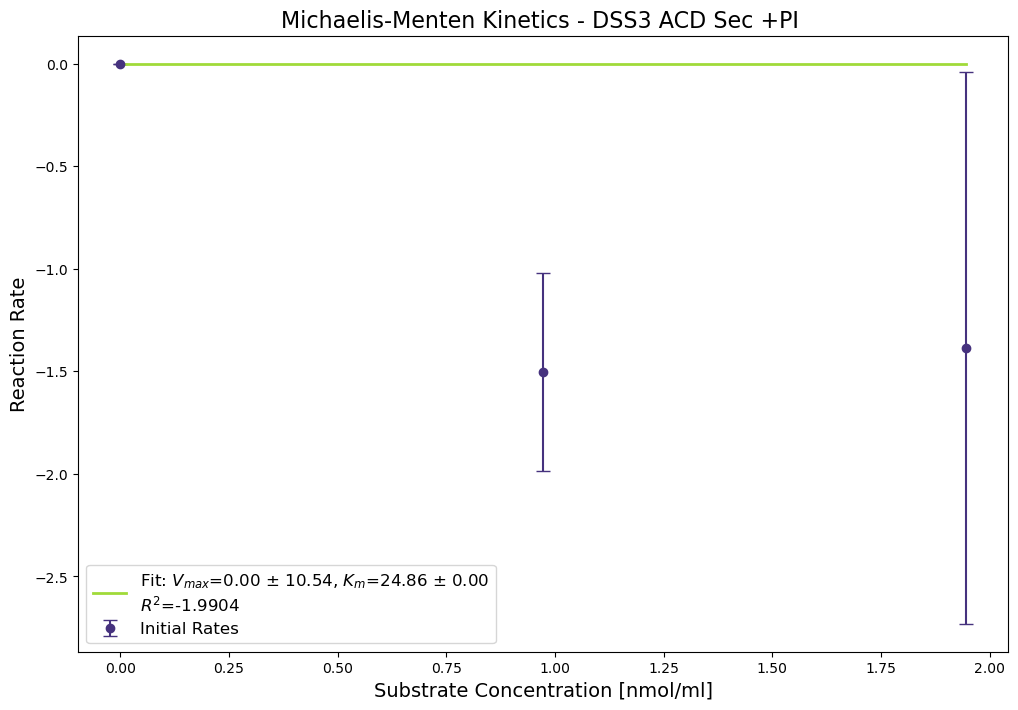

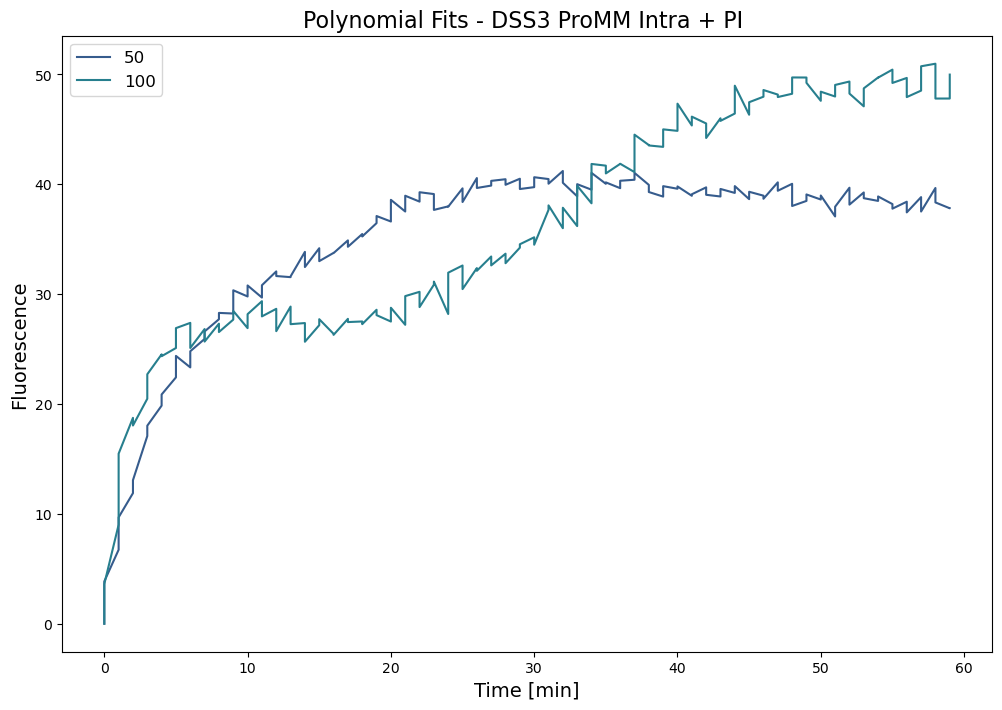

/var/folders/hb/hntvhz5j0j15vb_5h21tbhph0000gn/T/ipykernel_24675/2933916837.py:136: RuntimeWarning: invalid value encountered in scalar divide
  adj_R2 = 1 - (1 - R2) * (n - 1) / (n - p - 1)


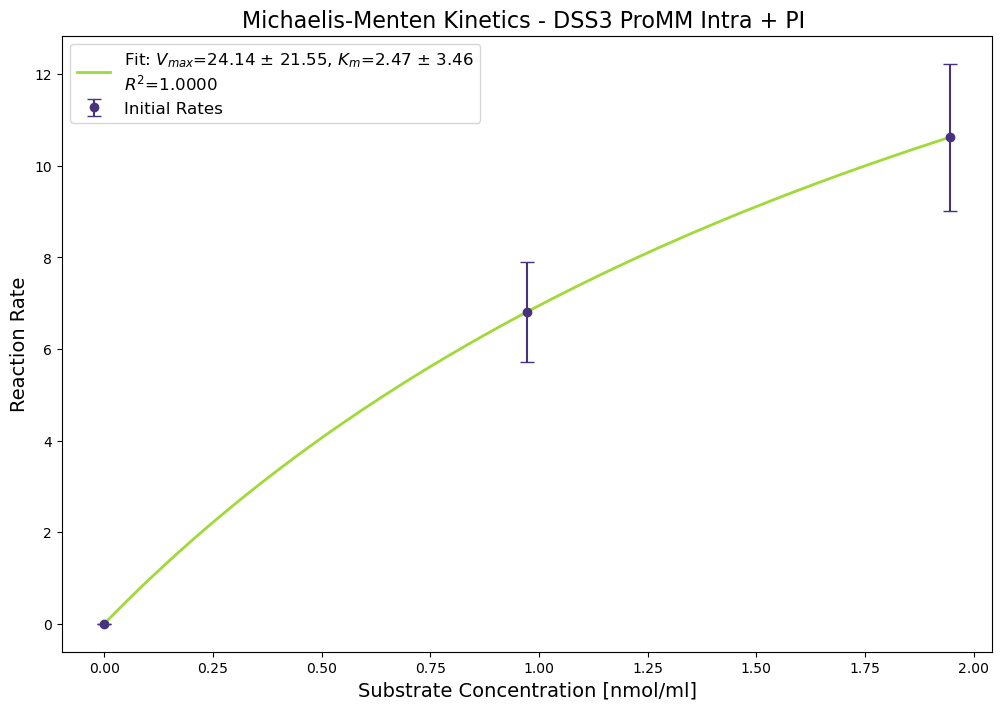

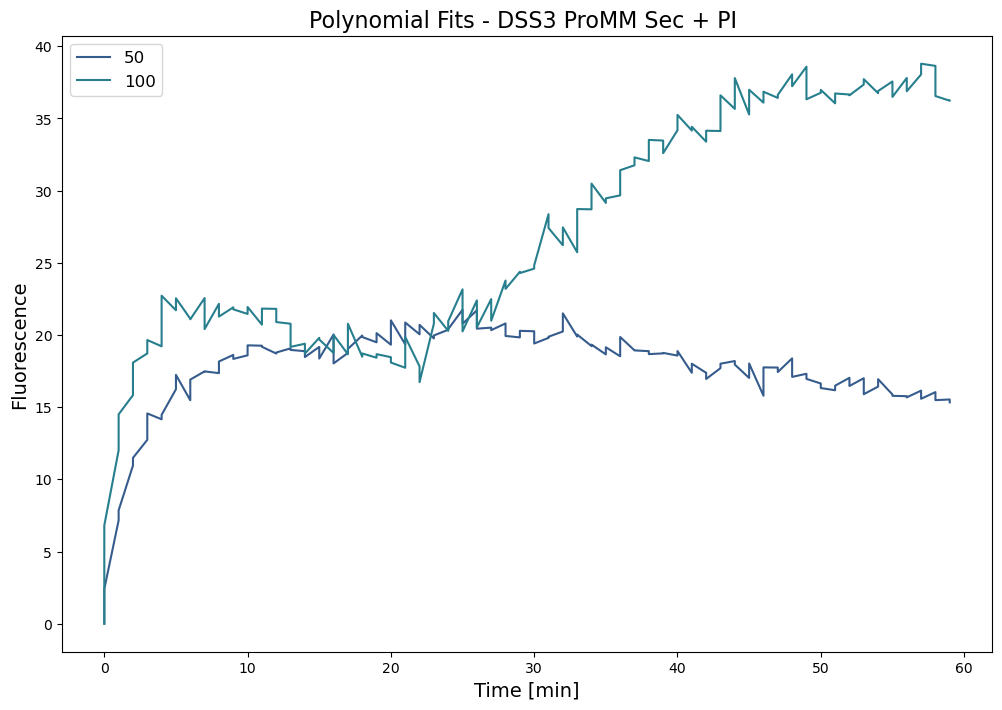

/var/folders/hb/hntvhz5j0j15vb_5h21tbhph0000gn/T/ipykernel_24675/2933916837.py:136: RuntimeWarning: invalid value encountered in scalar divide
  adj_R2 = 1 - (1 - R2) * (n - 1) / (n - p - 1)


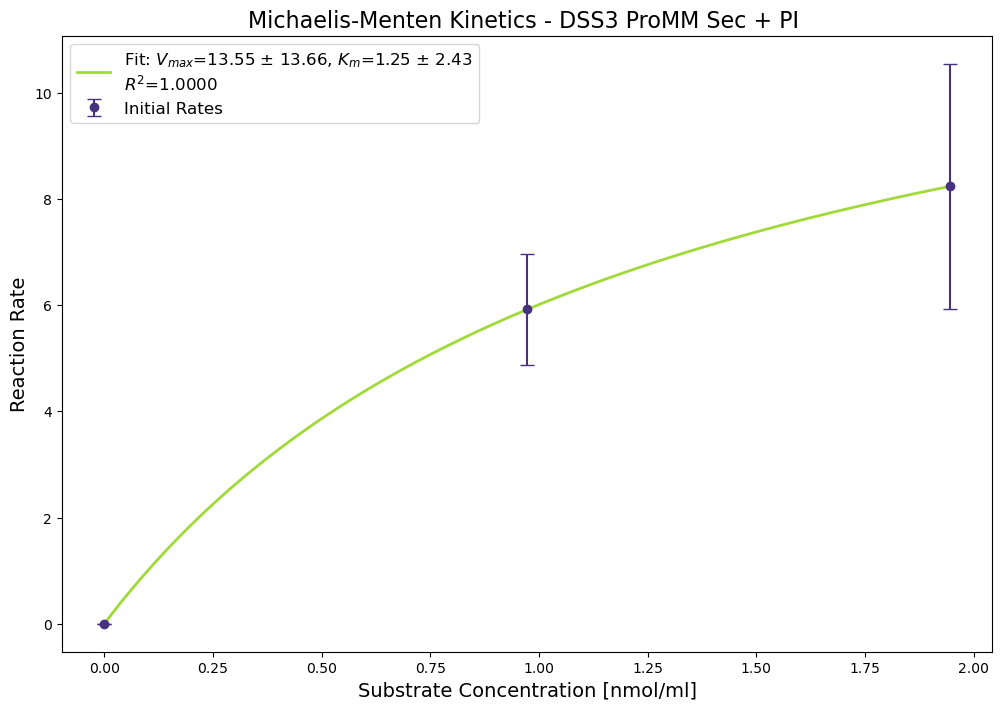

(np.float64(13.54840352658755),
 np.float64(1.2536792967883523),
 np.float64(13.659555897372947),
 np.float64(2.430831390398444),
 np.float64(1.0),
 array([0.        , 5.92029425, 8.23828912]),
 array([1.00000000e-06, 1.04918648e+00, 2.31028398e+00]))

In [6]:
michaelis_menten_poly_PI(ACD_Intra_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ACD Intra + PI', filename = '../GENERALS/MICHAELIS_MENTEN/MMKinetics_DSS3_ACD_Intra_PI.pdf')
michaelis_menten_poly_PI(ACD_Sec_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ACD Sec +PI', filename = '../GENERALS/MICHAELIS_MENTEN/MMKinetics_DSS3_ACD_Sec_PI.pdf')

michaelis_menten_poly_PI(ProMM_Intra_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM Intra + PI', filename = '../GENERALS/MICHAELIS_MENTEN/MMKinetics_DSS3_ProMM_Intra_PI.pdf')
michaelis_menten_poly_PI(ProMM_Sec_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM Sec + PI', filename = '../GENERALS/MICHAELIS_MENTEN/MMKinetics_DSS3_ProMM_Sec_PI.pdf')


In [8]:
def enzyme_kinetics_lineweaver_burk(blank_corr_data, substrate_concentrations, protein_name='', title='', filename='', include_mask=None, n_bootstrap=10000):
    """
    Extracts enzyme kinetics using initial rates from 9th-degree polynomial slopes.
    Fits the rates using a Lineweaver-Burk plot (double reciprocal) and estimates errors for Vmax and Km.

    Parameters:
        - blank_corr_data: DataFrame with fluorescence data and 'Time' column
        - substrate_concentrations: List of substrate concentrations (nmol/ml)
        - protein_name: Name of the protein for the title
        - title: Additional plot title
        - filename: Output filename for saving the plot
        - include_mask: Mask for excluding outliers (optional)
        - n_bootstrap: Number of bootstrap samples

    Returns:
        - Vmax, Vmax_err, Km, Km_err, R2, initial_rates, initial_rate_errors
    """

    def timetomin(time_str):
        """Convert time string to minutes."""
        h, m, s = map(int, time_str.split(':'))
        return h * 60 + m

    time = blank_corr_data['Time'].apply(timetomin)

    # Extract initial rates using 9th-degree polynomial fit
    initial_rates = []
    initial_rate_errors = []

    plt.figure(figsize=(12, 8))
    colors = sns.color_palette("viridis")

    for i, col in enumerate(blank_corr_data.columns):
        if col != 'Time' and 'Std' not in col:
            substrate_curve = blank_corr_data[col]

            # Filter data to ≤ 60 minutes for polynomial fitting
            mask = time <= 60
            time_filtered = time[mask].values
            substrate_filtered = substrate_curve[mask].values

            # Normalize the data to start at 0 fluorescence
            substrate = substrate_filtered - substrate_filtered[0]

            if len(time_filtered) > 9:
                # Bootstrap resampling
                slopes = []

                for _ in range(n_bootstrap):
                    boot_indices = np.random.choice(len(time_filtered), len(time_filtered), replace=True)
                    boot_time = time_filtered[boot_indices]
                    boot_substrate = substrate_filtered[boot_indices]

                    # Fit 9th-degree polynomial
                    poly_coeff = np.polyfit(boot_time, boot_substrate, 9)
                    poly_derivative_coeff = np.polyder(poly_coeff)

                    # Get the slope at time=0
                    initial_slope = np.polyval(poly_derivative_coeff, 0)
                    slopes.append(initial_slope)

                # Mean and standard deviation of slopes
                mean_slope = np.mean(slopes)
                std_slope = np.std(slopes)

                initial_rates.append(mean_slope)
                initial_rate_errors.append(std_slope)

                # Plot the individual fluorescence curves
                plt.plot(time_filtered, substrate, label=f"{col}", color=colors[i])
            else:
                initial_rates.append(np.nan)
                initial_rate_errors.append(np.nan)

    plt.title(f'Polynomial Fits - {protein_name} {title}', fontsize=16)
    plt.xlabel('Time [min]', fontsize=14)
    plt.ylabel('Fluorescence', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.show()

    # Prepare data for Lineweaver-Burk transformation
    initial_rates = np.array(initial_rates)
    initial_rate_errors = np.array(initial_rate_errors)
    substrate_concentrations = np.array(substrate_concentrations)

    # Add the point (0, 0) to enforce the curve passes through the origin
    initial_rates = np.insert(initial_rates, 0, 0)
    initial_rate_errors = np.insert(initial_rate_errors, 0, 1e-6)
    substrate_concentrations = np.insert(substrate_concentrations, 0, 0)

    # Apply mask if provided
    if include_mask is not None:
        initial_rates = initial_rates[include_mask]
        initial_rate_errors = initial_rate_errors[include_mask]
        substrate_concentrations = np.array(substrate_concentrations)[include_mask]

    # Lineweaver-Burk Transformation
    with np.errstate(divide='ignore', invalid='ignore'):
        x_data = 1 / substrate_concentrations[1:]   # Avoid divide by zero for [0, 0] point
        y_data = 1 / initial_rates[1:]

    yerr = initial_rate_errors[1:] / (initial_rates[1:]**2)

    # Linear regression
    slope, intercept, r_value, p_value, slope_std_err = linregress(x_data, y_data)

    # Estimate intercept standard error
    n = len(x_data)
    mean_x = np.mean(x_data)
    Sxx = np.sum((x_data - mean_x)**2)
    residuals = y_data - (slope * x_data + intercept)
    res_var = np.sum(residuals**2) / (n - 2)
    intercept_std_err = np.sqrt(res_var * (1/n + mean_x**2 / Sxx))

    # Calculate Vmax, Km
    Vmax = 1 / intercept
    Km = slope * Vmax

    # Error propagation
    Vmax_err = intercept_std_err / intercept**2
    Km_err = np.sqrt((Vmax**2 * slope_std_err**2) + (slope**2 * Vmax_err**2))

    # Plot Lineweaver-Burk
    plt.figure(figsize=(12, 8))
    
    # Plot the Lineweaver-Burk points
    plt.errorbar(x_data, y_data, yerr=yerr, fmt='o', color=colors[0], label='Lineweaver-Burk Data', capsize=5)
    
    # Plot the fitted line
    x_fit = np.linspace(min(x_data), max(x_data), 200)
    y_fit = slope * x_fit + intercept
    plt.plot(x_fit, y_fit, label=f'Fit: $V_{{max}}$={Vmax:.2f} ± {Vmax_err:.2f}, $K_m$={Km:.2f} ± {Km_err:.2f}\n$R^2$={r_value**2:.2f}', 
             color=colors[-1], linewidth=2)

    # Plot settings
    plt.title(f'Lineweaver-Burk Plot - {protein_name} {title}', fontsize=16)
    plt.xlabel(r'$1/[S]$ (nmol/ml)$^{-1}$', fontsize=14)
    plt.ylabel(r'$1/v$ (rate)$^{-1}$', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    #if filename: 
        #plt.savefig(filename, format='pdf')
    plt.show()

    # Return fit parameters and statistics
    return Vmax, Vmax_err, Km, Km_err, r_value**2, initial_rates, initial_rate_errors

substrate_concs = [0.486, 0.973, 1.945, 2.918]  # nmol/ml or µmol/l



In [35]:

def enzyme_kinetics_competitive_inhibition(blank_corr_data, substrate_concentrations, protein_name='', title='', filename='', include_mask=None, n_bootstrap=10000):
    """
    Extracts enzyme kinetics using initial rates from 9th-degree polynomial slopes.
    Applies competitive inhibition Lineweaver-Burk analysis assuming constant inhibitor [I] and Ki = Km.

    Parameters:
        - blank_corr_data: DataFrame with fluorescence data and 'Time' column
        - substrate_concentrations: List of substrate concentrations (nmol/ml)
        - protein_name: Name of the protein for the title
        - title: Additional plot title
        - filename: Output filename for saving the plot
        - include_mask: Mask for excluding outliers (optional)
        - n_bootstrap: Number of bootstrap samples

    Returns:
        - Vmax, Vmax_err, Km, Km_err, R2, initial_rates, initial_rate_errors
    """

    def timetomin(time_str):
        h, m, s = map(int, time_str.split(':'))
        return h * 60 + m

    time = blank_corr_data['Time'].apply(timetomin)

    # Extract initial rates using 9th-degree polynomial fit
    initial_rates = []
    initial_rate_errors = []

    plt.figure(figsize=(12, 8))
    colors = sns.color_palette("viridis")

    for i, col in enumerate(blank_corr_data.columns):
        if col != 'Time' and 'Std' not in col:
            substrate_curve = blank_corr_data[col]
            mask = time <= 60
            time_filtered = time[mask].values
            substrate_filtered = substrate_curve[mask].values
            substrate = substrate_filtered - substrate_filtered[0]

            if len(time_filtered) > 9:
                slopes = []
                for _ in range(n_bootstrap):
                    boot_indices = np.random.choice(len(time_filtered), len(time_filtered), replace=True)
                    boot_time = time_filtered[boot_indices]
                    boot_substrate = substrate_filtered[boot_indices]
                    poly_coeff = np.polyfit(boot_time, boot_substrate, 9)
                    poly_derivative_coeff = np.polyder(poly_coeff)
                    initial_slope = np.polyval(poly_derivative_coeff, 0)
                    slopes.append(initial_slope)
                mean_slope = np.mean(slopes)
                std_slope = np.std(slopes)
                initial_rates.append(mean_slope)
                initial_rate_errors.append(std_slope)
                plt.plot(time_filtered, substrate, label=f"{col}", color=colors[i])
            else:
                initial_rates.append(np.nan)
                initial_rate_errors.append(np.nan)

    plt.title(f'Polynomial Fits - {protein_name} {title}', fontsize=16)
    plt.xlabel('Time [min]', fontsize=14)
    plt.ylabel('Fluorescence', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.show()

    # Prepare Lineweaver-Burk data
    initial_rates = np.array(initial_rates)
    initial_rate_errors = np.array(initial_rate_errors)
    substrate_concentrations = np.array(substrate_concentrations)

    initial_rates = np.insert(initial_rates, 0, 0)
    initial_rate_errors = np.insert(initial_rate_errors, 0, 1e-6)
    substrate_concentrations = np.insert(substrate_concentrations, 0, 0)

    if include_mask is not None:
        initial_rates = initial_rates[include_mask]
        initial_rate_errors = initial_rate_errors[include_mask]
        substrate_concentrations = np.array(substrate_concentrations)[include_mask]

    with np.errstate(divide='ignore', invalid='ignore'):
        x_data = 1 / substrate_concentrations[1:]
        y_data = 1 / initial_rates[1:]

    yerr = initial_rate_errors[1:] / (initial_rates[1:]**2)

    # Linear regression
    slope, intercept, r_value, p_value, slope_std_err = linregress(x_data, y_data)

    # Error in intercept
    n = len(x_data)
    mean_x = np.mean(x_data)
    Sxx = np.sum((x_data - mean_x)**2)
    residuals = y_data - (slope * x_data + intercept)
    res_var = np.sum(residuals**2) / (n - 2)
    intercept_std_err = np.sqrt(res_var * (1/n + mean_x**2 / Sxx))

    # Vmax
    Vmax = 1 / intercept
    Vmax_err = intercept_std_err / intercept**2

    # Competitive inhibition adjustment: Ki = Km, Km = slope * Vmax - [I]
    inhibitor_conc = 0.087  # µmol/ml = 87 µM
    Km_app = slope * Vmax
    Km = Km_app - inhibitor_conc

    # Error in Km
    Km_app_err = np.sqrt((Vmax**2 * slope_std_err**2) + (slope**2 * Vmax_err**2))
    Km_err = Km_app_err  # No error in constant inhibitor assumed

    # Plot Lineweaver-Burk
    plt.figure(figsize=(12, 8))
    plt.errorbar(x_data, y_data, yerr=yerr, fmt='o', color=colors[0], label='Lineweaver-Burk Data', capsize=5)
    x_fit = np.linspace(min(x_data), max(x_data), 200)
    y_fit = slope * x_fit + intercept
    plt.plot(x_fit, y_fit,
             label=f'Fit: $V_{{max}}$={Vmax:.2f} ± {Vmax_err:.2f}, $K_m$={Km:.2f} ± {Km_err:.2f}\n$R^2$={r_value**2:.2f}',
             color=colors[-1], linewidth=2)

    plt.title(f'Lineweaver-Burk Plot - {protein_name} {title}', fontsize=16)
    plt.xlabel(r'$1/[S]$ (nmol/ml)$^{-1}$', fontsize=14)
    plt.ylabel(r'$1/v$ (rate)$^{-1}$', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.show()

    return Vmax, Vmax_err, Km, Km_err, r_value**2, initial_rates, initial_rate_errors


substrate_concs = [0.486, 0.973, 1.945, 2.918]  # nmol/ml or µmol/l


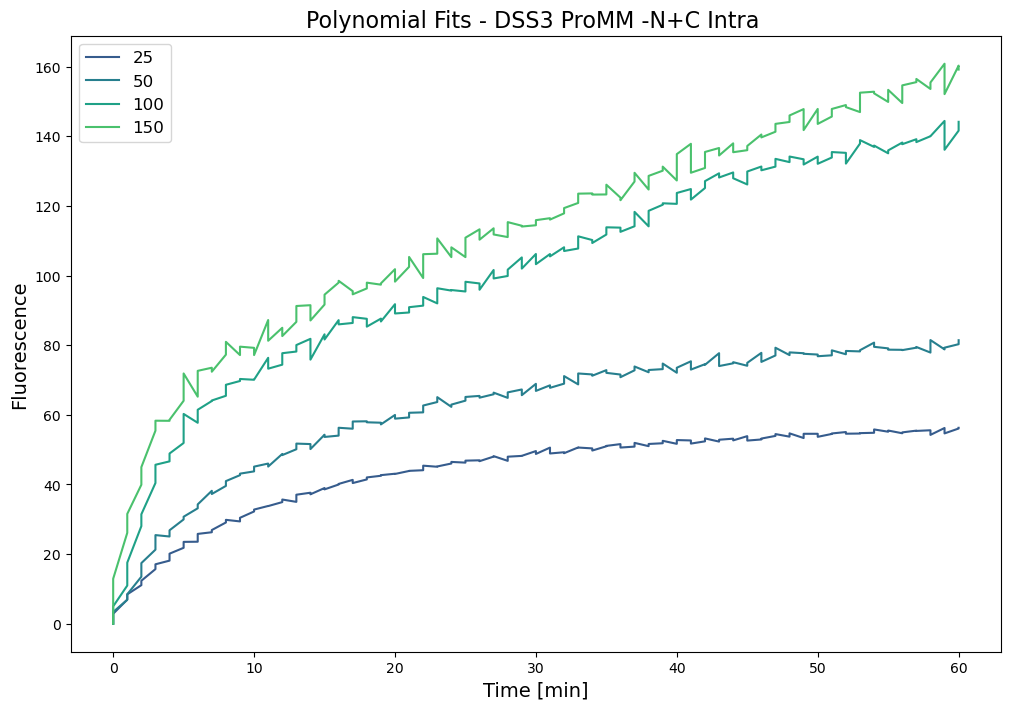

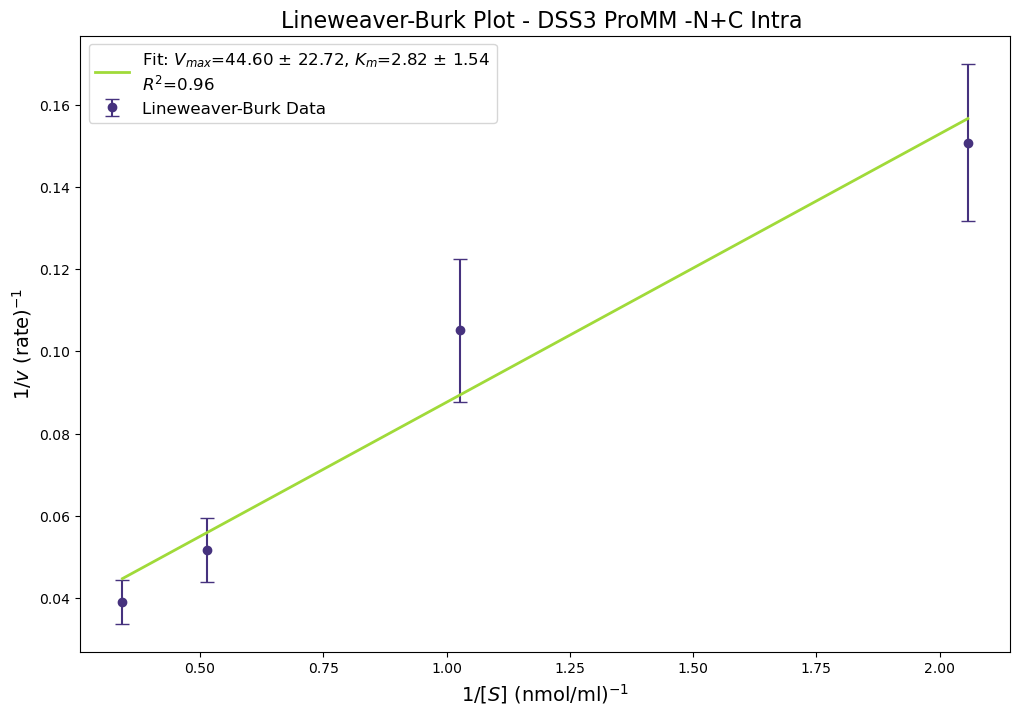

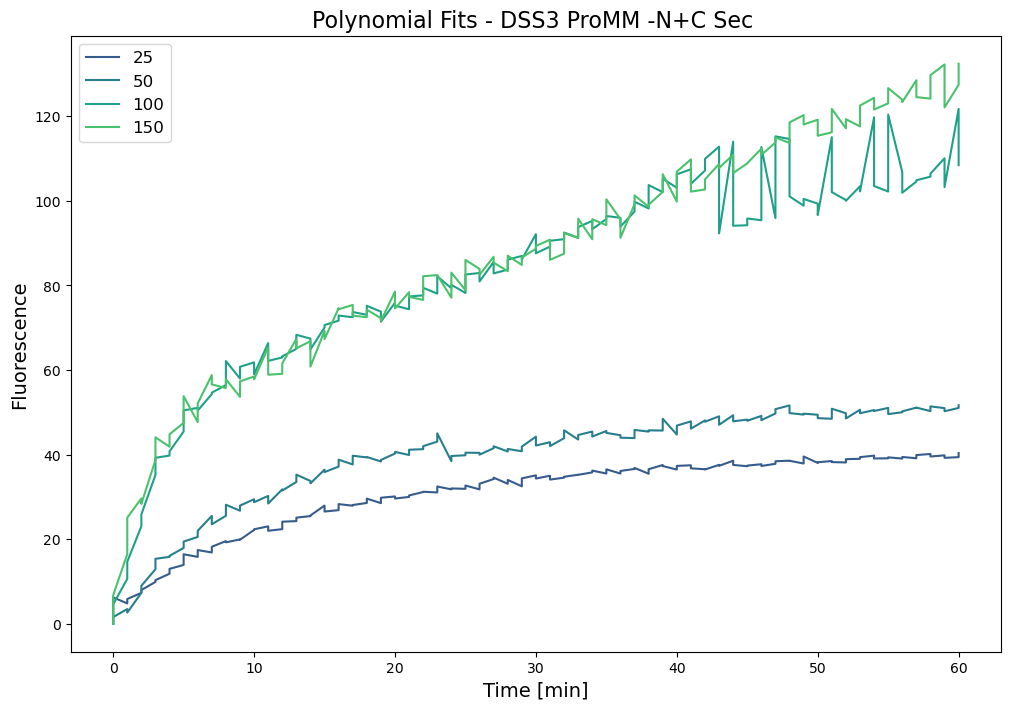

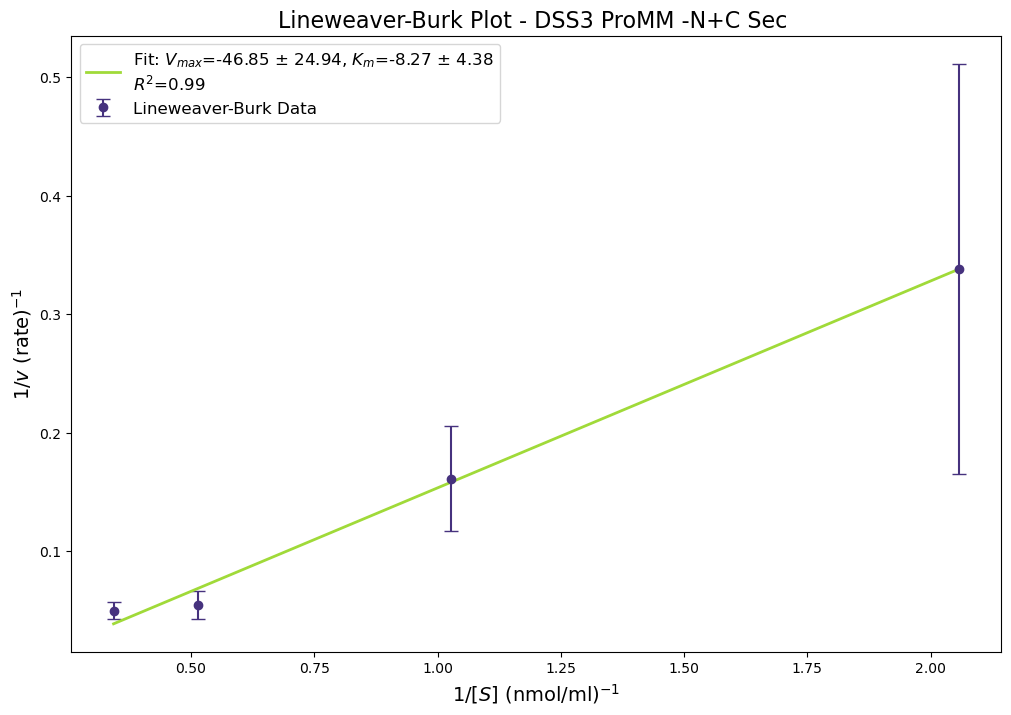

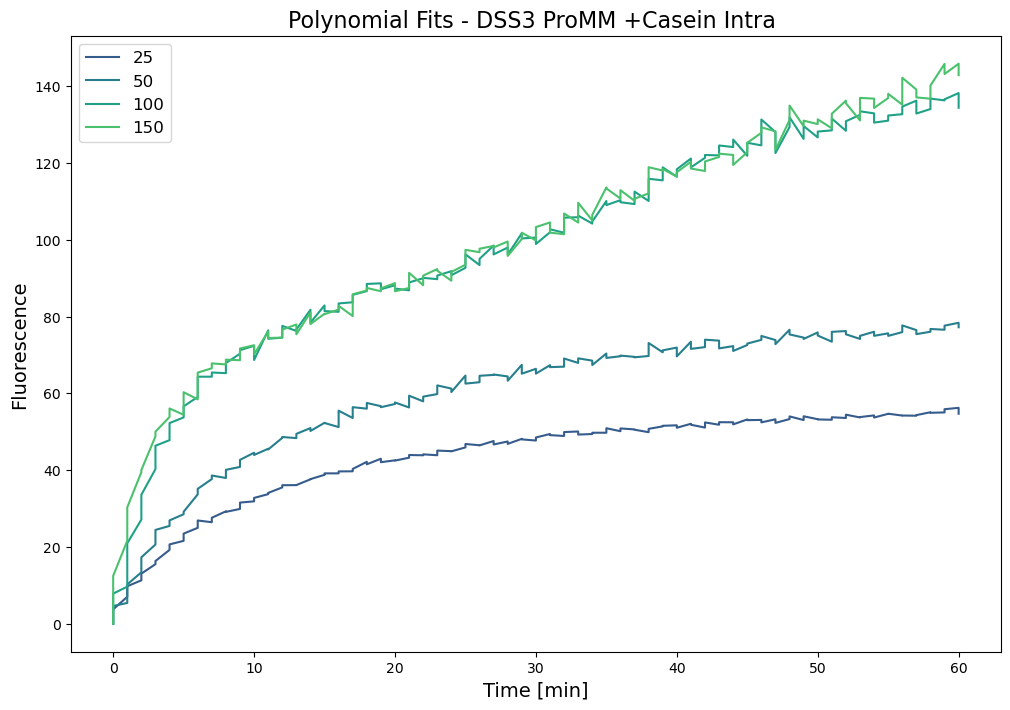

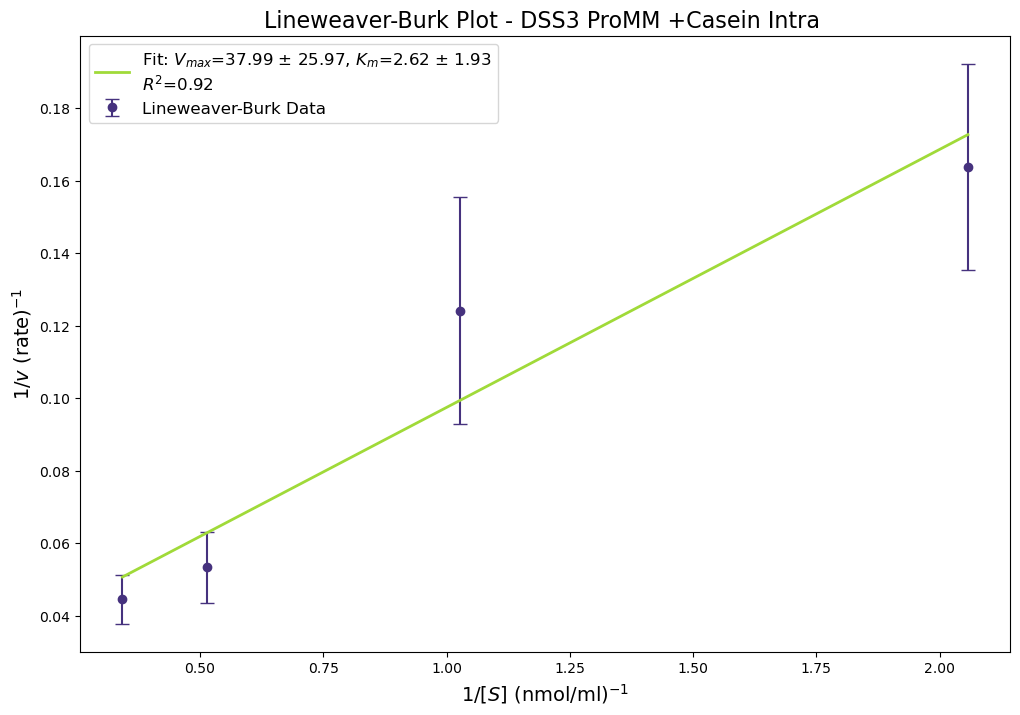

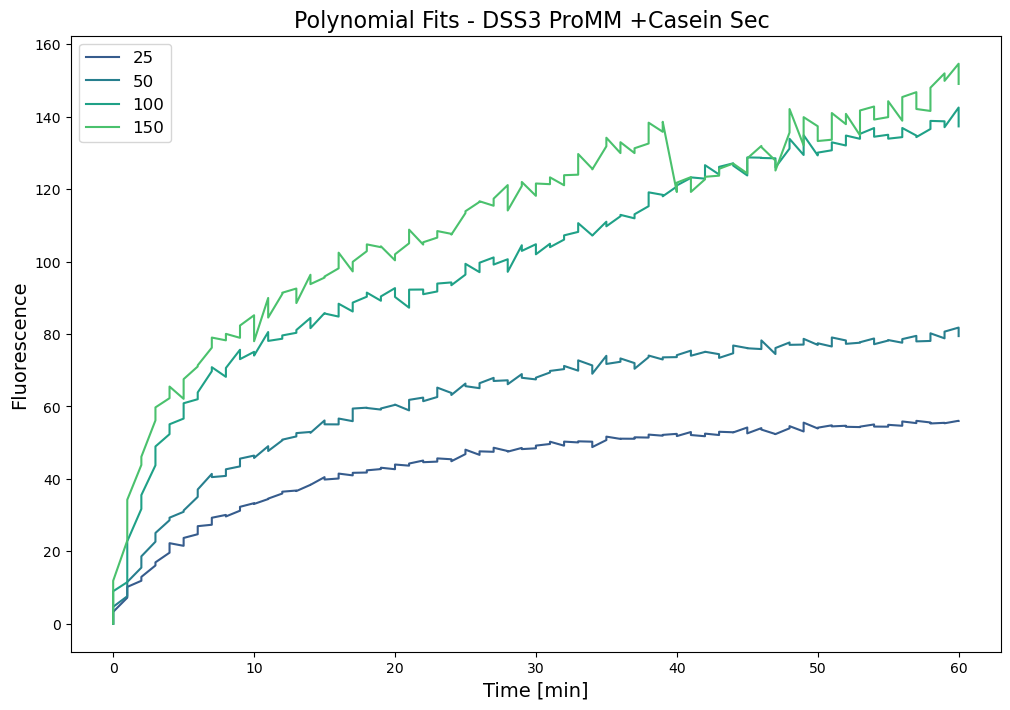

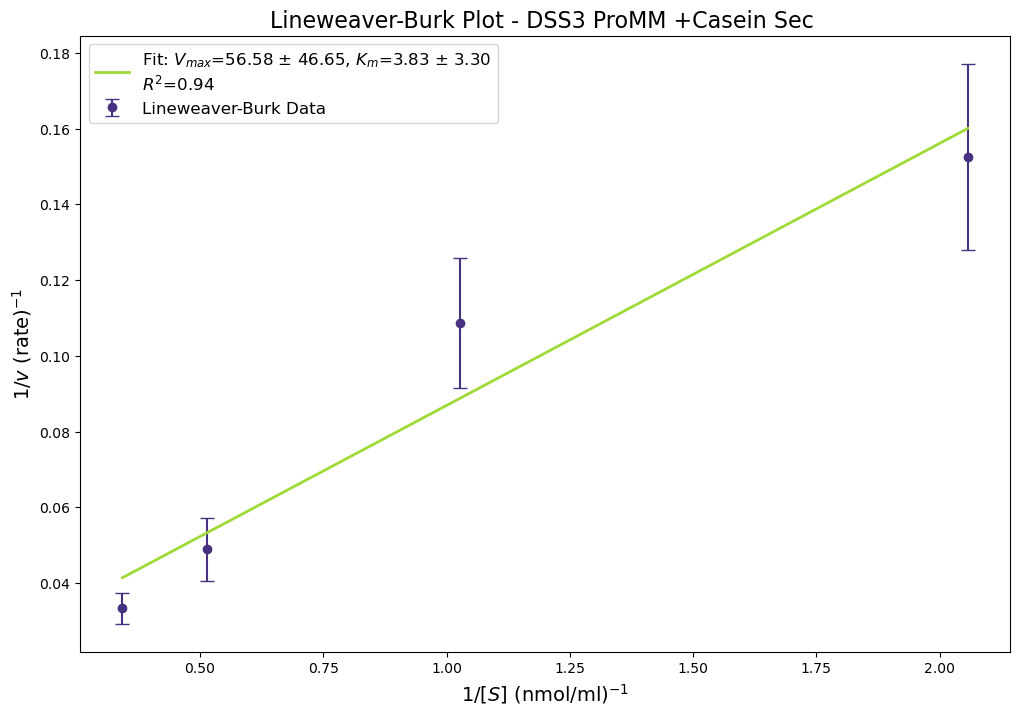

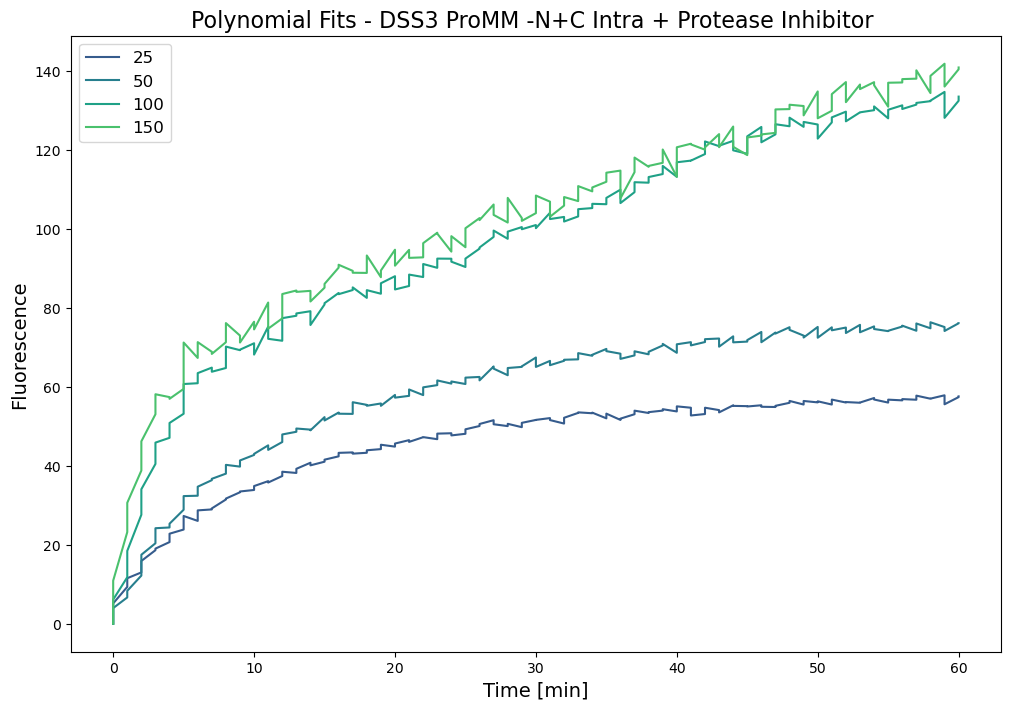

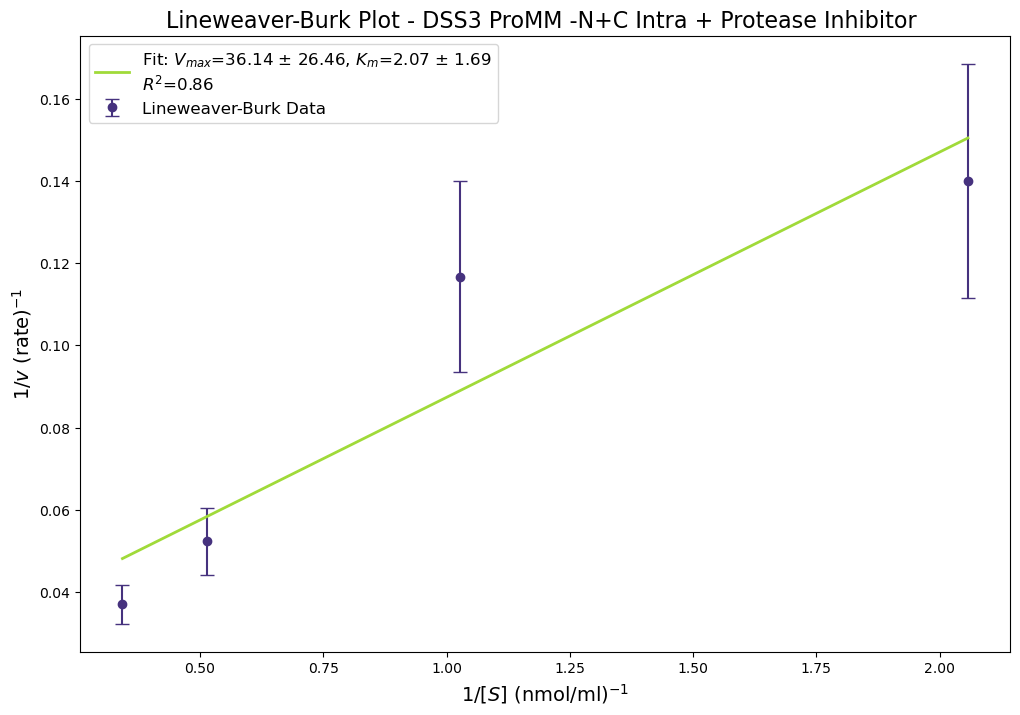

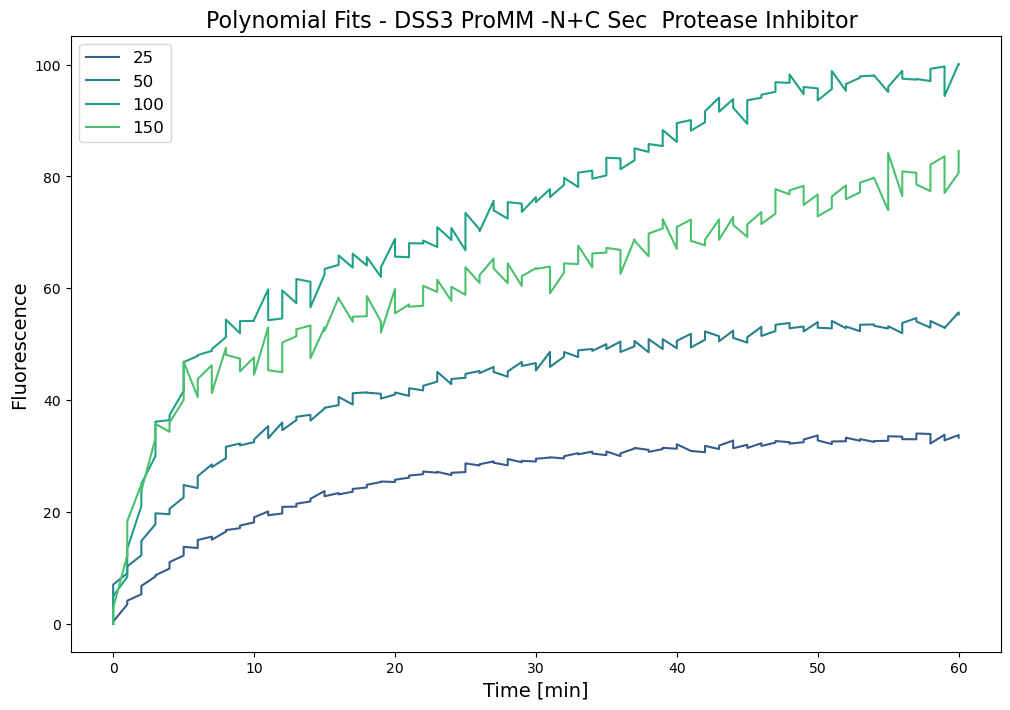

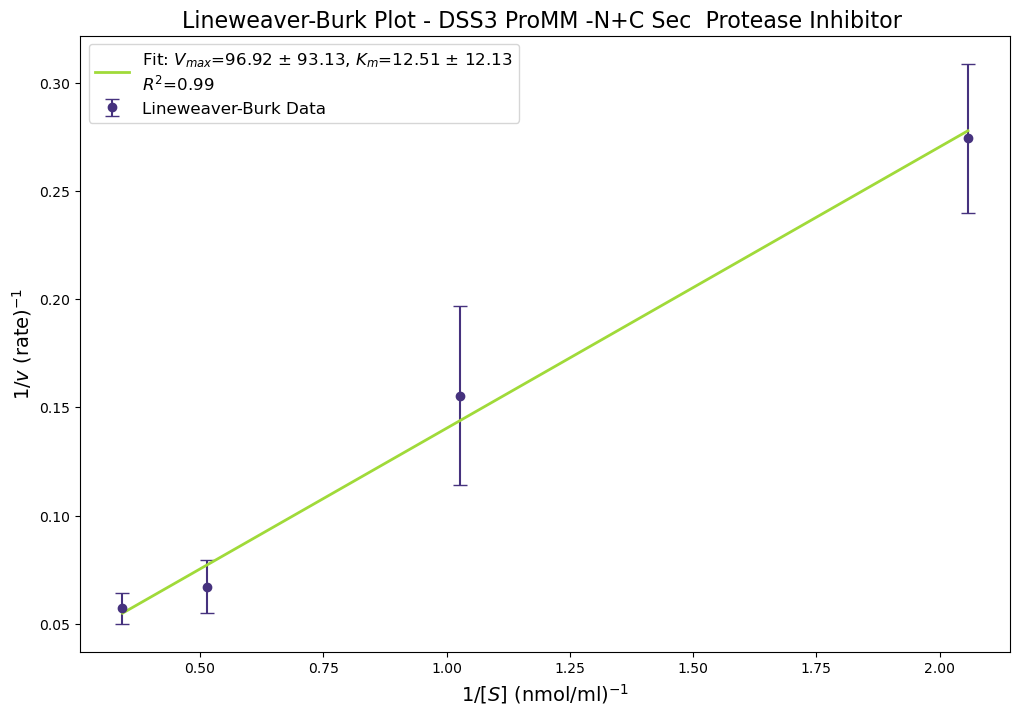

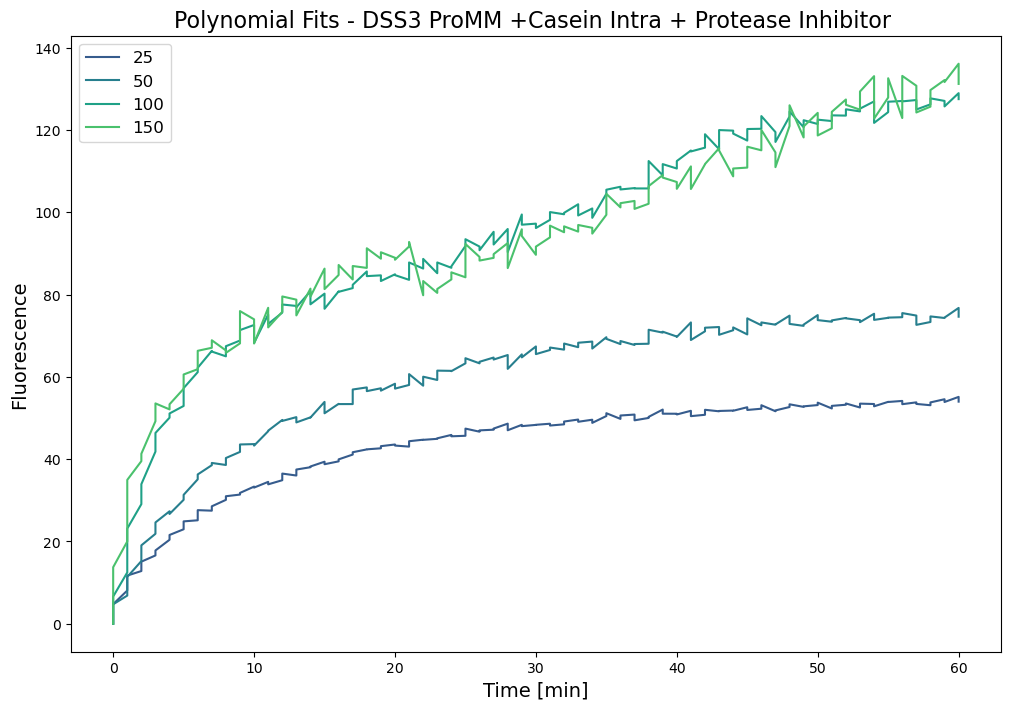

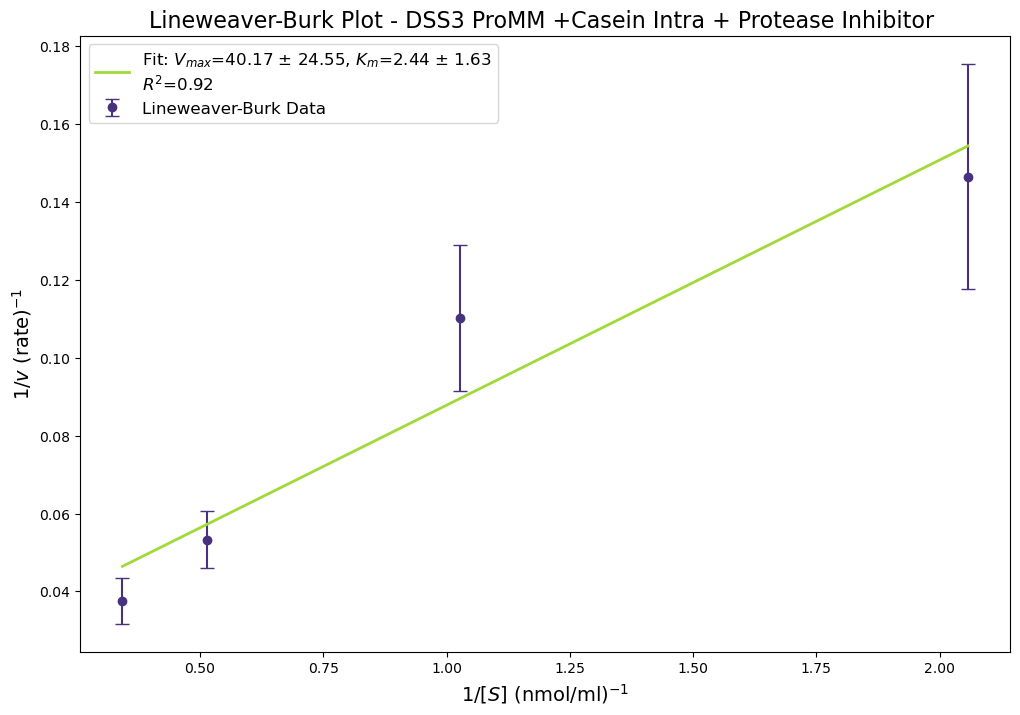

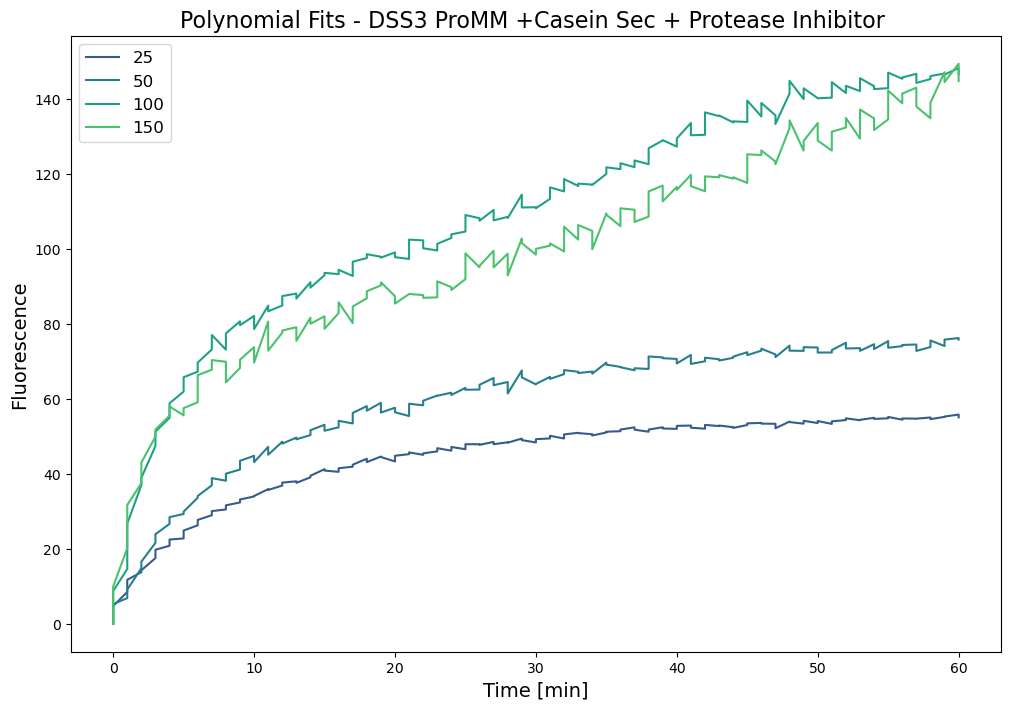

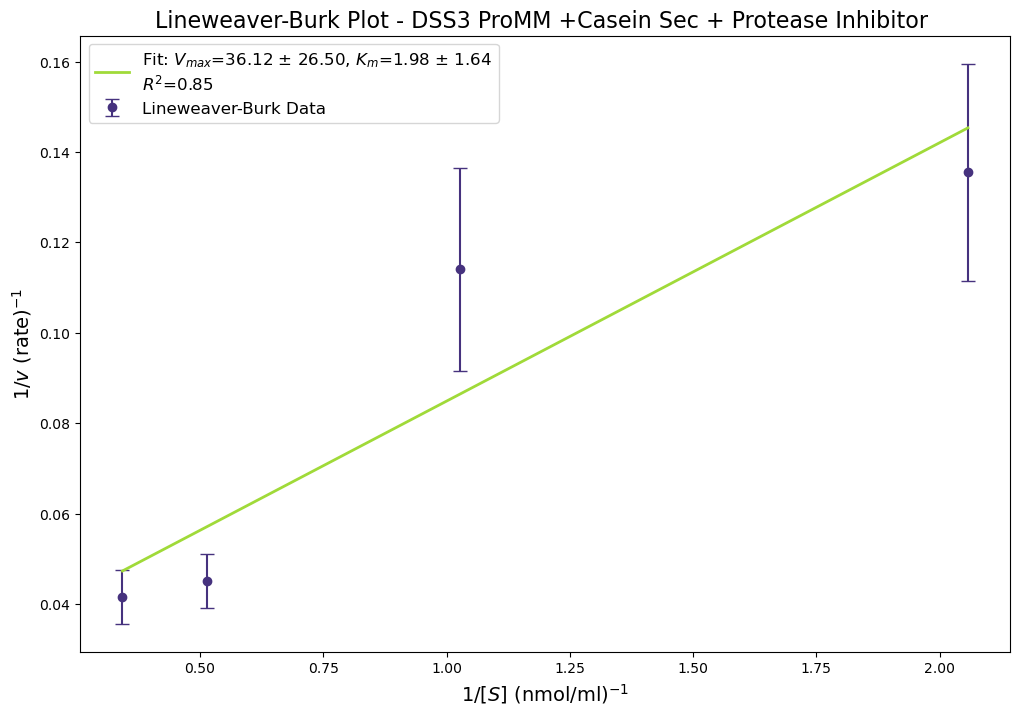

(36.121640836613814,
 26.499963851790316,
 1.9786793482449399,
 1.635894313468893,
 0.848962245687192,
 array([ 0.        ,  7.37947209,  8.76374829, 22.19755441, 24.08990039]),
 array([1.00000000e-06, 1.30817931e+00, 1.72631514e+00, 2.98374547e+00,
        3.43964717e+00]))

In [36]:
include_mask = [True, True, True, True, False]
#enzyme_kinetics_lineweaver_burk(ACD_Intra, substrate_concentrations=substrate_concs, protein_name='DSS3 ACD Intra', filename = 'MMKinetics_DSS3_ACD_Intra.pdf')
#enzyme_kinetics_lineweaver_burk(ACD_Sec, substrate_concentrations=substrate_concs, protein_name='DSS3 ACD Sec', filename = 'MMKinetics_DSS3_ACD_Sec.pdf')
#enzyme_kinetics_lineweaver_burk(ProMM_Intra, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM Intra', filename = 'MMKinetics_DSS3_ProMM_Intra.pdf')
#enzyme_kinetics_lineweaver_burk(ProMM_Sec, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM Sec', include_mask = include_mask, filename = 'MMKinetics_DSS3_ProMM_Sec.pdf')
#enzyme_kinetics_lineweaver_burk(ProMM_NC_Intra, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM -N+C Intra', filename = 'MMKinetics_DSS3_ProMM-N+C_Intra.pdf')
#enzyme_kinetics_lineweaver_burk(ProMM_NC_Sec, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM -N+C Sec', filename = 'MMKinetics_DSS3_ProMM-N+C_Sec.pdf')
#enzyme_kinetics_lineweaver_burk(ProMM_Cas_Intra, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM +Casein Intra', filename = 'MMKinetics_DSS3_ProMM++_Intra.pdf')
#enzyme_kinetics_lineweaver_burk(ProMM_Cas_Sec, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM +Casein Sec', filename = 'MMKinetics_DSS3_ProMM++_Sec.pdf')
#enzyme_kinetics_lineweaver_burk(ProMM_NC_Intra_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM -N+C Intra + Protease Inhibitor', filename = 'MMKinetics_DSS3_ProMM-N+C_Intra_PI.pdf')
#enzyme_kinetics_lineweaver_burk(ProMM_NC_Sec_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM -N+C Sec  Protease Inhibitor', filename = 'MMKinetics_DSS3_ProMM-N+C_Sec_PI.pdf')
#enzyme_kinetics_lineweaver_burk(ProMM_Cas_Intra_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM +Casein Intra + Protease Inhibitor', filename = 'MMKinetics_DSS3_ProMM++_Intra_PI.pdf')
#enzyme_kinetics_lineweaver_burk(ProMM_Cas_Sec_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM +Casein Sec + Protease Inhibitor', filename = 'MMKinetics_DSS3_ProMM++_Sec_PI.pdf')

enzyme_kinetics_competitive_inhibition(ProMM_NC_Intra, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM -N+C Intra', filename = 'MMKinetics_DSS3_ProMM-N+C_Intra.pdf')
enzyme_kinetics_competitive_inhibition(ProMM_NC_Sec, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM -N+C Sec', filename = 'MMKinetics_DSS3_ProMM-N+C_Sec.pdf')
enzyme_kinetics_competitive_inhibition(ProMM_Cas_Intra, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM +Casein Intra', filename = 'MMKinetics_DSS3_ProMM++_Intra.pdf')
enzyme_kinetics_competitive_inhibition(ProMM_Cas_Sec, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM +Casein Sec', filename = 'MMKinetics_DSS3_ProMM++_Sec.pdf')
enzyme_kinetics_competitive_inhibition(ProMM_NC_Intra_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM -N+C Intra + Protease Inhibitor', filename = 'MMKinetics_DSS3_ProMM-N+C_Intra_PI.pdf')
enzyme_kinetics_competitive_inhibition(ProMM_NC_Sec_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM -N+C Sec  Protease Inhibitor', filename = 'MMKinetics_DSS3_ProMM-N+C_Sec_PI.pdf')
enzyme_kinetics_competitive_inhibition(ProMM_Cas_Intra_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM +Casein Intra + Protease Inhibitor', filename = 'MMKinetics_DSS3_ProMM++_Intra_PI.pdf')
enzyme_kinetics_competitive_inhibition(ProMM_Cas_Sec_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM +Casein Sec + Protease Inhibitor', filename = 'MMKinetics_DSS3_ProMM++_Sec_PI.pdf')

In [15]:
def enzyme_kinetics_lineweaver_burk_2PI(blank_corr_data, substrate_concentrations, protein_name='', title='', filename='', include_mask=None, n_bootstrap=10000):
    """
    Extracts enzyme kinetics using initial rates from 9th-degree polynomial slopes.
    Fits the rates using a Lineweaver-Burk plot (double reciprocal) and estimates errors for Vmax and Km.

    Parameters:
        - blank_corr_data: DataFrame with fluorescence data and 'Time' column
        - substrate_concentrations: List of substrate concentrations (nmol/ml)
        - protein_name: Name of the protein for the title
        - title: Additional plot title
        - filename: Output filename for saving the plot
        - include_mask: Mask for excluding outliers (optional)
        - n_bootstrap: Number of bootstrap samples

    Returns:
        - Vmax, Vmax_err, Km, Km_err, R2, initial_rates, initial_rate_errors
    """

    def timetomin(time_str):
        """Convert time string to minutes."""
        h, m, s = map(int, time_str.split(':'))
        return h * 60 + m

    time = blank_corr_data['Time'].apply(timetomin)

    # Extract initial rates using 9th-degree polynomial fit
    initial_rates = []
    initial_rate_errors = []

    plt.figure(figsize=(12, 8))
    colors = sns.color_palette("viridis")

    for i, col in enumerate(blank_corr_data.columns):
        if col != 'Time' and 'Std' not in col:
            substrate_curve = blank_corr_data[col]

            # Filter data to ≤ 60 minutes for polynomial fitting
            mask = time <= 60
            time_filtered = time[mask].values
            substrate_filtered = substrate_curve[mask].values

            # Normalize the data to start at 0 fluorescence
            substrate = substrate_filtered - substrate_filtered[0]

            if len(time_filtered) > 9:
                # Bootstrap resampling
                slopes = []

                for _ in range(n_bootstrap):
                    boot_indices = np.random.choice(len(time_filtered), len(time_filtered), replace=True)
                    boot_time = time_filtered[boot_indices]
                    boot_substrate = substrate_filtered[boot_indices]

                    # Fit 9th-degree polynomial
                    poly_coeff = np.polyfit(boot_time, boot_substrate, 9)
                    poly_derivative_coeff = np.polyder(poly_coeff)

                    # Get the slope at time=0
                    initial_slope = np.polyval(poly_derivative_coeff, 0)
                    slopes.append(initial_slope)

                # Mean and standard deviation of slopes
                mean_slope = np.mean(slopes)
                std_slope = np.std(slopes)

                initial_rates.append(mean_slope)
                initial_rate_errors.append(std_slope)

                # Plot the individual fluorescence curves
                plt.plot(time_filtered, substrate, label=f"{col}", color=colors[i])
            else:
                initial_rates.append(np.nan)
                initial_rate_errors.append(np.nan)

    plt.title(f'Polynomial Fits - {protein_name} {title}', fontsize=16)
    plt.xlabel('Time [min]', fontsize=14)
    plt.ylabel('Fluorescence', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.show()

    # Prepare data for Lineweaver-Burk transformation
    initial_rates = np.array(initial_rates)
    initial_rate_errors = np.array(initial_rate_errors)
    substrate_concentrations = np.array(substrate_concentrations)

    # Add the point (0, 0) to enforce the curve passes through the origin
    initial_rates = np.insert(initial_rates, 0, 0)
    initial_rate_errors = np.insert(initial_rate_errors, 0, 1e-6)
    substrate_concentrations = np.insert(substrate_concentrations, 0, 0)

    # Apply mask if provided
    if include_mask is not None:
        initial_rates = initial_rates[include_mask]
        initial_rate_errors = initial_rate_errors[include_mask]
        substrate_concentrations = np.array(substrate_concentrations)[include_mask]

    # Lineweaver-Burk Transformation
    with np.errstate(divide='ignore', invalid='ignore'):
        x_data = 1 / substrate_concentrations[1:]   # Avoid divide by zero for [0, 0] point
        y_data = 1 / initial_rates[1:]

    yerr = initial_rate_errors[1:] / (initial_rates[1:]**2)

    # Linear regression
    slope, intercept, r_value, p_value, slope_std_err = linregress(x_data, y_data)

    # Estimate intercept standard error
    n = len(x_data)
    mean_x = np.mean(x_data)
    Sxx = np.sum((x_data - mean_x)**2)
    residuals = y_data - (slope * x_data + intercept)
    res_var = np.sum(residuals**2) / (n - 2)
    intercept_std_err = np.sqrt(res_var * (1/n + mean_x**2 / Sxx))

    # Calculate Vmax, Km
    Vmax = 1 / intercept
    Km = slope * Vmax

    # Error propagation
    Vmax_err = intercept_std_err / intercept**2
    Km_err = np.sqrt((Vmax**2 * slope_std_err**2) + (slope**2 * Vmax_err**2))

    # Plot Lineweaver-Burk
    plt.figure(figsize=(12, 8))
    
    # Plot the Lineweaver-Burk points
    plt.errorbar(x_data, y_data, yerr=yerr, fmt='o', color=colors[0], label='Lineweaver-Burk Data', capsize=5)
    
    # Plot the fitted line
    x_fit = np.linspace(min(x_data), max(x_data), 200)
    y_fit = slope * x_fit + intercept
    plt.plot(x_fit, y_fit, label=f'Fit: $V_{{max}}$={Vmax:.2f} ± {Vmax_err:.2f}, $K_m$={Km:.2f} ± {Km_err:.2f}\n$R^2$={r_value**2:.2f}', 
             color=colors[-1], linewidth=2)

    # Plot settings
    plt.title(f'Lineweaver-Burk Plot - {protein_name} {title}', fontsize=16)
    plt.xlabel(r'$1/[S]$ (nmol/ml)$^{-1}$', fontsize=14)
    plt.ylabel(r'$1/v$ (rate)$^{-1}$', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    if filename: 
        plt.savefig(filename, format='pdf')
    plt.show()

    # Return fit parameters and statistics
    return Vmax, Vmax_err, Km, Km_err, r_value**2, initial_rates, initial_rate_errors

# Example substrate concentrations
substrate_concs = [0.973, 1.945]  # nmol/ml

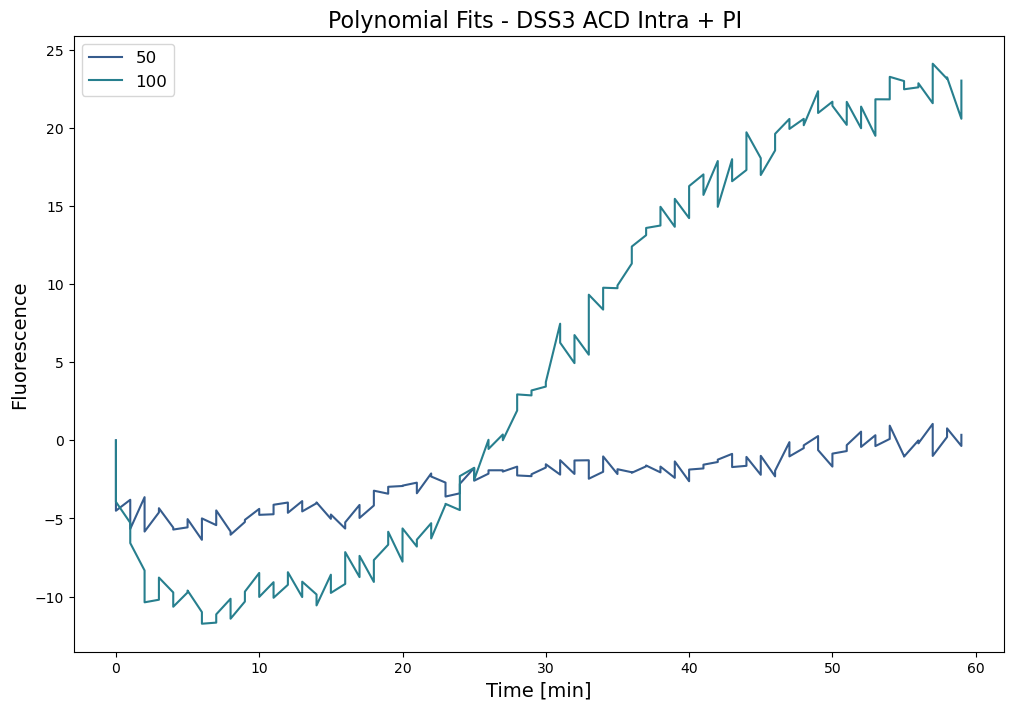

/var/folders/hb/hntvhz5j0j15vb_5h21tbhph0000gn/T/ipykernel_24207/1377302537.py:112: RuntimeWarning: divide by zero encountered in scalar divide
  res_var = np.sum(residuals**2) / (n - 2)


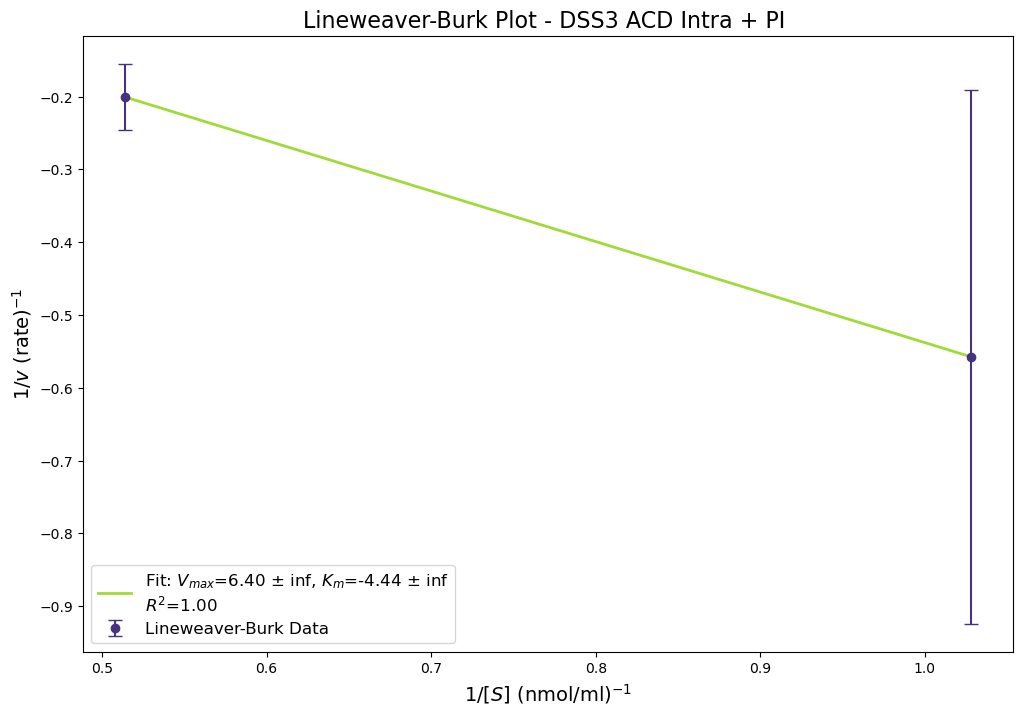

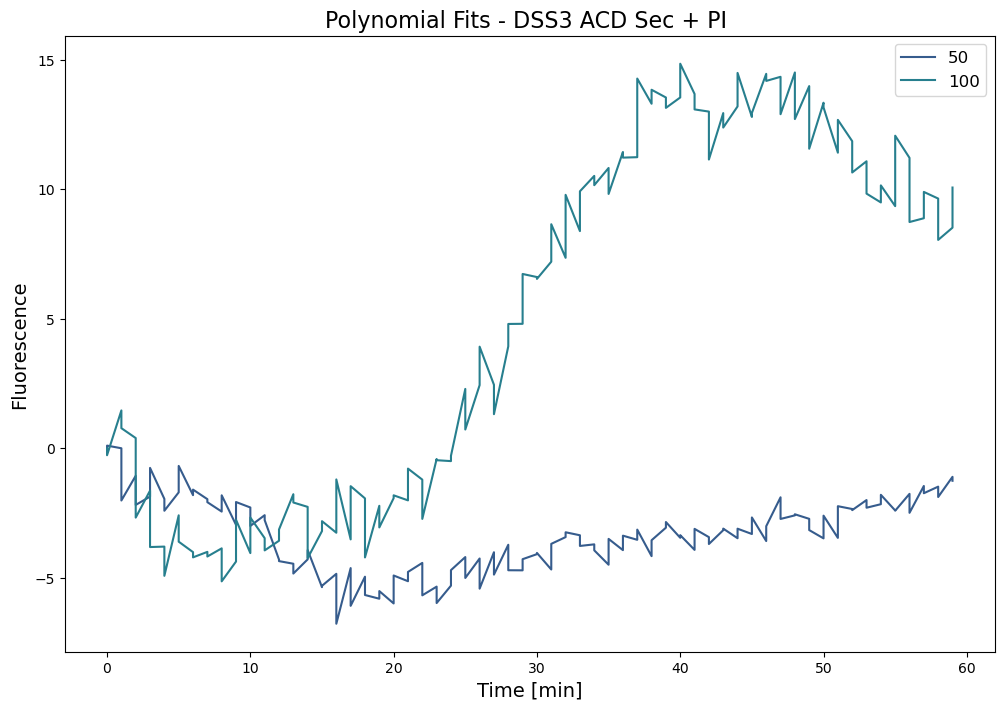

/var/folders/hb/hntvhz5j0j15vb_5h21tbhph0000gn/T/ipykernel_24207/1377302537.py:112: RuntimeWarning: invalid value encountered in scalar divide
  res_var = np.sum(residuals**2) / (n - 2)


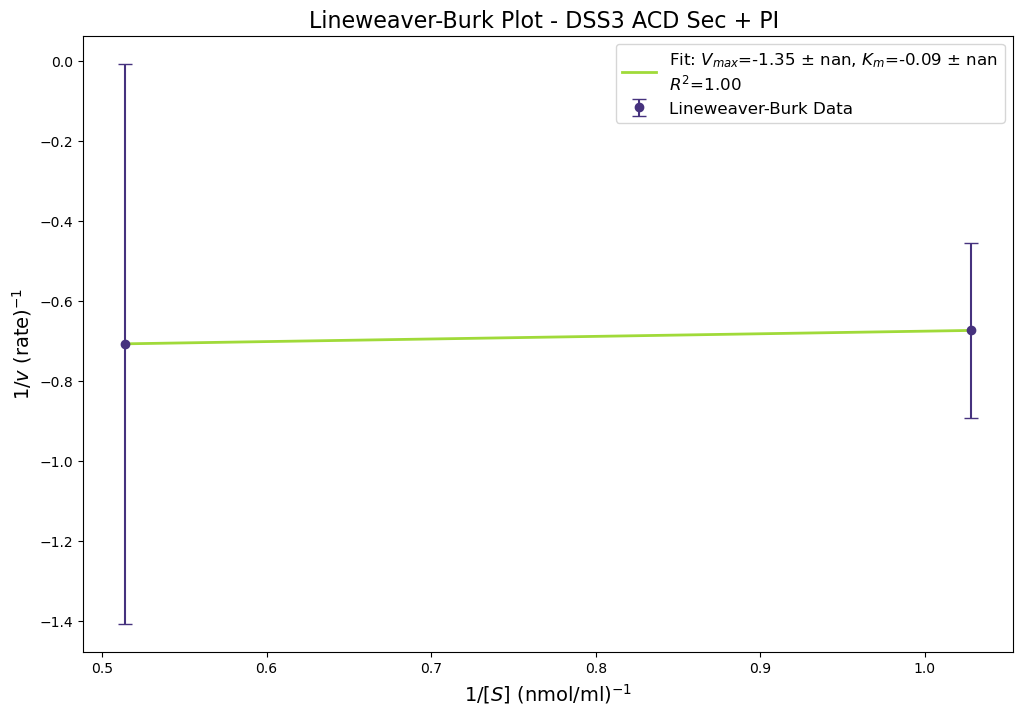

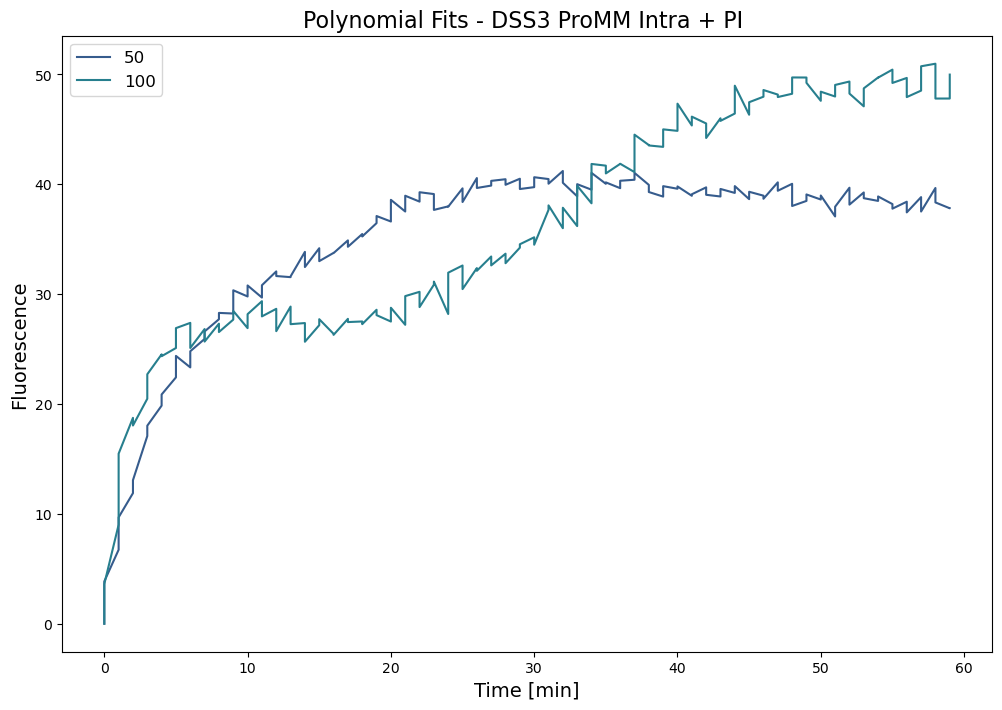

/var/folders/hb/hntvhz5j0j15vb_5h21tbhph0000gn/T/ipykernel_24207/1377302537.py:112: RuntimeWarning: divide by zero encountered in scalar divide
  res_var = np.sum(residuals**2) / (n - 2)


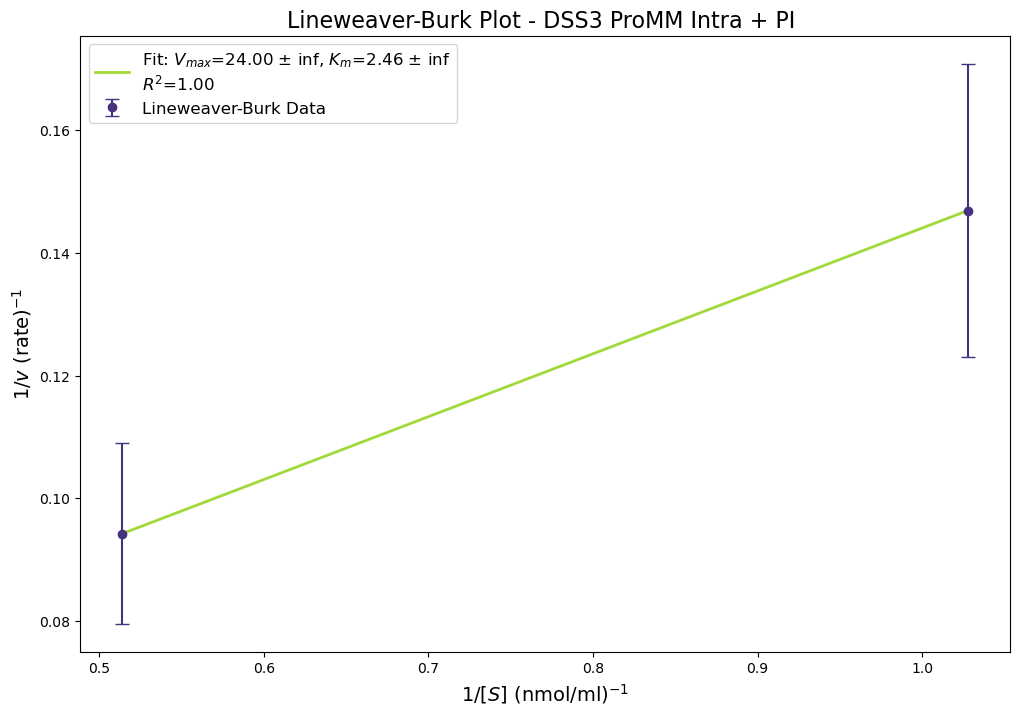

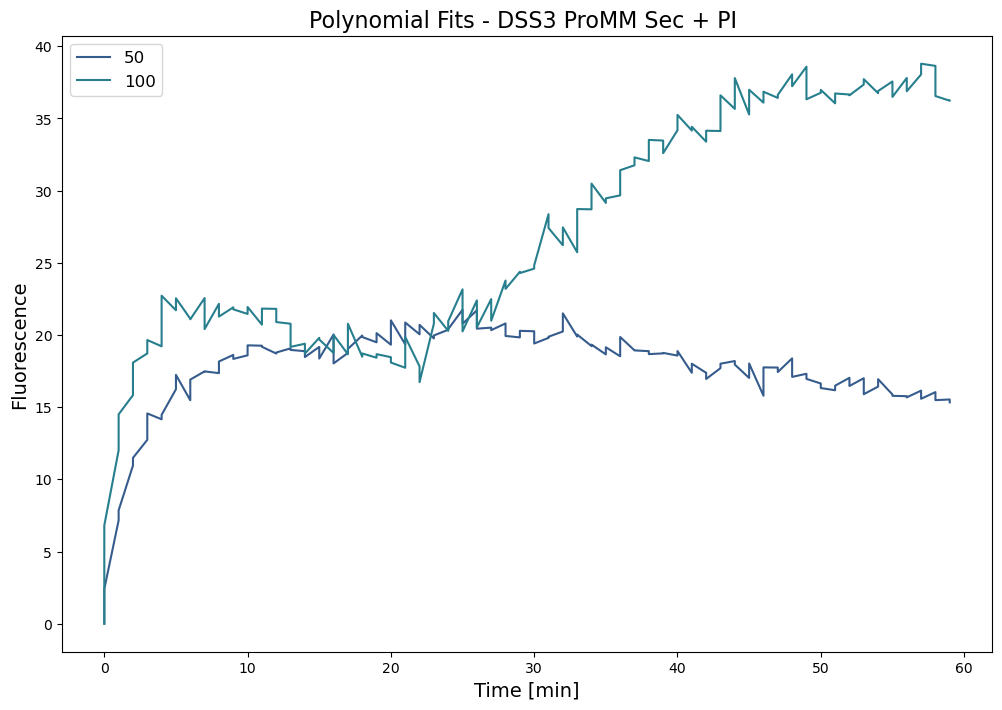

/var/folders/hb/hntvhz5j0j15vb_5h21tbhph0000gn/T/ipykernel_24207/1377302537.py:112: RuntimeWarning: divide by zero encountered in scalar divide
  res_var = np.sum(residuals**2) / (n - 2)


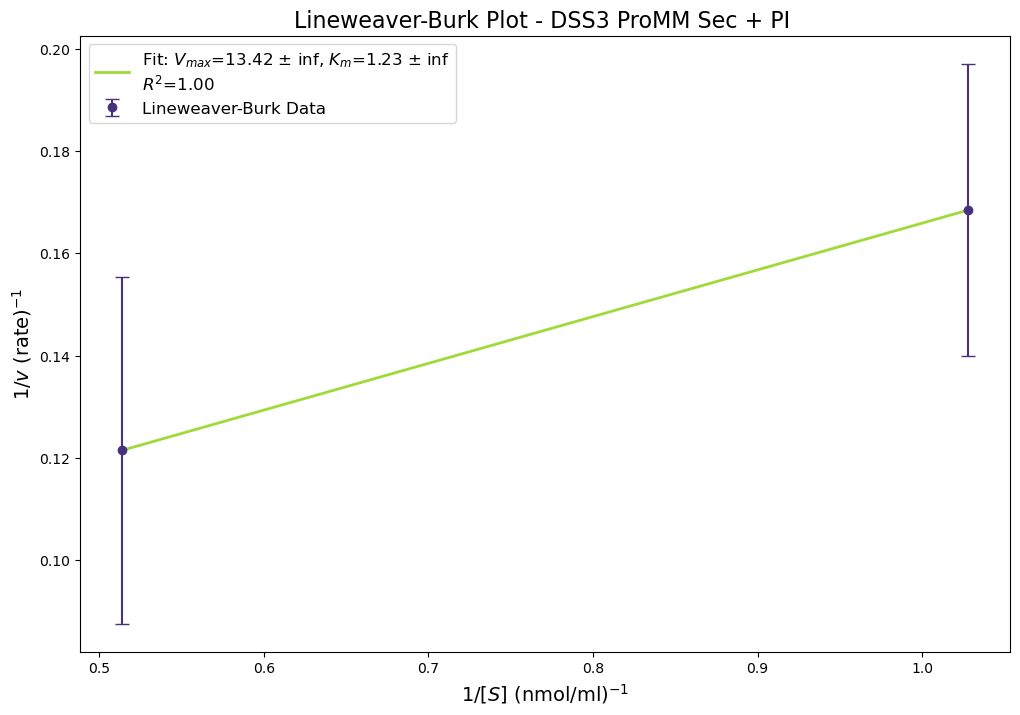

(np.float64(13.42018805457539),
 np.float64(inf),
 np.float64(1.2265341724895436),
 np.float64(inf),
 np.float64(1.0),
 array([0.        , 5.93664019, 8.23017012]),
 array([1.00000000e-06, 1.00830370e+00, 2.29890244e+00]))

In [16]:
enzyme_kinetics_lineweaver_burk_2PI(ACD_Intra_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ACD Intra + PI', filename = '../GENERALS/LBP/LBP_DSS3_ACD_Intra_PI.pdf')
enzyme_kinetics_lineweaver_burk_2PI(ACD_Sec_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ACD Sec + PI', filename = '../GENERALS/LBP/LBP_DSS3_ACD_Sec_PI.pdf')
enzyme_kinetics_lineweaver_burk_2PI(ProMM_Intra_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM Intra + PI', filename = '../GENERALS/LBP/LBP_DSS3_ProMM_Intra_PI.pdf')
enzyme_kinetics_lineweaver_burk_2PI(ProMM_Sec_PI, substrate_concentrations=substrate_concs, protein_name='DSS3 ProMM Sec + PI', filename = '../GENERALS/LBP/LBP_DSS3_ProMM_Sec_PI.pdf')



# Protease kinetics summary bar plot!

First lets process the flow cytometry data in order to correct the protease kinetics for per cell. We take mean and std, then multiply by 25 to obtain the number of cells in each protease assay well. 

In [7]:
# Import FCM data
FCM = pd.read_csv('../../GENERALS/FCM_DSS3.txt', delimiter='\t')

# Group by 'Sample' and calculate the mean and std
FCM_stat = FCM.groupby('Sample')['Events/ul'].agg(['mean', 'std']).reset_index()

# Extract the mean of the seawater blank
sw_blank_mean = FCM_stat.loc[FCM_stat['Sample'].str.contains('SW blank'), 'mean'].values[0]

# Subtract the mean seawater blank from all samples
FCM_stat['mean_bc'] = FCM_stat['mean'] - sw_blank_mean

# Extract the base sample names (remove replicate numbers)
FCM_stat['base_sample'] = FCM_stat['Sample'].str.replace(r'\s*\d+$', '', regex=True)

# Group by the base sample name and calculate the mean and std across replicates
FCM_summary = FCM_stat.groupby('base_sample').agg(
    mean_final=('mean_bc', 'mean'),  # Mean of blank-corrected values
    std_final=('mean_bc', 'std')     # Std of blank-corrected values
).reset_index()

# Account for 50 ul sample volume in protease assay. Each FCM sample contained 2 ul of the original culture. Thus multiply by 25
FCM_summary['Cells/PA'] = FCM_summary['mean_final'] * 25

# Scale the standard deviation by the same factor
FCM_summary['std_PA'] = FCM_summary['std_final'] * 25

# Drop the last two rows based on index
FCM_summary = FCM_summary.drop(FCM_summary.index[-2:])

# Display the resulting DataFrame
print(FCM_summary)

  base_sample  mean_final  std_final     Cells/PA       std_PA
0      Casein  288.777778  61.295580  7219.444444  1532.389504
1          NC  231.777778  17.639392  5794.444444   440.984799
2       ProMM  139.555556   5.872093  3488.888889   146.802336


In [8]:
# Load vmax, Km data from the file
MM = pd.read_csv('../../GENERALS/Kinetics_Summary.txt', delimiter='\t')

# Function to get the base name from the 'Sample' column (extract everything before the first space)
def get_base_name(sample_name):
    return sample_name.split(' ')[0]

# Add a new column 'base_sample' to the MM DataFrame to match the base sample names
MM['base_sample'] = MM['Sample'].apply(get_base_name)

# UI = uninhibited, PI = with protease inhibitor
MM_UI=MM.drop(MM.index[-6:])
MM_PI=MM.drop(index=range(6))

# Merge the MM DataFrames with the FCM_summary DataFrame on the base sample
merged_UI = pd.merge(MM_UI, FCM_summary, how='left', left_on='base_sample', right_on='base_sample')
merged_PI = pd.merge(MM_PI, FCM_summary, how='left', left_on='base_sample', right_on='base_sample')

# To get the rates and std in units of Enzyme Units (µmol min-1), take extracted vmax from michaelis menten fit in fmol min-1, to obtain 
#merged_UI['vmax_EU'] = (merged_UI['vmax']*400) #fmol 
#merged_UI['stdev_vmax_EU'] = (merged_UI['stdev_vmax']*400) 

#merged_PI['vmax_EU'] = (merged_PI['vmax']*400) 
#merged_PI['stdev_vmax_EU'] = (merged_PI['stdev_vmax']*400) 

## Conversion of v0 from FI min-1 to fmol min-1
merged_UI['v0_fmol'] = (merged_UI['v0']*2.5) #fmol 
merged_UI['stdev_v0_fmol'] = (merged_UI['stdev_v0']*2.5) 

merged_PI['v0_fmol'] = (merged_PI['v0']*2.5) 
merged_PI['stdev_v0_fmol'] = (merged_PI['stdev_v0']*2.5) 

# Divide the relevant columns by the final cell counts. Result is in fmol min-1 cell-1
merged_UI['vmax_cell'] = (merged_UI['vmax']) / merged_UI['Cells/PA']
merged_UI['stdev_vmax_cell'] = (merged_UI['stdev_vmax']) / merged_UI['Cells/PA']
merged_UI['Km_cell'] = merged_UI['Km'] / merged_UI['Cells/PA']
merged_UI['stdev_Km_cell'] = merged_UI['stdev_Km'] / merged_UI['Cells/PA']
merged_UI['v0_cell'] = (merged_UI['v0_fmol']) / merged_UI['Cells/PA']
merged_UI['stdev_v0_cell'] = (merged_UI['stdev_v0_fmol']) / merged_UI['Cells/PA']

merged_PI['vmax_cell'] = (merged_PI['vmax']) / merged_PI['Cells/PA']
merged_PI['stdev_vmax_cell'] = (merged_PI['stdev_vmax']) / merged_PI['Cells/PA']
merged_PI['Km_cell'] = merged_PI['Km'] / merged_PI['Cells/PA']
merged_PI['stdev_Km_cell'] = merged_PI['stdev_Km'] / merged_PI['Cells/PA']
merged_PI['v0_cell'] = (merged_PI['v0_fmol']) / merged_PI['Cells/PA']
merged_PI['stdev_v0_cell'] = (merged_PI['stdev_v0_fmol']) / merged_PI['Cells/PA']

print(merged_UI)
print(merged_PI)

         Sample   vmax  stdev_vmax    Km  stdev_Km     v0  stdev_v0  \
0   ProMM Intra  14.11        6.12  0.84      0.52  11.21      2.00   
1  Casein Intra  38.15       25.97  2.71      1.94  18.06      3.21   
2     NC  Intra  44.46       22.28  2.89      1.51  18.63      3.23   
3     ProMM Sec   8.87        5.50  0.42      0.52   9.02      1.67   
4    Casein Sec  56.49       46.35  3.90      3.27  19.86      3.44   
5        NC Sec   0.00        0.00  0.00      0.00  17.53      2.98   

  base_sample  mean_final  std_final     Cells/PA       std_PA  v0_fmol  \
0       ProMM  139.555556   5.872093  3488.888889   146.802336   28.025   
1      Casein  288.777778  61.295580  7219.444444  1532.389504   45.150   
2          NC  231.777778  17.639392  5794.444444   440.984799   46.575   
3       ProMM  139.555556   5.872093  3488.888889   146.802336   22.550   
4      Casein  288.777778  61.295580  7219.444444  1532.389504   49.650   
5          NC  231.777778  17.639392  5794.444444   

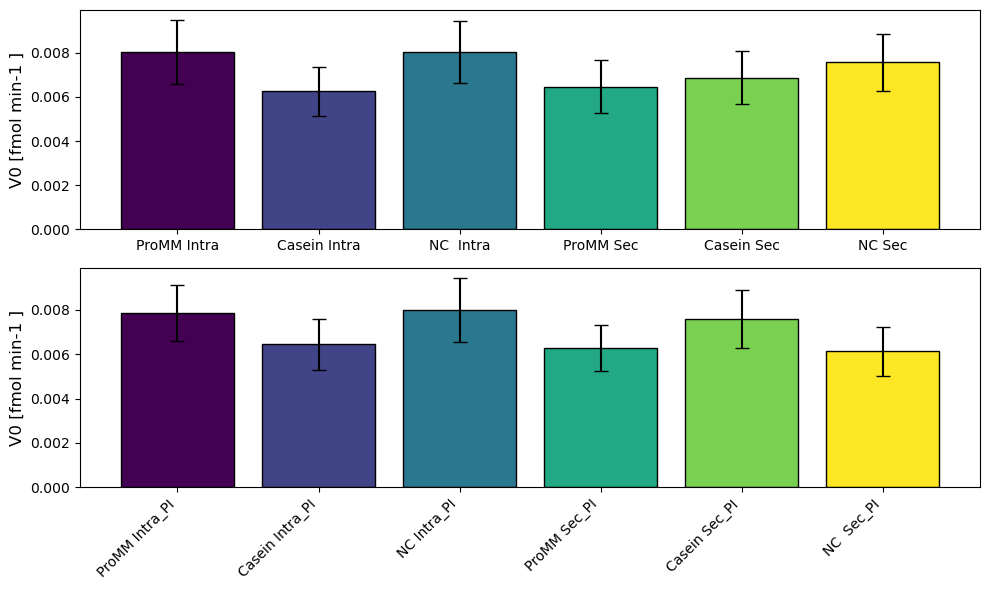

In [9]:
# Extract relevant data, change between _cell or _fmol to plot either per cell or bulk activity
x_labels = merged_UI['Sample']
vmax_values = merged_UI['v0_cell']
stdev_values = merged_UI['stdev_v0_cell']
km_values = merged_UI['Km']

x_labels_PI = merged_PI['Sample']
vmax_values_PI = merged_PI['v0_cell']
stdev_values_PI = merged_PI['stdev_v0_cell']
km_values_PI = merged_PI['Km']

# Create the bar plot
fig, ax = plt.subplots(2, figsize=(10, 6))

# Use viridis colormap
cmap = plt.cm.viridis

# Create bars with error bars and apply viridis colormap
bars_UI = ax[0].bar(x_labels, vmax_values, yerr=stdev_values, capsize=5, color=cmap(np.linspace(0, 1, len(vmax_values))), edgecolor='black')
bars_PI = ax[1].bar(x_labels_PI, vmax_values_PI, yerr=stdev_values_PI, capsize=5, color=cmap(np.linspace(0, 1, len(vmax_values_PI))), edgecolor='black')

# Set axis labels and title
ax[0].set_ylabel('V0 [fmol min-1 ]', fontsize=12)
ax[1].set_ylabel('V0 [fmol min-1 ]', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define the range based on the data or your desired limits
#y_min = 0
#y_max = 50000

# Set y-axis limits
#ax[0].set_ylim(y_min, y_max)
#ax[1].set_ylim(y_min, y_max)


# Show the plot
plt.tight_layout()
#plt.savefig('../../GENERALS/v0_barplot_fmolpermin_corr.pdf', format='pdf')
plt.show()

# BAR CHARTS OF V AT SPECIFIC TIME

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial import Polynomial
import re

def plot_kinetics(df, protein_name='', title='', figsize=(15, 7)):
    """
    Plots fluorescence kinetics with polynomial fitting and displays fit statistics.
    
    Parameters:
        - df: DataFrame with 'Time' and fluorescence data
        - protein_name: Name of the protein for the title
        - title: Additional plot title
        - figsize: Figure size
    
    Returns:
        - fit_stats: Dictionary with max derivative and fit statistics for each condition
    """

    ## Convert Time column to minutes
    def timetomin(time_str):
        h, m, s = map(int, time_str.split(':'))
        return h * 60 + m 

    ## Apply the timetomin function to the time column
    time = df['Time'].apply(timetomin)

    ## Filter data to only include time points ≤ 60 minutes
    mask = time <= 60
    time = time[mask]
    df_filtered = df.loc[mask]

    ## Normalize the data to start at 0 fluorescence
    # Make a copy of the data frame that runs up to 60 mins.
    df_normalized = df_filtered.copy()

    # For each column that is not the time column, calculate the data normalized to the first datapoint (iloc[0]) 
    for col in df_filtered.columns:
        if col != 'Time':
            df_normalized[col] = df_filtered[col] - df_filtered[col].iloc[0]
    
    plt.figure(figsize=figsize)

    fit_stats = {}  # Dictionary to store fit statistics

    # Apply Viridis color palette with length of the color palette defined by number of columns (samples)
    colors = sns.color_palette("viridis", n_colors=len(df_filtered.columns) - 1)
    rep_counter = 0  # Counter to assign concentration to each sample

    for i, col in enumerate(df_filtered.columns):
        if col != 'Time' and 'Std' not in col:
            conc = col  # Now '25', '50', etc.
            sample_with_conc = f"{protein_name}_{conc}"

            plt.plot(time, df_normalized[col], label=sample_with_conc, color=colors[i])

            try:
                degree = 9
                poly = Polynomial.fit(time, df_normalized[col], degree)
                poly_eval = poly(time)

                deriv_poly = poly.deriv()
                deriv_values = deriv_poly(time)

                t = 0
                derivative_at_t = deriv_poly(t)

                R2 = 1 - np.sum((df_normalized[col] - poly_eval) ** 2) / np.sum((df_normalized[col] - np.mean(df_normalized[col])) ** 2)

                # Store statistics using new sample name
                fit_stats[sample_with_conc] = {
                    "derivative_at_t": derivative_at_t,
                    "R²": R2,
                    "Std_derivative": np.std(deriv_values),
                    "Sample": protein_name,
                    "Concentration": conc
                }

                print(f"\n{sample_with_conc}:")
                print(f"  Derivative at t: {derivative_at_t:.4f}")
                print(f"  R²: {R2:.4f}")
                print(f"  Std of derivative: {np.std(deriv_values):.4f}")

                plt.plot(time, poly_eval, '--', color=colors[i], alpha=0.8, label=f"{sample_with_conc} (Poly Fit)")

            except Exception as e:
                print(f"Error in fitting polynomial for {col}: {e}")

            rep_counter += 1

    plt.title(f'Proteolysis kinetics - {protein_name} {title}')
    plt.xlabel('Time [min]')
    plt.ylabel('Fluorescence')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.close()

    # Collect data for grouped bar plot
    data_for_barplot = []

    for stats in fit_stats.values():
        sample_clean = re.sub(r'_\d+$', '', stats["Sample"])  # Remove replicate ID
        data_for_barplot.append({
            "Sample": sample_clean,
            "Concentration": stats["Concentration"],
            "Derivative_at_30": stats["derivative_at_t"]
        })

    # Convert to DataFrame
    barplot_df = pd.DataFrame(data_for_barplot)

    # Sort concentrations numerically for consistent ordering
    barplot_df["Concentration"] = pd.Categorical(barplot_df["Concentration"],
                                                  categories=["25", "50", "100", "150"],
                                                  ordered=True)

    # Plot grouped barplot
    #plt.figure(figsize=(12, 6))
    #sns.barplot(data=barplot_df, x="Concentration", y="Derivative_at_30", hue="Sample", palette="viridis")

    #plt.title('Initial velocity (v₀) at 10 min by Concentration and Sample')
    #plt.xlabel('[Substrate] (µM)')
    #plt.ylabel('v₀ at 10 min (Fluorescence/min)')
    #plt.legend(title="Sample")
    #plt.tight_layout()
    #plt.show()

    return fit_stats


def process_all_samples(sample_dict):
    all_stats = []

    for sample_name, df in sample_dict.items():
        stats = plot_kinetics(df, protein_name=sample_name)
        for s in stats.values():
            all_stats.append({
                "Sample": sample_name,
                "Concentration": s["Concentration"],
                "Derivative_at_30": s["derivative_at_t"]
            })

    # Make single barplot combining all samples
    df_bar = pd.DataFrame(all_stats)
    df_bar["Sample"] = pd.Categorical(df_bar["Sample"],
                                             categories=["ProMM_Intra", "+Pr_Intra", "-NC+Pr_Intra", "ProMM_Sec", "+Pr_Sec", "-NC+Pr_Sec"], ordered=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_bar, x="Sample", y="Derivative_at_30", hue="Concentration", palette="viridis")
    plt.title('Initial velocity (v₀) at 0 min by Concentration and Sample')
    plt.xlabel('Sample')
    plt.ylabel('v₀ at t=0 min (Fluorescence/min)')
    plt.legend(title="Sample")
    plt.tight_layout()
    plt.savefig('../../GENERALS/v0_t0.pdf', format='pdf')
    plt.show()



ProMM_Intra_25:
  Derivative at t: 5.7891
  R²: 0.9938
  Std of derivative: 1.1079

ProMM_Intra_50:
  Derivative at t: 5.4041
  R²: 0.9857
  Std of derivative: 1.1646

ProMM_Intra_100:
  Derivative at t: 11.2089
  R²: 0.9674
  Std of derivative: 1.9997

ProMM_Intra_150:
  Derivative at t: 12.2714
  R²: 0.8967
  Std of derivative: 1.9453


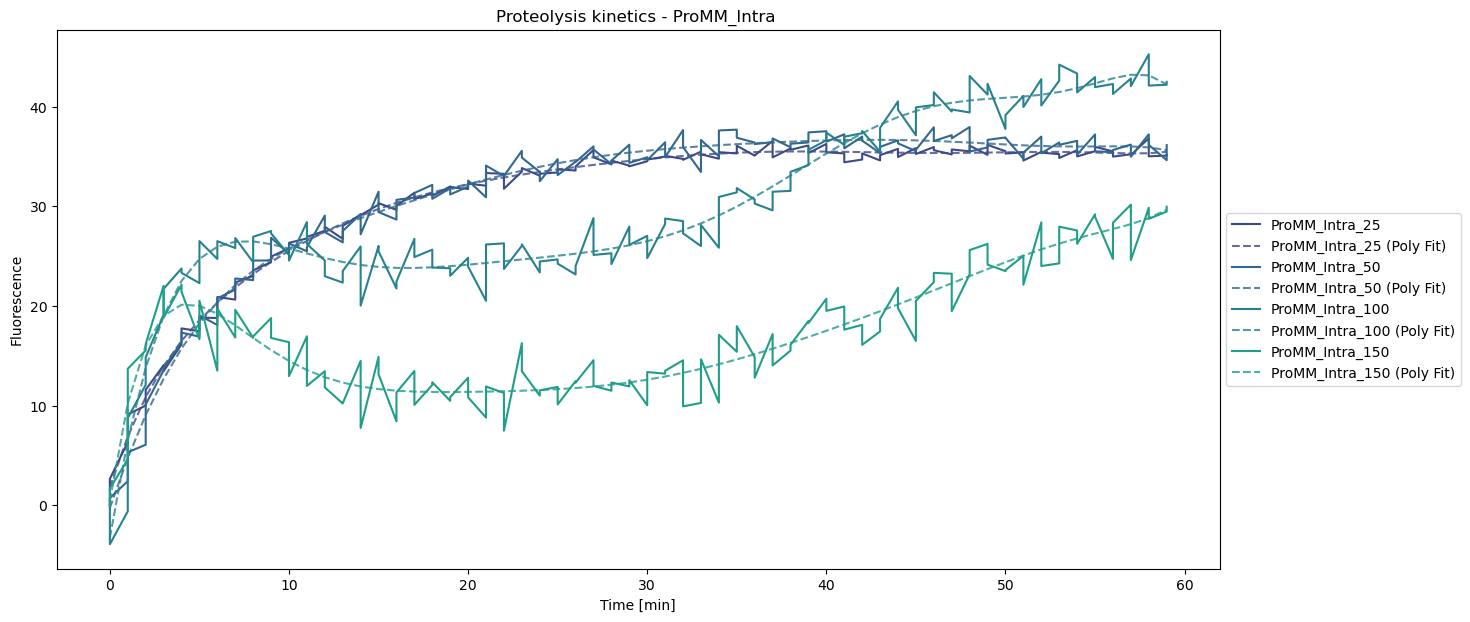

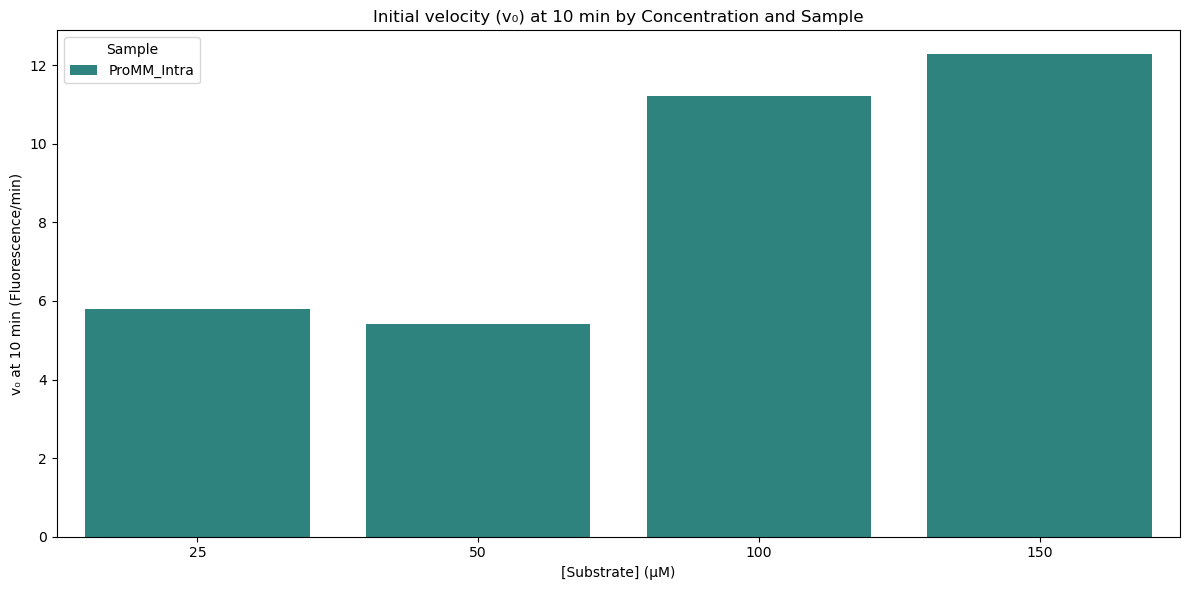


ProMM_Sec_25:
  Derivative at t: 5.3211
  R²: 0.9854
  Std of derivative: 0.9530

ProMM_Sec_50:
  Derivative at t: 4.8222
  R²: 0.9205
  Std of derivative: 0.8779

ProMM_Sec_100:
  Derivative at t: 9.0299
  R²: 0.9448
  Std of derivative: 1.6655

ProMM_Sec_150:
  Derivative at t: 2.9020
  R²: 0.2746
  Std of derivative: 1.6798


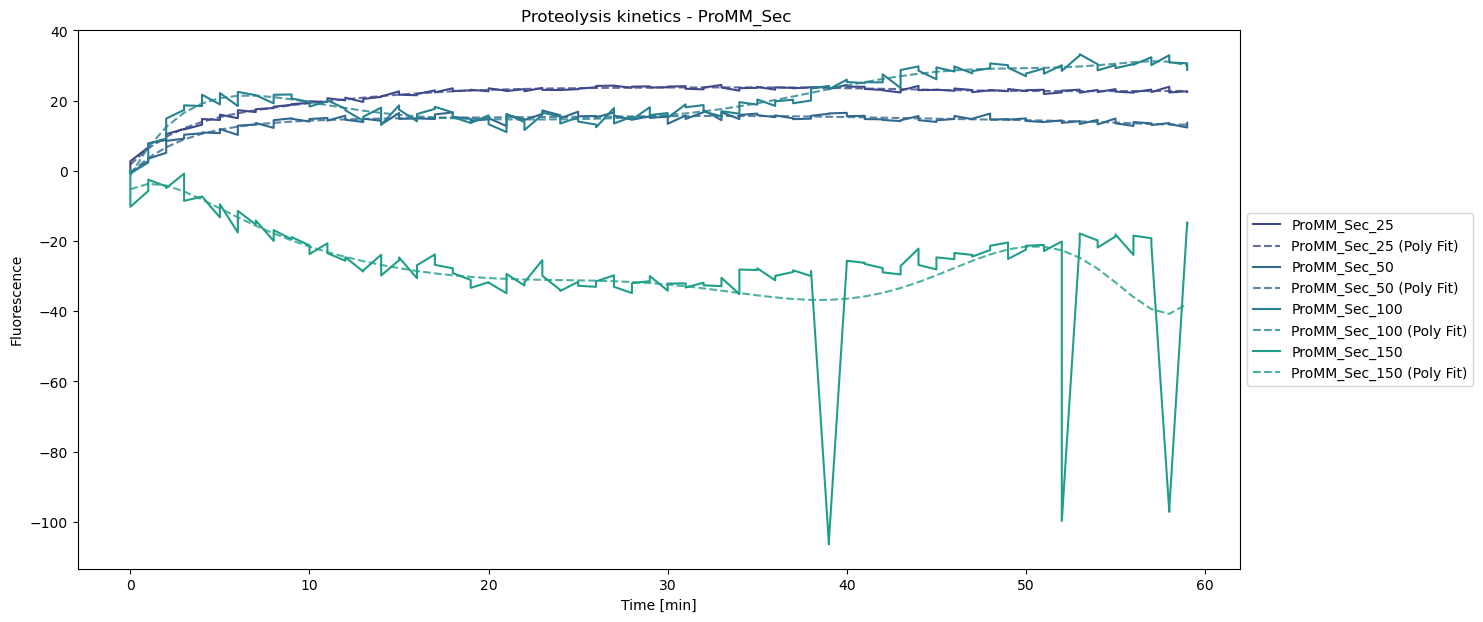

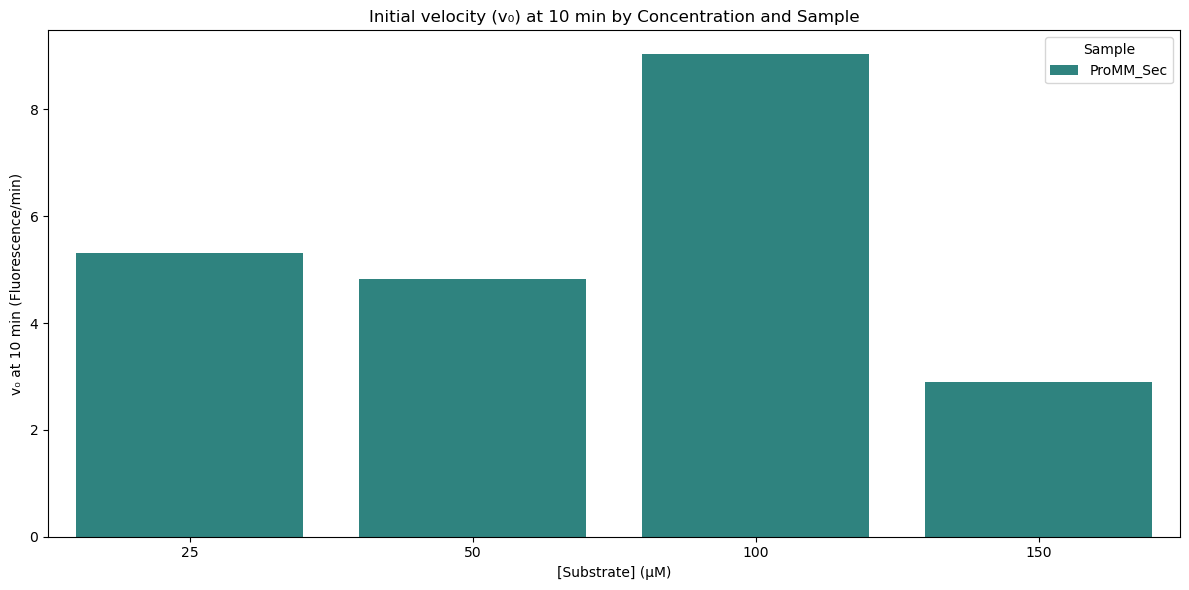


-NC+Pr_Intra_25:
  Derivative at t: 6.6403
  R²: 0.9980
  Std of derivative: 1.2771

-NC+Pr_Intra_50:
  Derivative at t: 9.1996
  R²: 0.9966
  Std of derivative: 1.7790

-NC+Pr_Intra_100:
  Derivative at t: 18.6331
  R²: 0.9966
  Std of derivative: 3.2282

-NC+Pr_Intra_150:
  Derivative at t: 25.7350
  R²: 0.9943
  Std of derivative: 4.0169


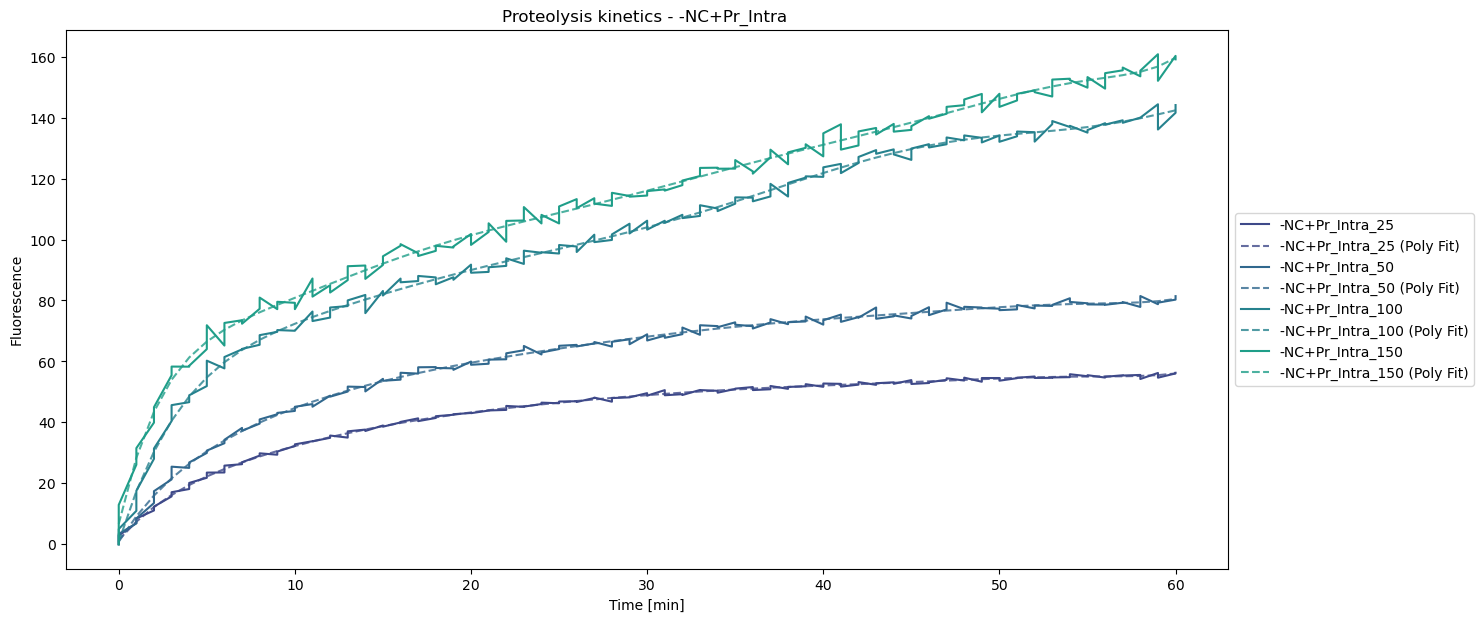

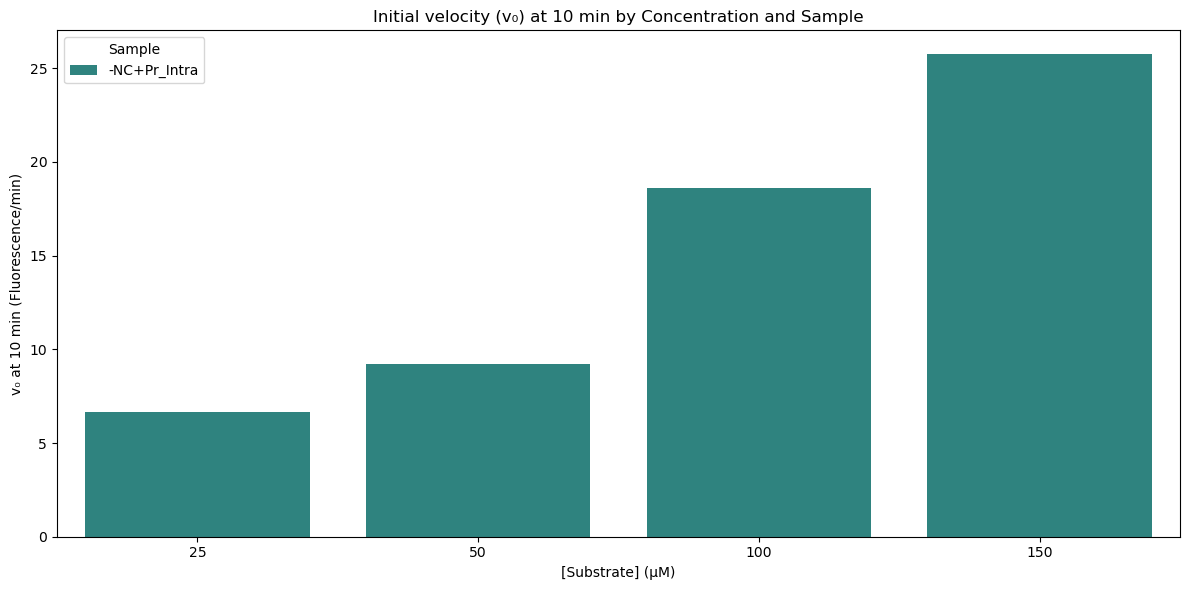


-NC+Pr_Sec_25:
  Derivative at t: 2.7850
  R²: 0.9944
  Std of derivative: 0.6794

-NC+Pr_Sec_50:
  Derivative at t: 5.6588
  R²: 0.9913
  Std of derivative: 1.1775

-NC+Pr_Sec_100:
  Derivative at t: 17.5303
  R²: 0.9694
  Std of derivative: 2.9849

-NC+Pr_Sec_150:
  Derivative at t: 19.9422
  R²: 0.9912
  Std of derivative: 3.0529


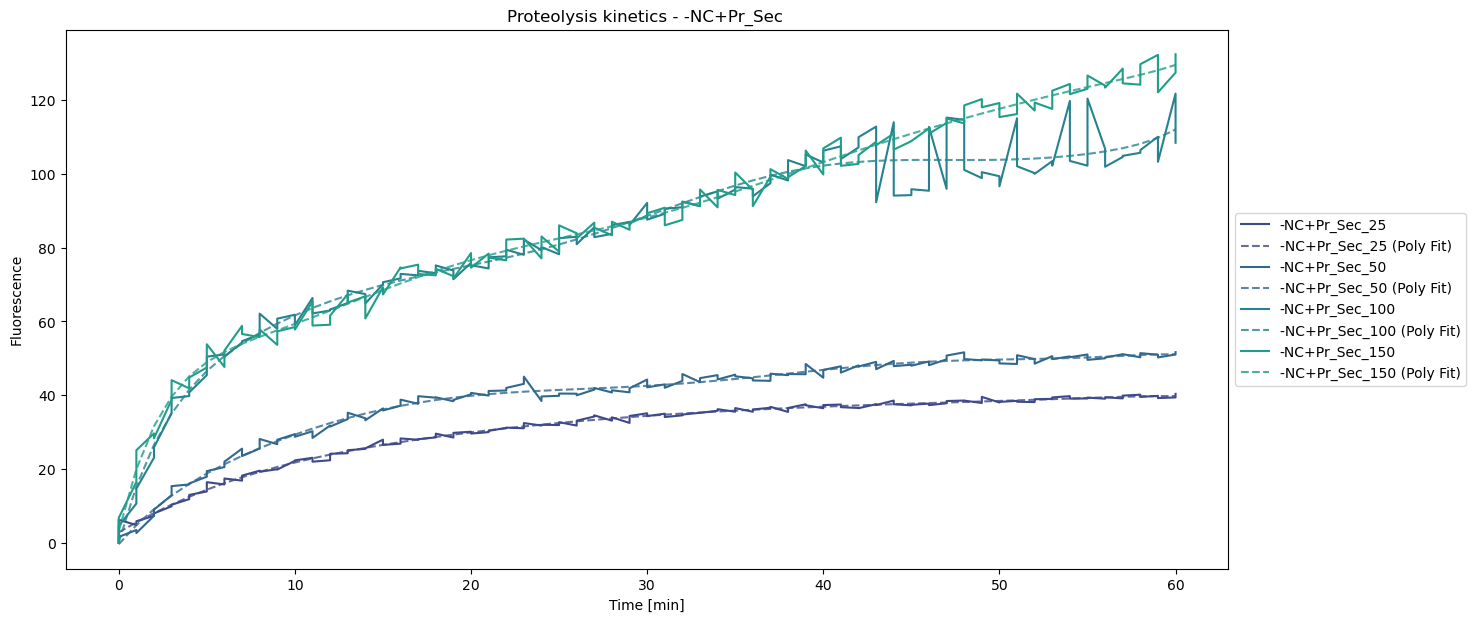

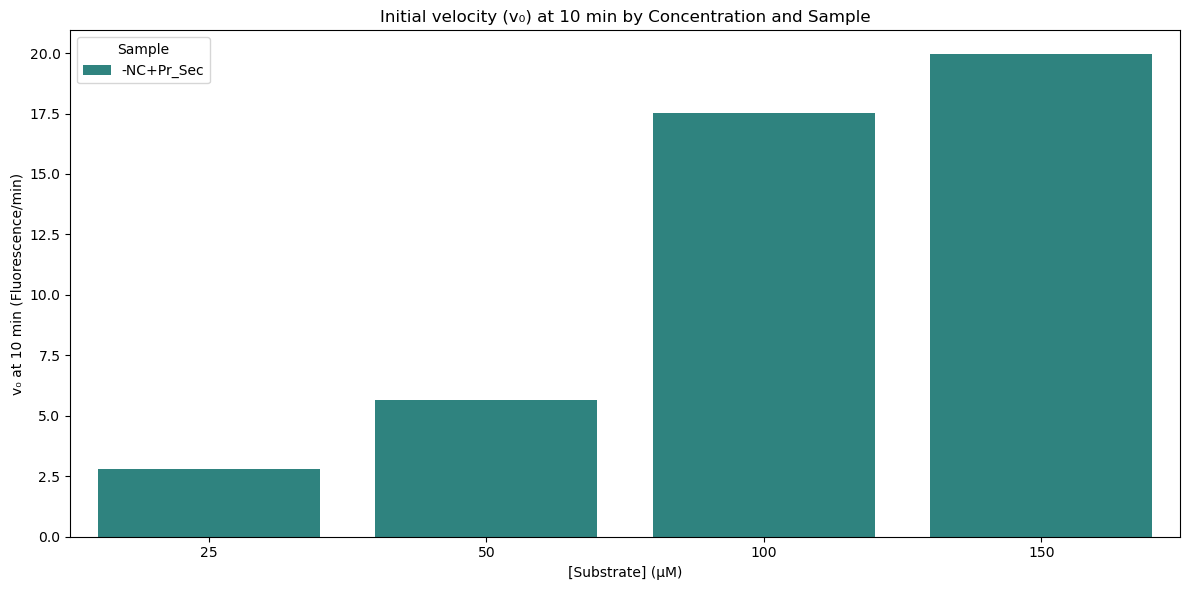


+Pr_Intra_25:
  Derivative at t: 6.1577
  R²: 0.9978
  Std of derivative: 1.2321

+Pr_Intra_50:
  Derivative at t: 7.8826
  R²: 0.9959
  Std of derivative: 1.6586

+Pr_Intra_100:
  Derivative at t: 18.0633
  R²: 0.9954
  Std of derivative: 3.2094

+Pr_Intra_150:
  Derivative at t: 22.7375
  R²: 0.9944
  Std of derivative: 3.5397


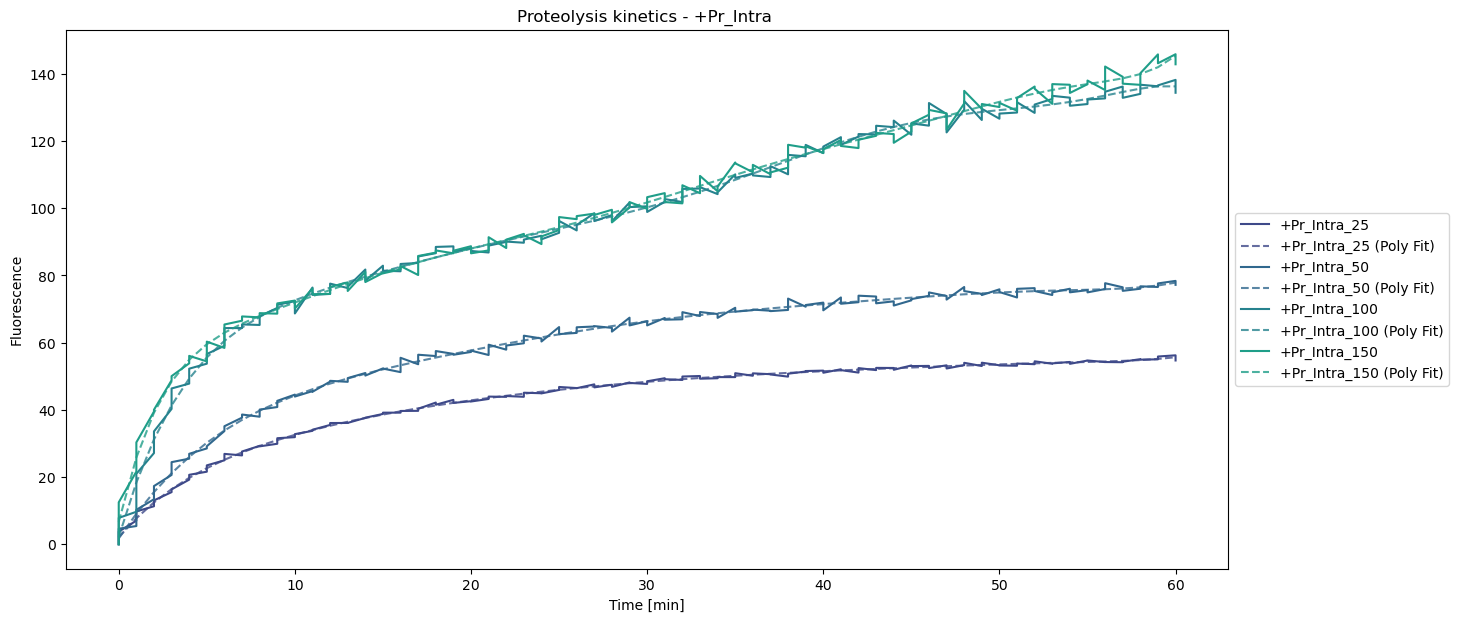

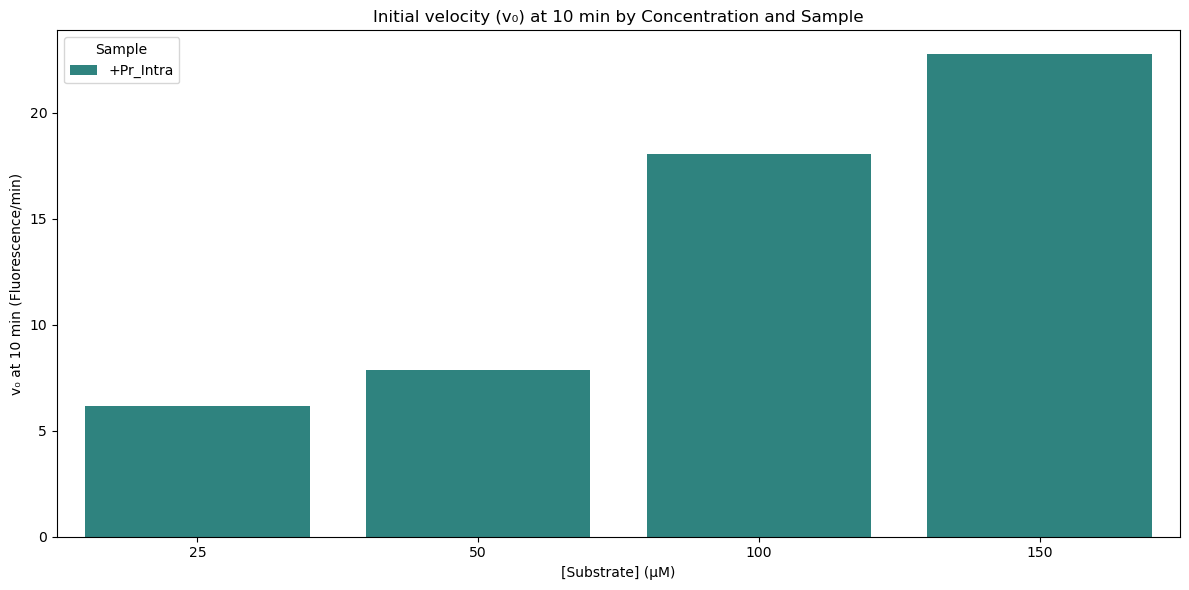


+Pr_Sec_25:
  Derivative at t: 6.6545
  R²: 0.9971
  Std of derivative: 1.2984

+Pr_Sec_50:
  Derivative at t: 9.0590
  R²: 0.9965
  Std of derivative: 1.8119

+Pr_Sec_100:
  Derivative at t: 19.8574
  R²: 0.9955
  Std of derivative: 3.4418

+Pr_Sec_150:
  Derivative at t: 29.6315
  R²: 0.9861
  Std of derivative: 4.7023


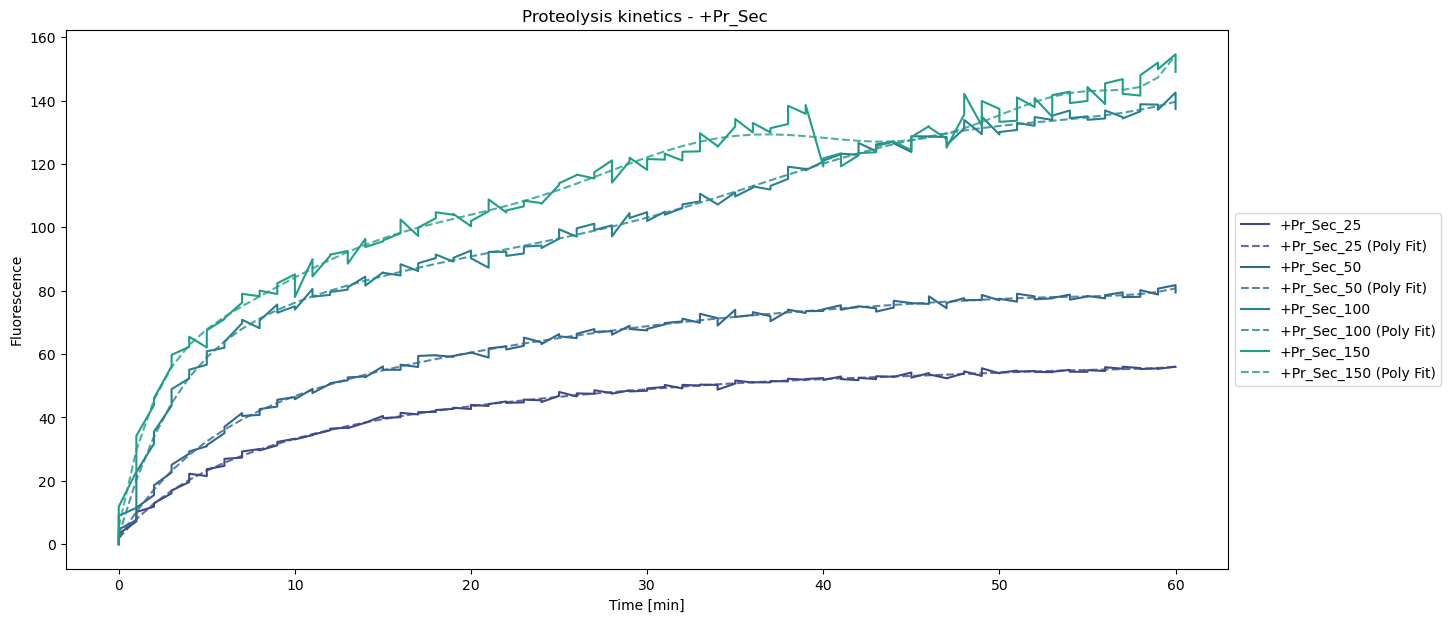

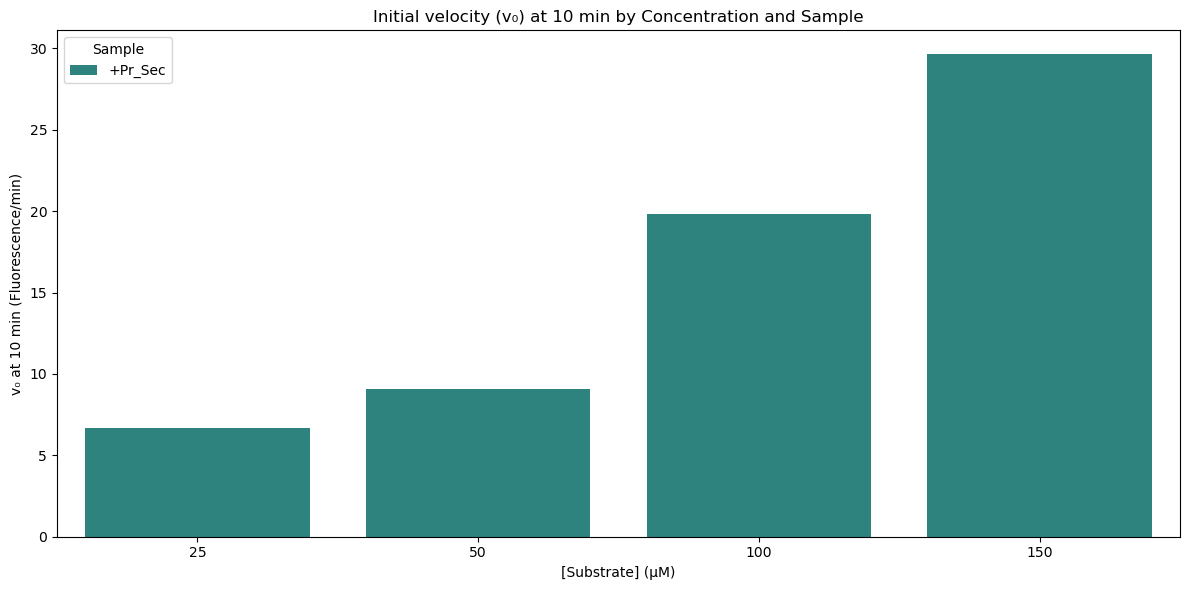

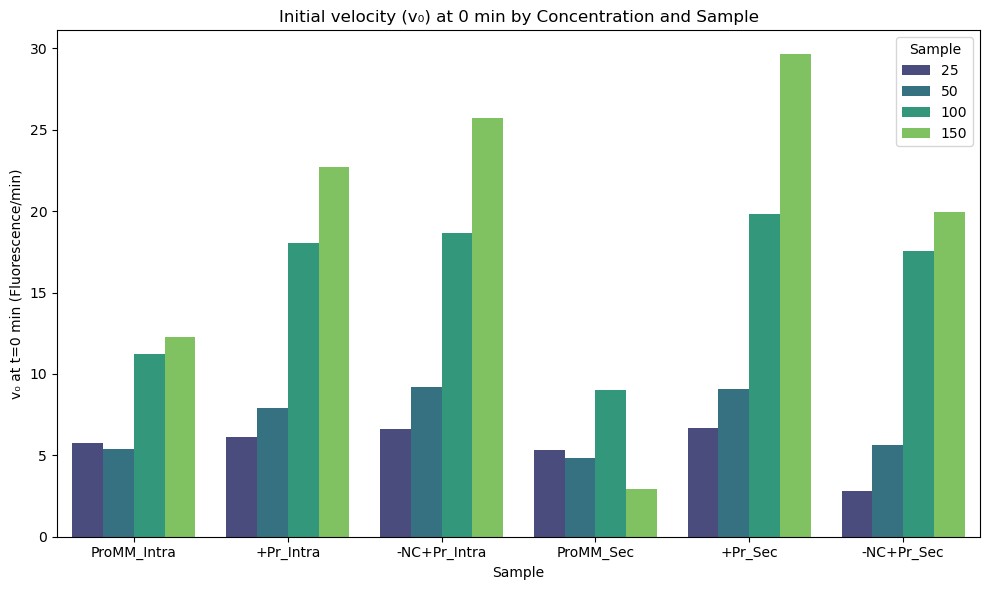

In [89]:
sample_dict = {
    "ProMM_Intra": ProMM_Intra,
    "ProMM_Sec": ProMM_Sec, 
    "-NC+Pr_Intra": ProMM_NC_Intra,
    "-NC+Pr_Sec": ProMM_NC_Sec, 
    "+Pr_Intra": ProMM_Cas_Intra,
    "+Pr_Sec": ProMM_Cas_Sec, 
    #"ProMM_Intra_PI": ProMM_Intra_PI,
    #"+Pr_Intra_PI": ProMM_Cas_Intra_PI,
    #"-NC+Pr_Intra_PI": ProMM_NC_Intra_PI,
    #"ProMM_Sec_PI": ProMM_Sec_PI,
    #"+Pr_Sec_PI": ProMM_Cas_Sec_PI, 
    #"-NC+Pr_Sec_PI": ProMM_NC_Sec_PI, 
}

process_all_samples(sample_dict)